<table width="100%">
  <tr>
    <td>
      <h1 style="text-align: left; font-size:300%;">Data Preparation Pipeline</h1>
      <h2 style="text-align: left; font-size:200%;">Project ID: 20</h2>
      <h3 style="text-align: left; font-size:150%;">Dataset 9: Comune di Milano Esercizi di vicinato in sede fissa</h3>
      <table align="left">
        <tr>
          <td style="text-align: left; font-size: 120%;">Sara Resta</td>
          <td style="text-align: left; font-size: 120%;">10667600</td>
          <td style="text-align: left; font-size: 120%;"><a href="mailto:sara.resta@mail.polimi.it">sara.resta@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left; font-size: 120%;">Francesco Scroccarello</td>
          <td style="text-align: left; font-size: 120%;">10723028</td>
          <td style="text-align: left; font-size: 120%;"><a href="mailto:francesco.scroccarello@mail.polimi.it">francesco.scroccarello@mail.polimi.it</a></td>
        </tr>
      </table>
    </td>
    <td width="20%">
      <div style="text-align: right">
          <br>
        <b style="font-size: 150%;">Data and Information quality course</b><br>
        <b>a.y. 2024-2025</b>
          <br><br>
        prof. Cinzia Cappiello
      </div>
    </td>
  </tr>
</table>


# Contents
1. [Imports and utilities](#1.-Imports-and-utilities)  
2. [Data Profiling and Data Quality assessment](#2.-Data-Profiling-and-Data-Quality-assessment)  
    2.1. [Basic profiling operations](#2.1.-Basic-profiling-operations)  
    2.2. [Single column analysis](#2.2.-Single-column-analysis)  
    &emsp; 2.2.1. [Cardinalities](#2.2.1.-Cardinalities)  
    &emsp; 2.2.2. [Values distributions](#2.2.2.-Values-distributions)  
    2.3. [Dependency Discovery](#2.3.-Dependency-Discovery)
3. [DQ assessment](#3.-DQ-assesment)
4. [Data Wrangling](#4.-Data-Wrangling)  
    4.1. [Settore Merceologico](#4.1.-Settore-Merceologico)  
    4.2. [Insegna](#4.2.-Insegna)  
    4.3. [Ubicazione](#4.3.-Ubicazione)  
    4.4. [Tipo via, Via, Civico, Codice via, Settore Storico Cf Preval](#4.4.-Tipo-via-Via,-Civico,-Codice-via,-Settore-Storico-Cf-Preval)  
    4.5. [Superficie](#4.5.-Superficie)
5. [Inconsistencies](#5.-Inconsistencies)
6. [Missing values handling](#5.-Missing-values-handling)  
    6.1. [Tipo via, Via, Civico, Codice via, ZD](#6.1.-Tipo-via-Via,-Civico,-Codice-via,-ZD)  
    6.2. [Accesso, Isolato, Website, Altre Info](#6.2.-Accesso,-Isolato,-Website,-Altre-Info)  
    6.3. [Superficie](#6.3.-Superficie)  
    6.4. [Settore Merceologico Secondario, Insegna and Settore Storico Cf Preval](#6.4.-Settore-Merceologico-Secondario,-Insegna-and-Settore-Storico-Cf-Preval)  
    6.5. [Settore Merceologico Primario](#6.5.-Settore-Merceologico-Primario)
7. [Outliers handling](#7.-Outliers-handling)

# 1. Imports and utilities
[$\leftarrow$ Back to contents](#Contents)

In [1]:
# Libraries to handle datasets
import pandas as pd
import numpy as np

# Libraries for plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
#warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
os.environ["PYTHONWARNINGS"] = "ignore"

# Statistics
from scipy.stats import pearsonr, spearmanr, shapiro
from scipy.stats import t as t_student

# ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import LocalOutlierFactor, KernelDensity
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score

# Word embedding
from gensim.models import Word2Vec

# Association rules libraries
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

# Record Linkage
import recordlinkage


In [2]:
# set pandas print to fully visualize data when needed
#pd.set_option("display.max_rows", None)

`ZD` column shows administrative divisions of Milan as can be seen [here](https://it.wikipedia.org/wiki/Municipi_di_Milano). These divisions are reported as integer number in the `.csv` file but they represent a category and not a numerical variable. For this reason, this column is imported as `string`.   

<div style="text-align: center;">
    <figure>
        <img src="milan_administrative_divisions.png" alt="Milan Administrative divisions" width="300">
        <figcaption style="font-style: italic;">Milan administrative divisions.</figcaption>
    </figure>
</div>  


In [3]:
# import of the dataset
df = pd.read_csv("Comune-di-Milano-Esercizi-di-vicinato-in-sede-fissa-dirty.csv", sep=';', encoding='latin1', dtype={'ZD': str})

In [4]:
# show first 10 records just for a visualization
df.head()

Settore Merceologico Insegna  \
0                  NaN     NaN   
1                  NaN     NaN   
2                  NaN     NaN   
3                  NaN     NaN   
4                  NaN     NaN   

                                       Ubicazione Tipo via  \
0                       CSO ITALIA N. 34 (z.d. 1)      CSO   
1                        CSO LODI N. 104 (z.d. 4)      CSO   
2                         CSO LODI N. 26 (z.d. 5)      CSO   
3                     CSO SEMPIONE N. 41 (z.d. 6)      CSO   
4  LGO SCALABRINI GIOVANNI BATTISTA N. 2 (z.d. 6)      LGO   

                            Via Civico Codice via ZD  \
0                        ITALIA     34        526  1   
1                          LODI    104       4068  4   
2                          LODI     26       4068  5   
3                      SEMPIONE     41       7137  8   
4  SCALABRINI GIOVANNI BATTISTA      2       5392  6   

  Settore Storico Cf Preval  Superficie Vendita  Superficie Altri Usi  \
0     speciale panificatori                 0.0                   NaN   
1                       NaN                16.0                   5.0   
2     speciale panificatori                 0.0                   NaN   
3                       NaN               120.0                   NaN   
4                       NaN                 0.0                   NaN   

   Superficie Tabelle Speciali  Superficie Totale  
0                          NaN                0.0  
1                          NaN               21.0  
2                          NaN                0.0  
3                          NaN              120.0  
4                          NaN                0.0

# 2. Data Profiling
[$\leftarrow$ Back to contents](#Contents)

## 2.1. Basic profiling operations

In [5]:
n_rows = df.shape[0]
n_cols = df.shape[1]
print(f"Num of rows: {n_rows}\nNum of columns: {n_cols}")

Num of rows: 24136
Num of columns: 13


In [6]:
print("COLUMNS OF THE DATASET:")
for col in df.columns:
    print(f"{col}")

COLUMNS OF THE DATASET:
Settore Merceologico
Insegna
Ubicazione
Tipo via
Via
Civico
Codice via
ZD
Settore Storico Cf Preval
Superficie Vendita
Superficie Altri Usi
Superficie Tabelle Speciali
Superficie Totale


In [7]:
# show for each column the type of its elements
df.dtypes

Settore Merceologico            object
Insegna                         object
Ubicazione                      object
Tipo via                        object
Via                             object
Civico                          object
Codice via                      object
ZD                              object
Settore Storico Cf Preval       object
Superficie Vendita             float64
Superficie Altri Usi           float64
Superficie Tabelle Speciali    float64
Superficie Totale              float64
dtype: object

In [8]:
# separate numerical variables from categorical
num = df[df.select_dtypes(include=['float64']).columns] 
cat = df[df.select_dtypes(include=['object']).columns]

## 2.2. Single column analysis
[$\leftarrow$ Back to contents](#Contents)

### 2.2.1. Cardinalities

For each column, we compute:

- Missing: number of missing values
- Actual: count of the number of records with an actual value (*i.e.,* not-null).
- Cardinality: count of the number of distinct actual values.
- Uniqueness: percentage calculated as Cardinality divided by the total number of records.
- Distinctness: percentage calculated as Cardinality divided by Actual.
- Constancy: "how frequent" is the most frequent value (can help spot standards)

In [9]:
# perform single column analysis for each column
sc_analysis = pd.DataFrame(columns=df.columns,index=['Missing','Actual','Cardinality'])

for col in df.columns:
    cardinality = df[col].nunique() # number of unique values
    actual = df[col].notnull().sum() # number of not null values
    nnull = df[col].isnull().sum() # number of null values

    sc_analysis.loc['Missing', col] = nnull
    sc_analysis.loc['Cardinality', col] = cardinality
    sc_analysis.loc['Actual', col] = actual
    
sc_analysis


Settore Merceologico Insegna Ubicazione Tipo via    Via Civico  \
Missing                      105   17147          1        2      1    650   
Actual                     24031    6989      24135    24134  24135  23486   
Cardinality                   56    5583      16907       20   2331    386   

            Codice via     ZD Settore Storico Cf Preval Superficie Vendita  \
Missing              2      2                        33                 30   
Actual           24134  24134                     24103              24106   
Cardinality       2348     10                      2228                250   

            Superficie Altri Usi Superficie Tabelle Speciali Superficie Totale  
Missing                    15098                       23009                36  
Actual                      9038                        1127             24100  
Cardinality                  438                         117               642

### 2.2.2. Values distributions
[$\leftarrow$ Back to contents](#Contents)

In [10]:
# extract basic statistics for the numerical variables
stats = num.describe()
stats

Superficie Vendita  Superficie Altri Usi  Superficie Tabelle Speciali  \
count        24106.000000           9038.000000                  1127.000000   
mean            56.762715             67.852069                    37.138421   
std             49.281531            280.890686                    29.824418   
min              0.000000              0.000000                     1.000000   
25%             25.000000             10.000000                    13.000000   
50%             40.000000             21.000000                    30.000000   
75%             70.000000             50.000000                    52.500000   
max            250.000000           9056.000000                   230.000000   

       Superficie Totale  
count       24100.000000  
mean           98.350747  
std           266.692535  
min             0.000000  
25%            35.000000  
50%            55.000000  
75%           100.000000  
max         11942.000000

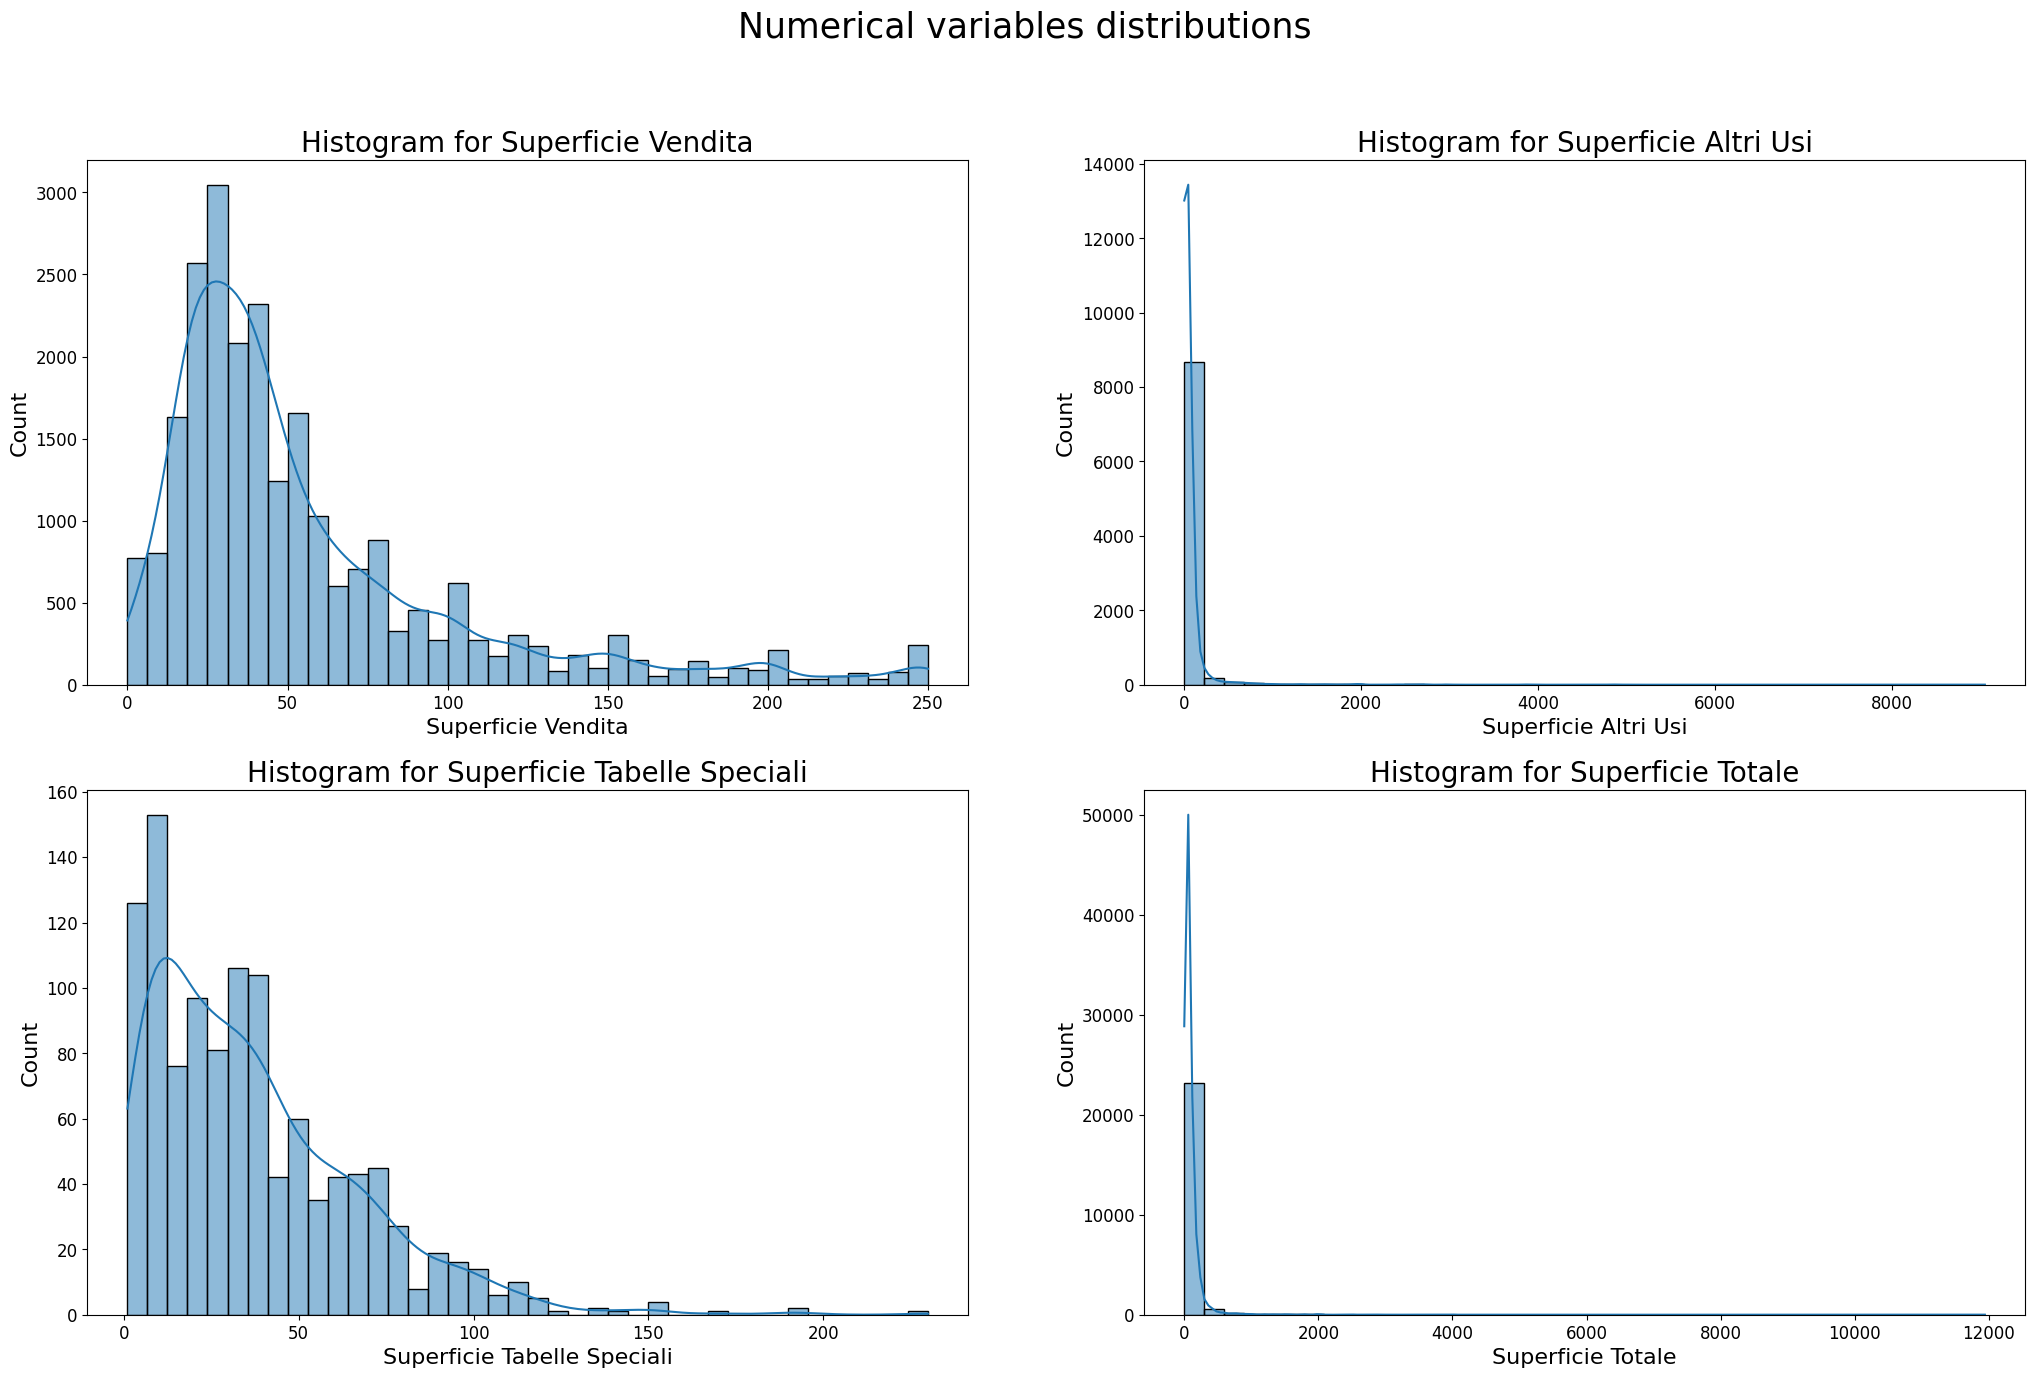

In [11]:
# Plot values distributions
plt.figure(figsize=(25,15))
plt.suptitle("Numerical variables distributions", fontsize=25)
for i, col in enumerate(num):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True, bins=40)
    plt.title(f"Histogram for {col}",fontsize=20)
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)
    plt.xlabel(f"{col}", fontsize=16)
    plt.ylabel("Count", fontsize=16)

Text(0, 0.5, 'ZD')

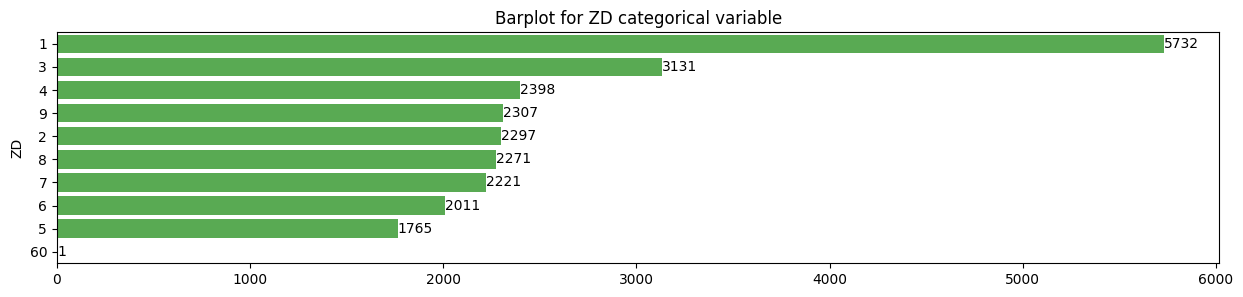

In [12]:
col ='ZD'
plt.figure(figsize=(15,3))
ax = sns.barplot(x=df[col].value_counts().values, y=df[col].value_counts().index,
             errorbar=None, order=df[col].value_counts().index, color='#4CB944')
ax.bar_label(ax.containers[0], fontsize=10)
plt.title(f"Barplot for {col} categorical variable")
plt.ylabel(f"{col}")

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55],
 [Text(0, 0, 'non alimentare'),
  Text(0, 1, 'alimentare'),
  Text(0, 2, 'Non Alimentare'),
  Text(0, 3, 'alimentare;non alimentare'),
  Text(0, 4, 'tabella speciale monopolio'),
  Text(0, 5, 'Alimentare'),
  Text(0, 6, 'tabella speciale farmacie'),
  Text(0, 7, 'Alimentare;Non Alimentare'),
  Text(0, 8, 'tabella speciale carburanti'),
  Text(0, 9, 'non alimentare;tabella speciale monopolio'),
  Text(0, 10, 'non alimentare;tabella speciale farmacie'),
  Text(0, 11, 'Tabella speciale Monopolio'),
  Text(0, 12, 'alimentare;tabella speciale monopolio'),
  Text(0, 13, 'non alimentare;tabella speciale carburanti'),
  Text(0, 14, 'alimentare;non alimentare;tabella specia

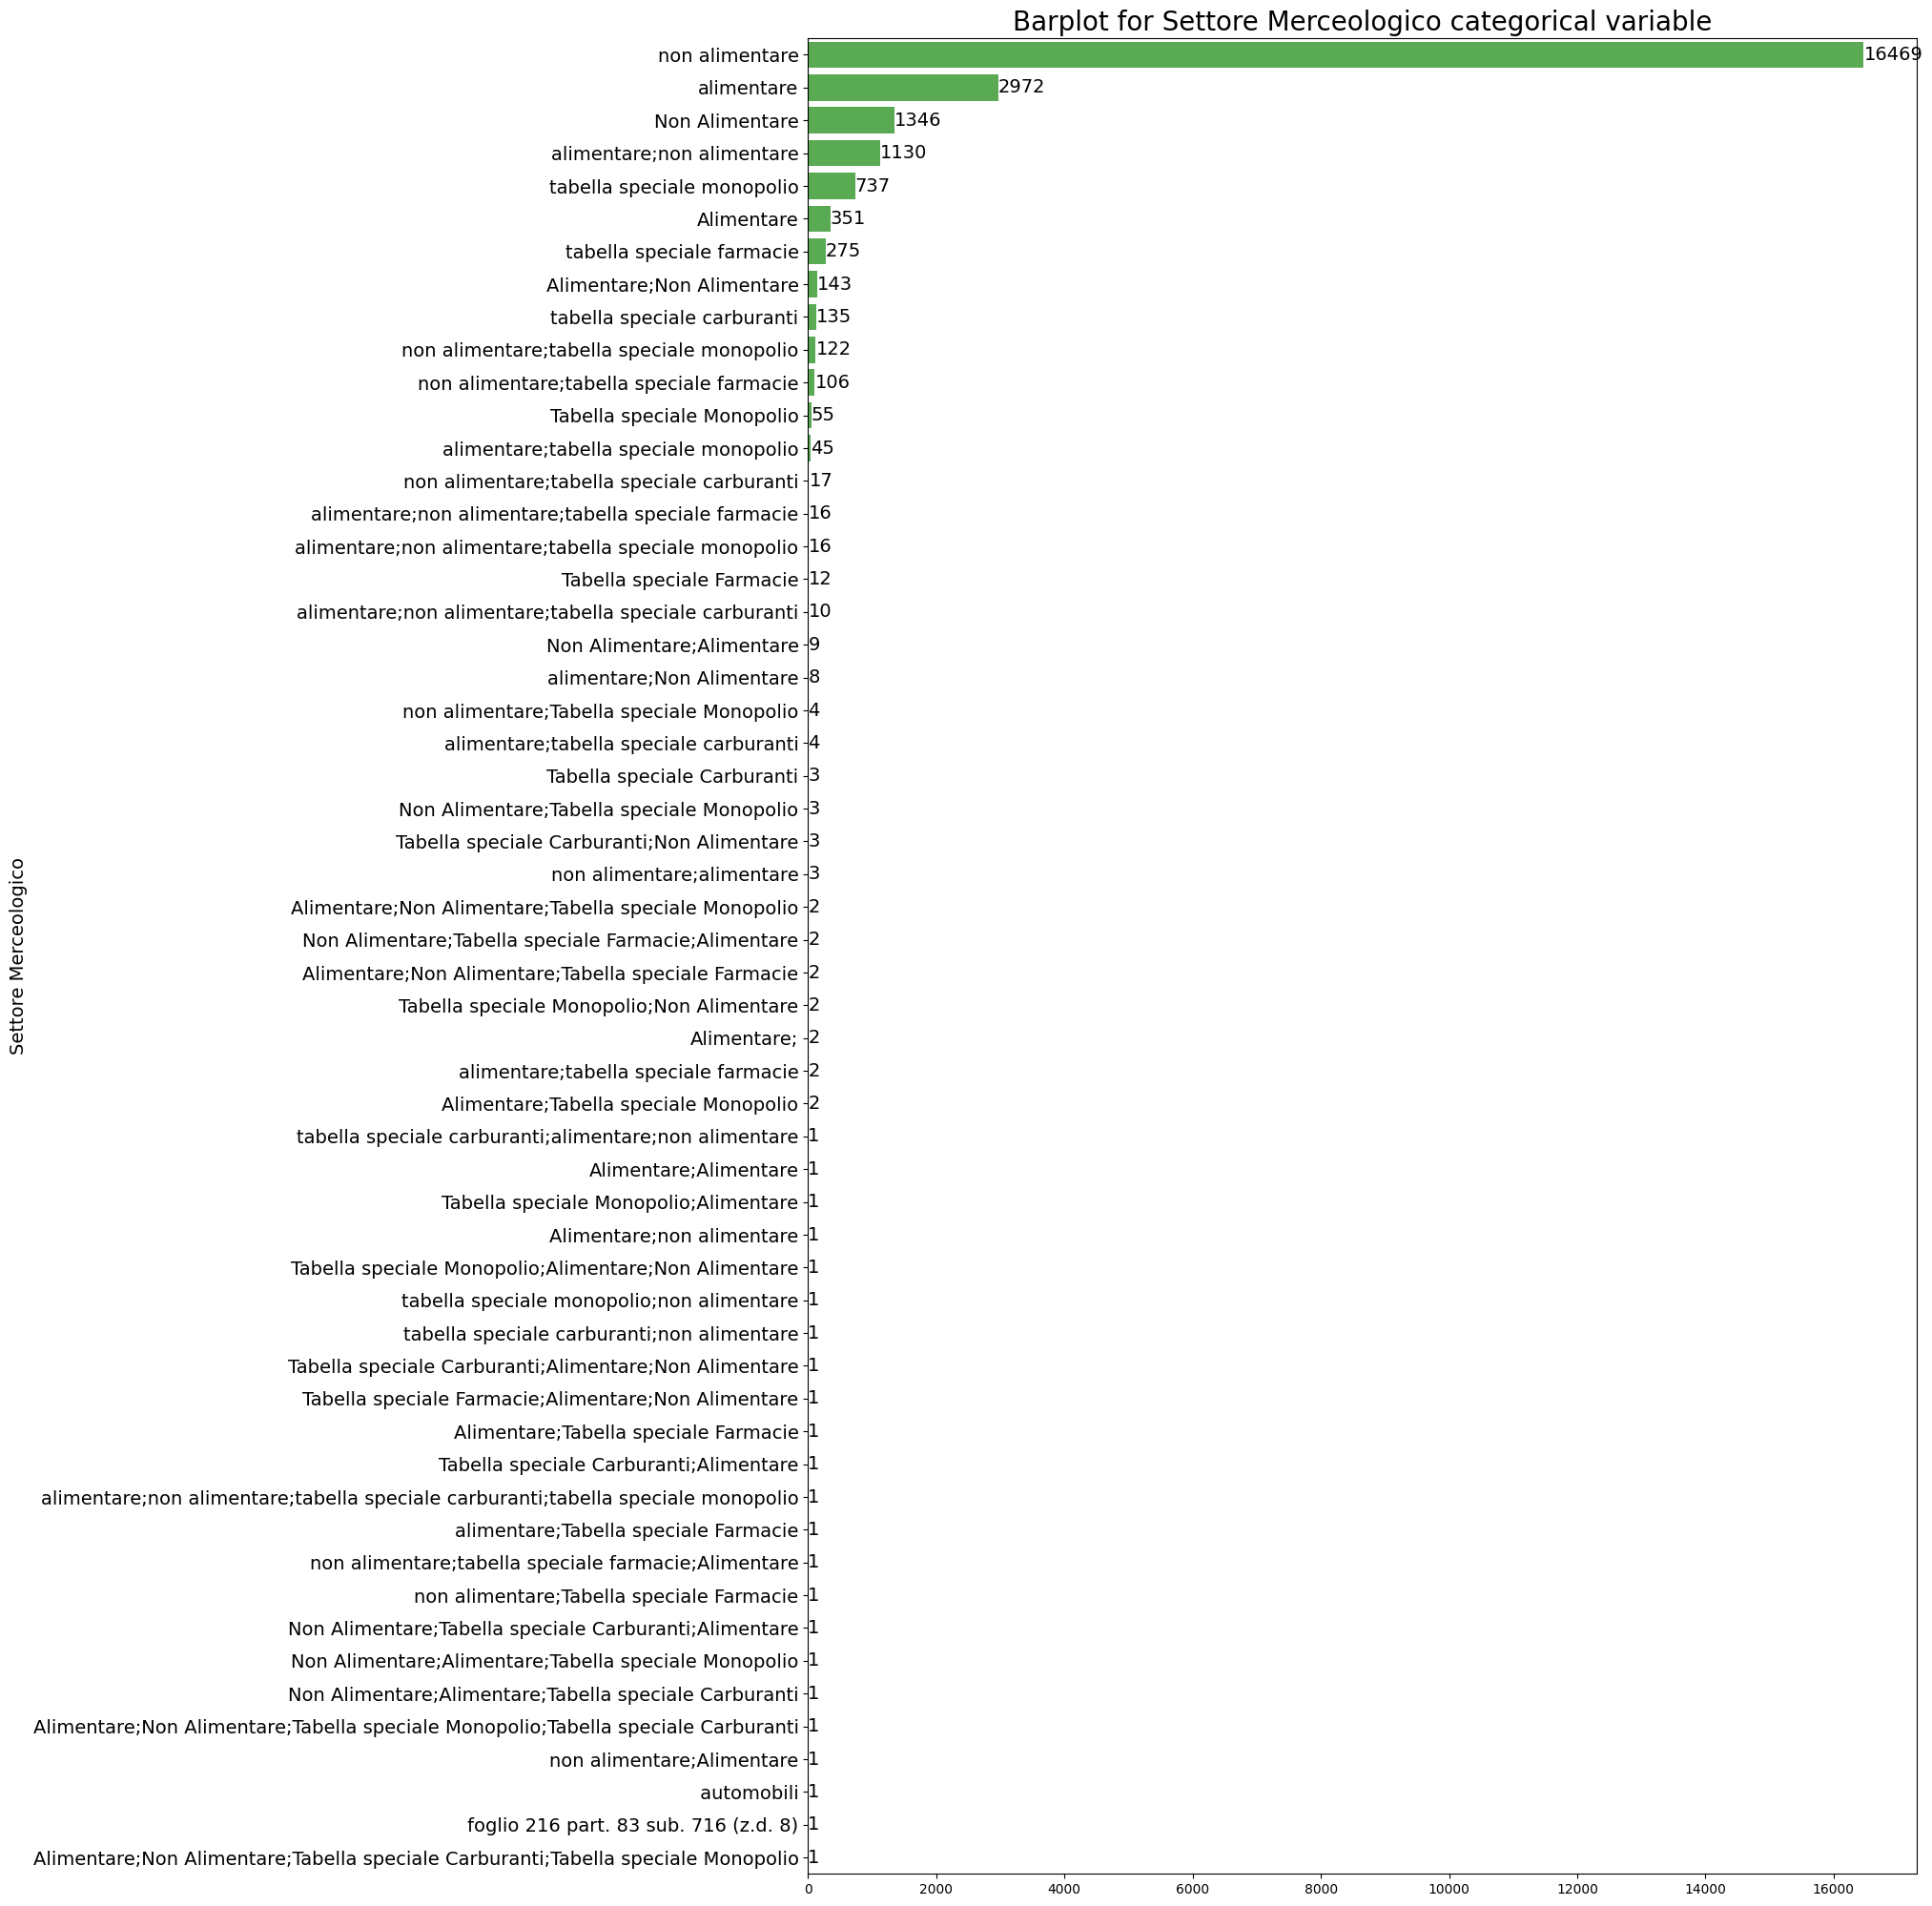

In [13]:
col ='Settore Merceologico'
dft = df[col].value_counts() 
dft = dft[dft.values>0]
plt.figure(figsize=(15,25))
ax = sns.barplot(x=dft.values, y=dft.index,
             errorbar=None, color='#4CB944')
ax.bar_label(ax.containers[0], fontsize=14)
plt.title(f"Barplot for {col} categorical variable", fontsize=20)
plt.ylabel(f"{col}", fontsize=14)
plt.yticks(fontsize=14)


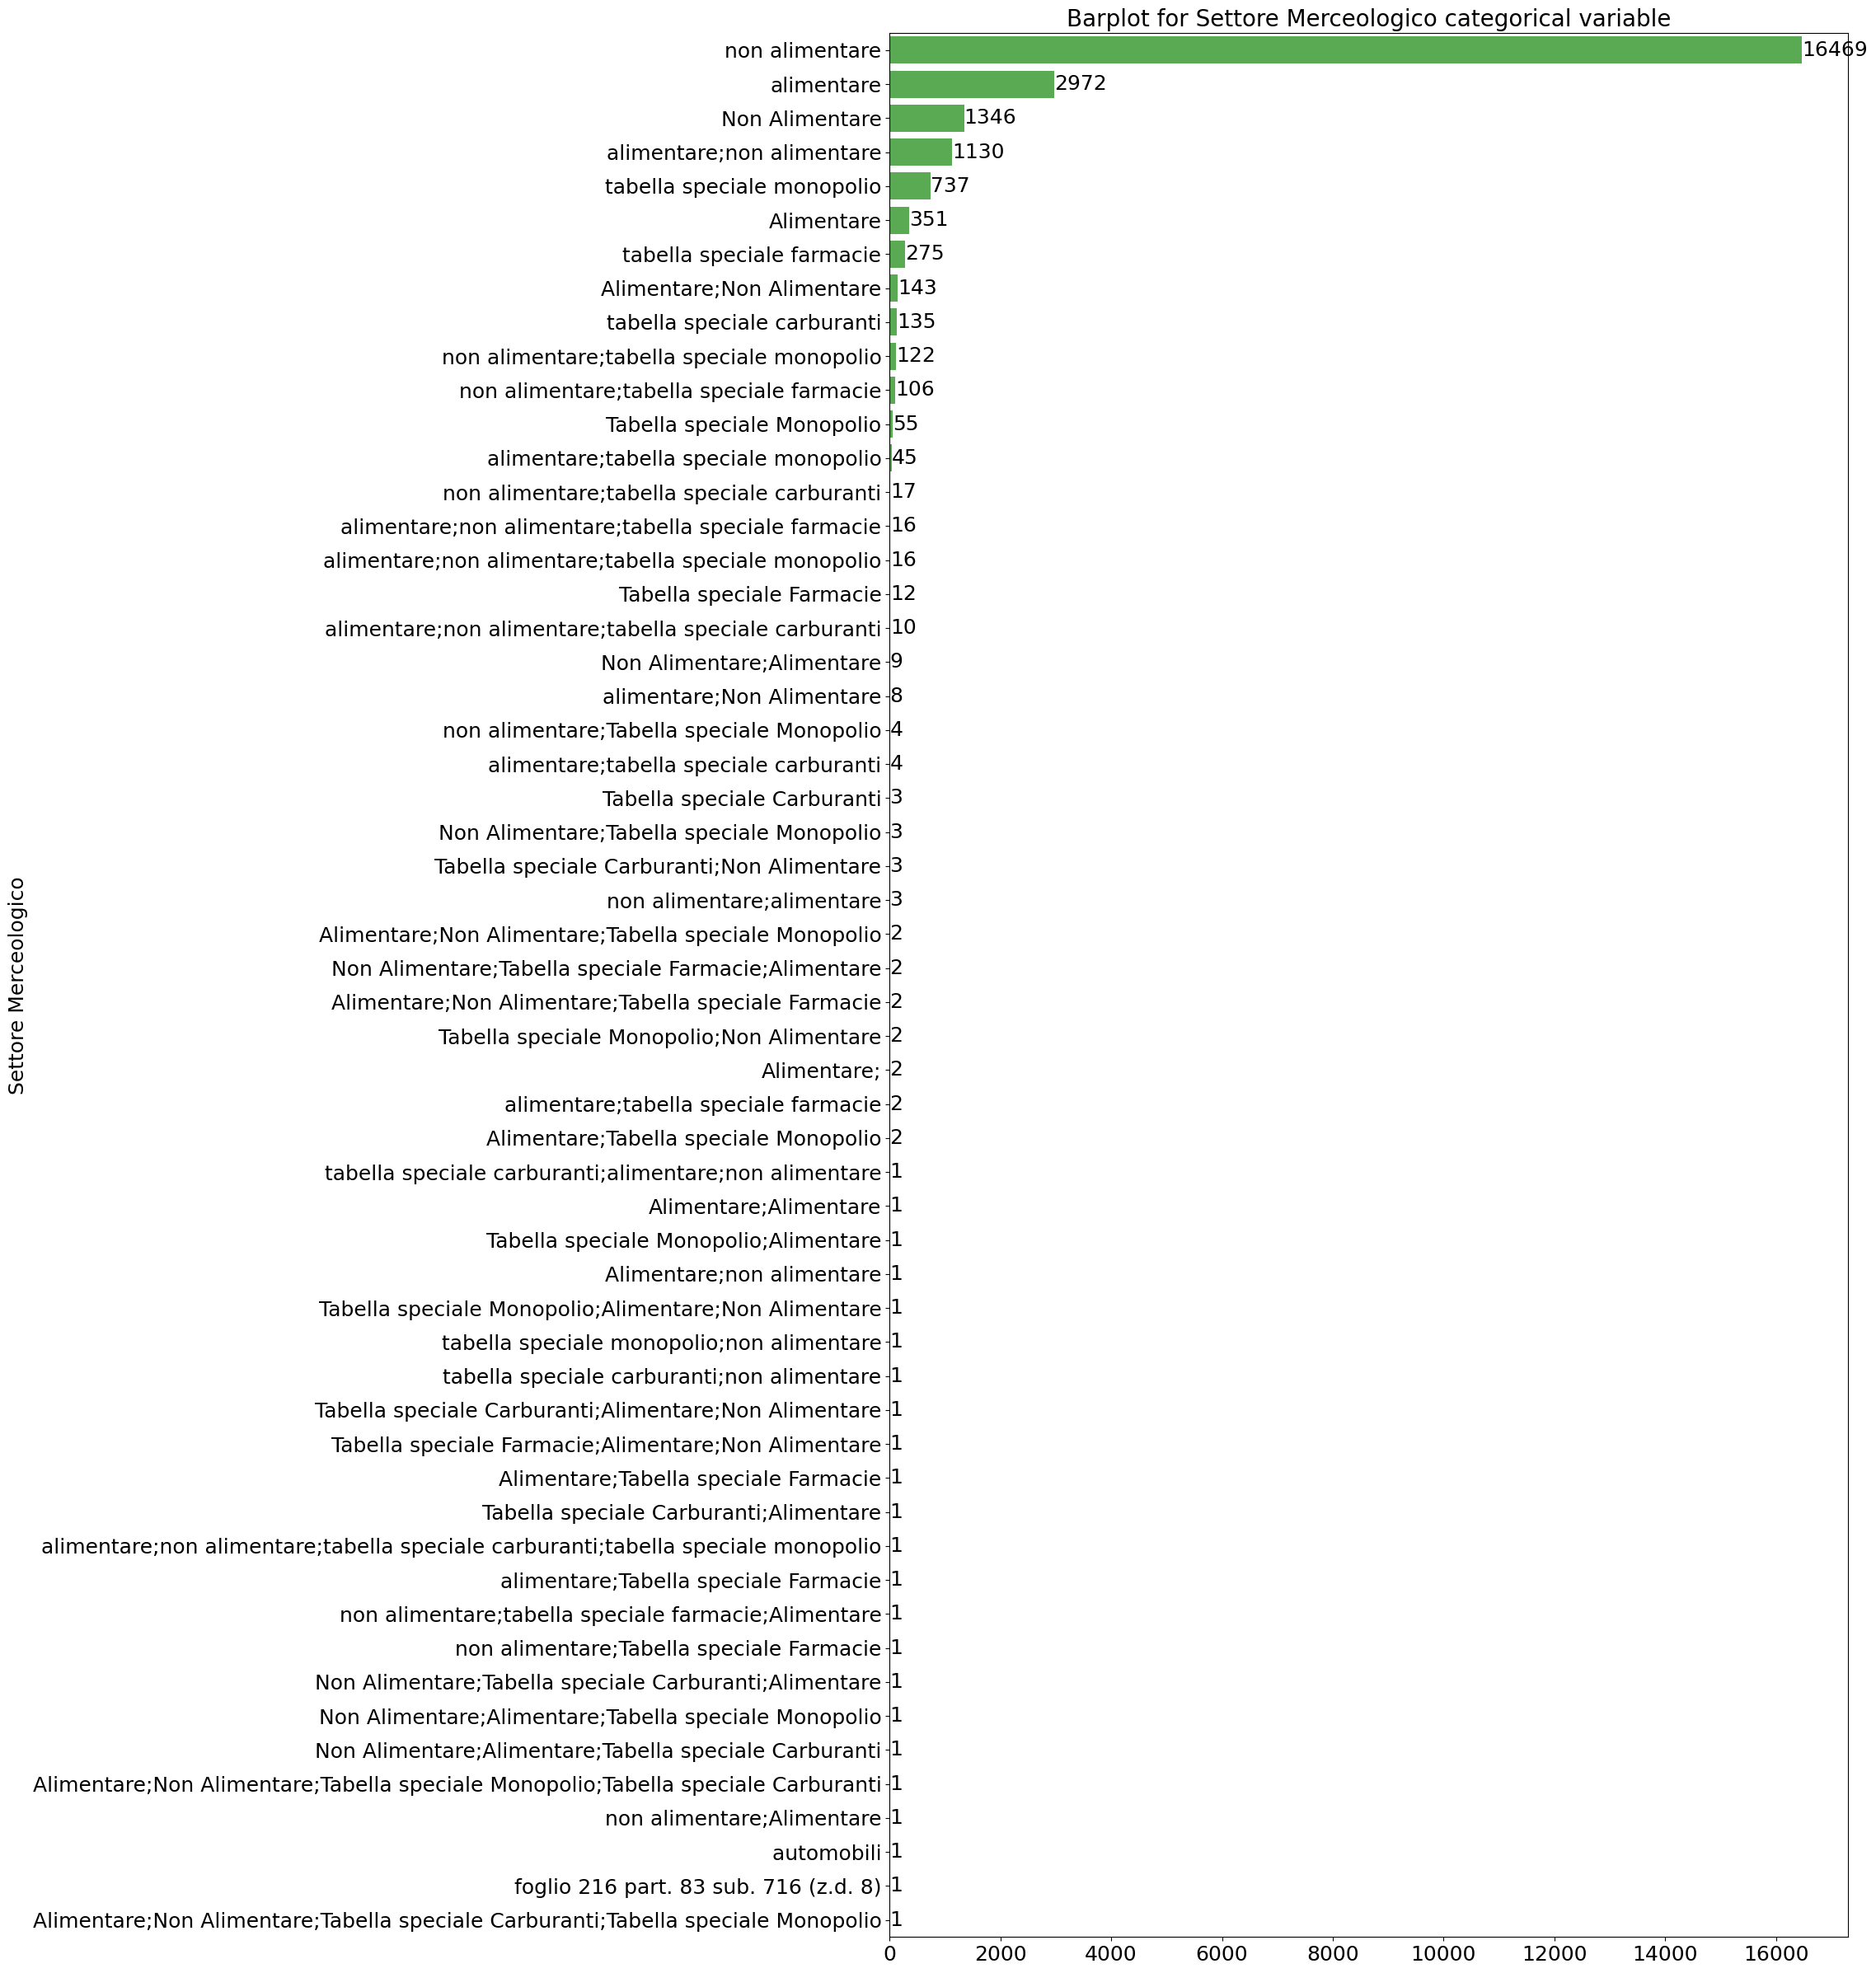

In [14]:
col ='Settore Merceologico'
plt.figure(figsize=(15,30))
ax = sns.barplot(x=df[col].value_counts().values, y=df[col].value_counts().index,
             errorbar=None, order=df[col].value_counts().index, color='#4CB944')
ax.bar_label(ax.containers[0], fontsize=18)
plt.title(f"Barplot for {col} categorical variable", fontsize=20)
plt.ylabel(f"{col}", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

Only values with more than 3 occurrences are shown for a better visualization

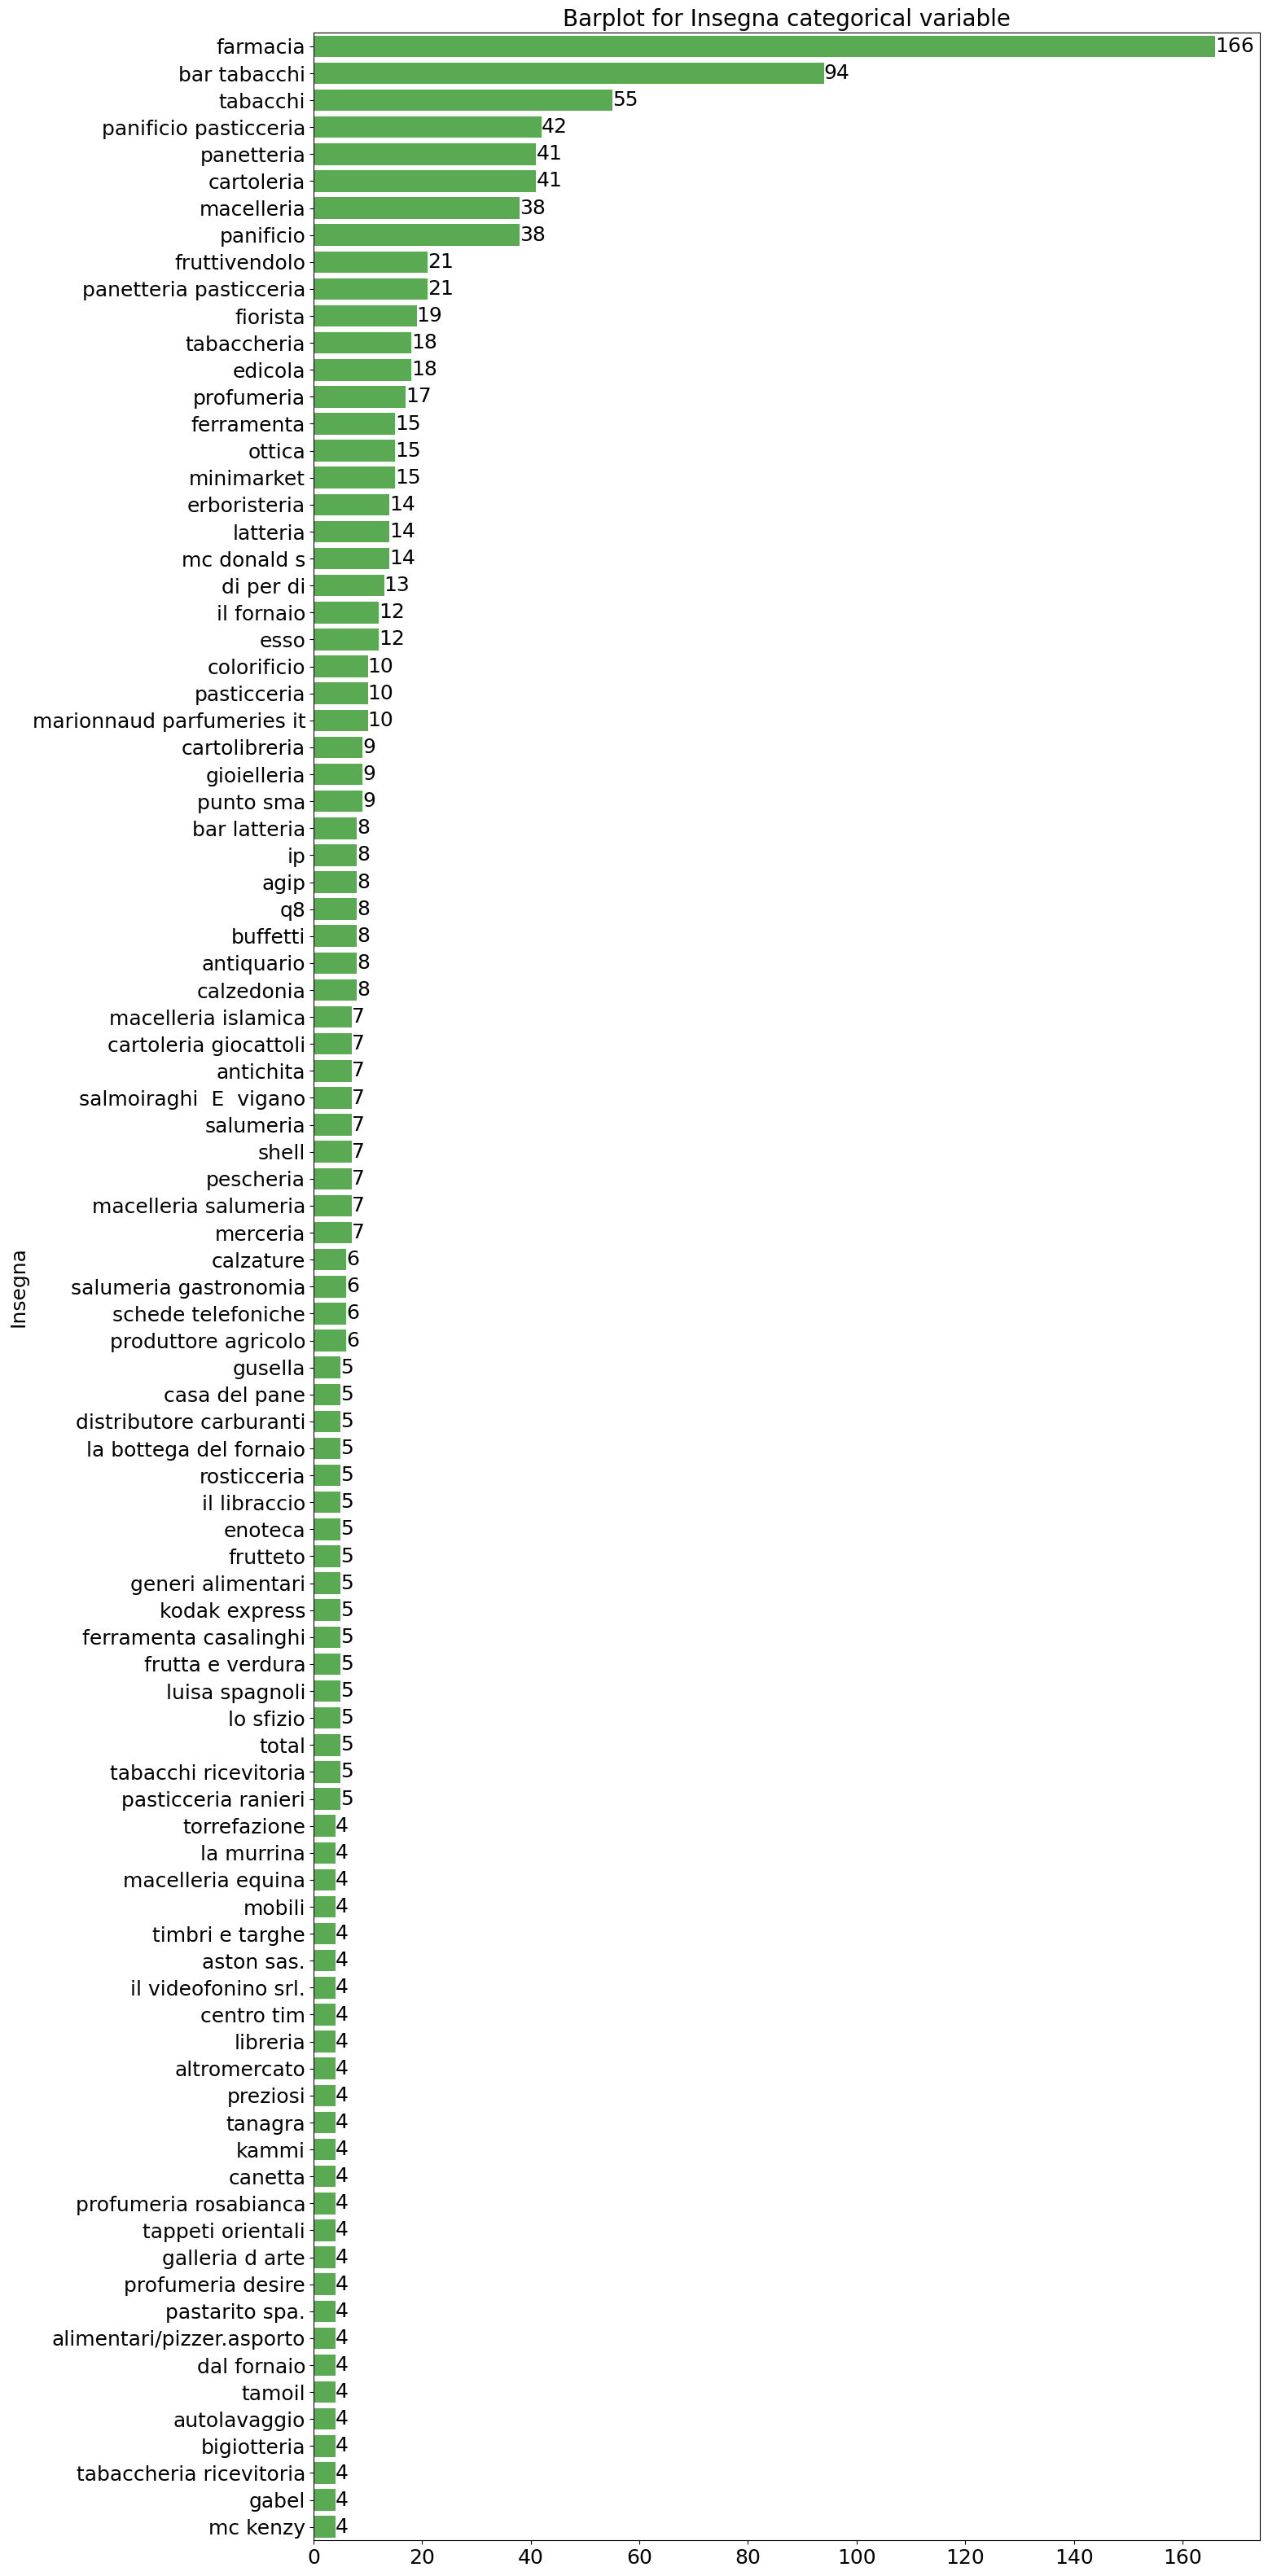

In [15]:
col ='Insegna'
# for visualization purposes
dft = df[col].value_counts() 
dft = dft[dft.values>3]
plt.figure(figsize=(15,40))
ax = sns.barplot(x=dft.values, y=dft.index,
             errorbar=None, color='#4CB944')
ax.bar_label(ax.containers[0], fontsize=18)
plt.title(f"Barplot for {col} categorical variable",fontsize=20)
plt.ylabel(f"{col}", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel(f"{col}");

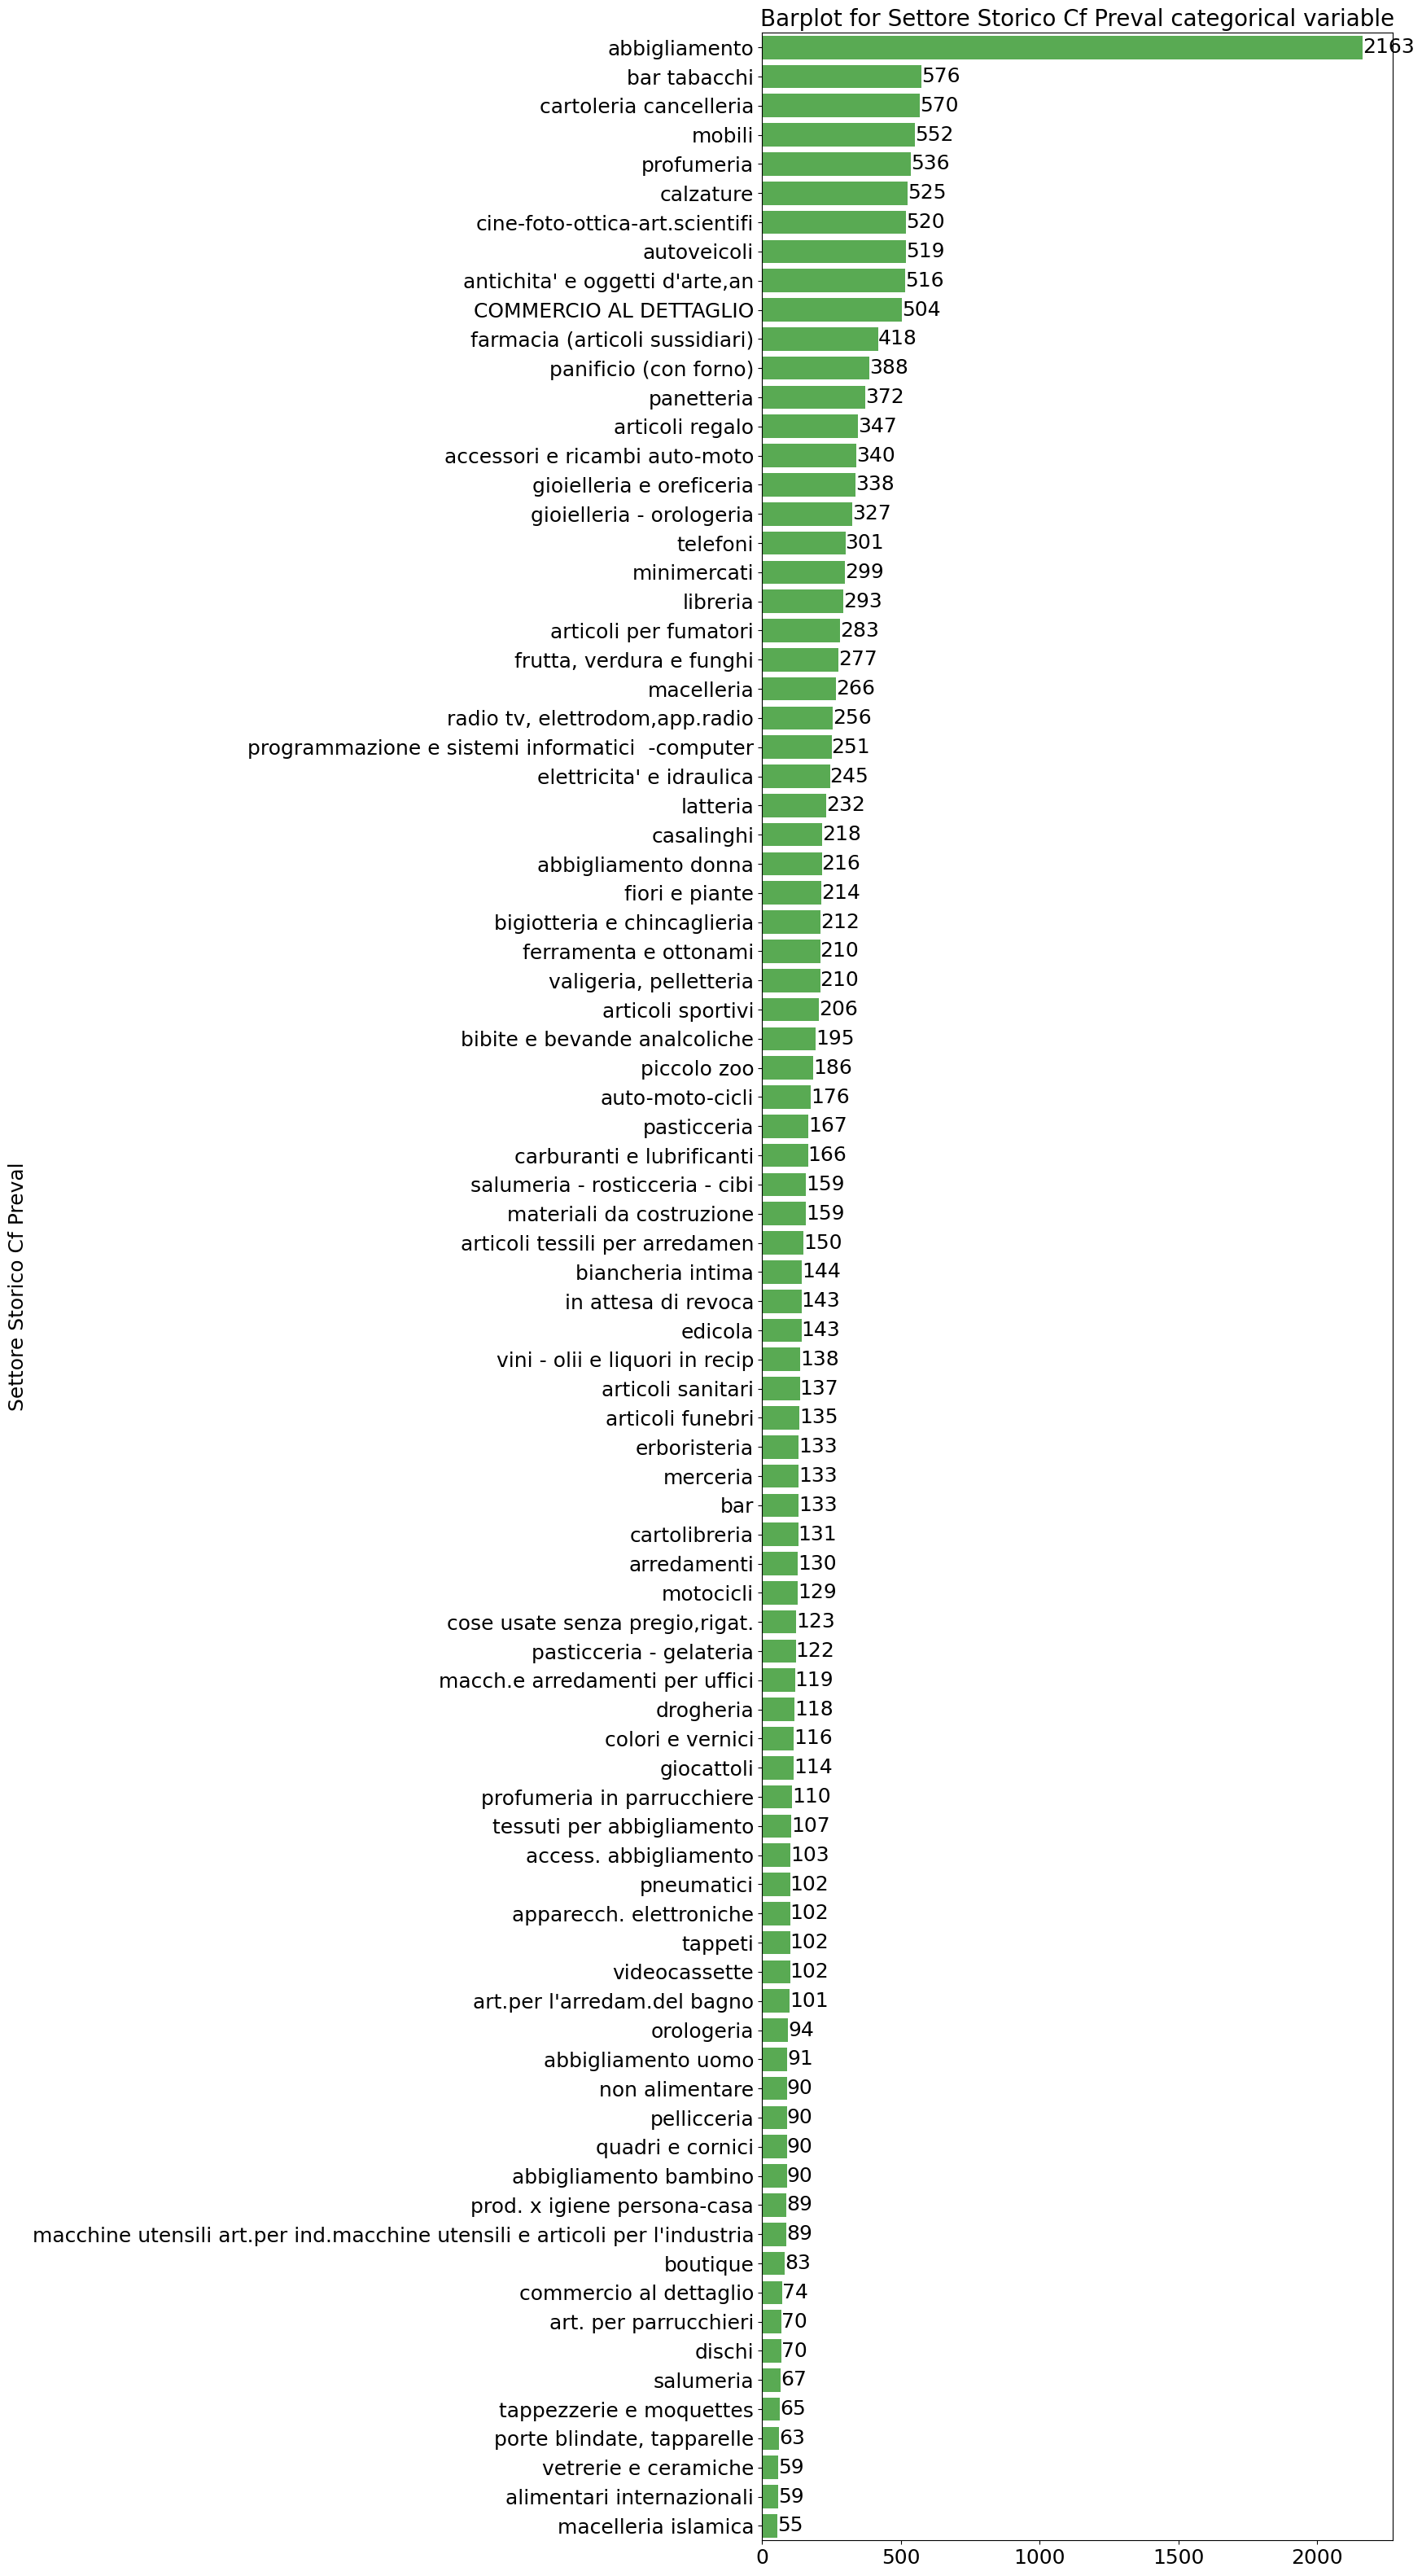

In [16]:
col ='Settore Storico Cf Preval'
# for visualization purposes
dft = df[col].value_counts() 
dft = dft[dft.values>50]
plt.figure(figsize=(10,40))
ax = sns.barplot(x=dft.values, y=dft.index,
             errorbar=None, color='#4CB944')
ax.bar_label(ax.containers[0], fontsize=18)
plt.title(f"Barplot for {col} categorical variable",fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel(f"{col}",fontsize=18);

Text(0, 0.5, 'Tipo via')

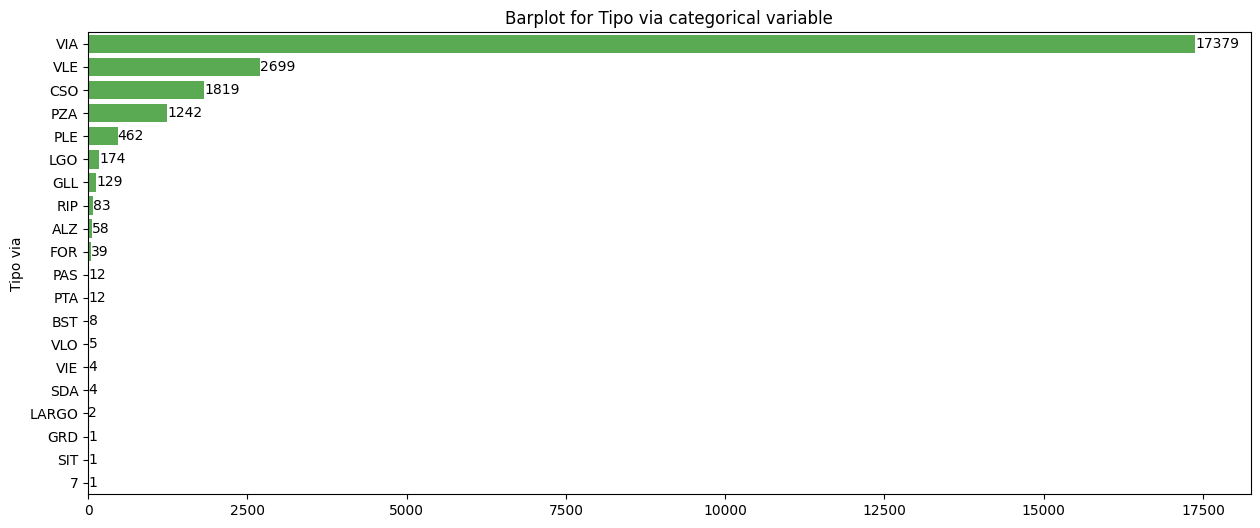

In [17]:
col ='Tipo via'
plt.figure(figsize=(15,6))
ax = sns.barplot(x=df[col].value_counts().values, y=df[col].value_counts().index,
             errorbar=None, order=df[col].value_counts().index, color='#4CB944')
ax.bar_label(ax.containers[0], fontsize=10)
plt.title(f"Barplot for {col} categorical variable")
plt.ylabel(f"{col}")

## 2.3. Dependency Discovery
[$\leftarrow$ Back to contents](#Contents)

### 2.3.1 Superfici columns
[$\leftarrow$ Back to contents](#Contents)

We first of all studied correlations between numerical variables. To do so we computed both Pearson and Spearman coefficients.

Pearson's correlation spots linear correlations in the data while Spearman's correlation spots monotonic relationships in the data. p-values are computed to assess the statistical significance of the correlations.  
* Significant strong positive Pearson's correlations (`corr > 0.5`, `p-value < 0.05`) were found between:  
    - `Superficie Vendita` and `Superficie Tabelle Speciali`  
    - `Superficie Altri Usi` and `Superficie Totale`   
* Significant strong positive Spearman's correlation (`corr > 0.5`, `p-value < 0.05`) were found between:  
    - `Superficie Vendita` and `Superficie Tabelle Speciali`  
    - `Superficie Vendita` and `Superficie Totale`  
    - `Superficie Altri Usi` and `Superficie Totale`

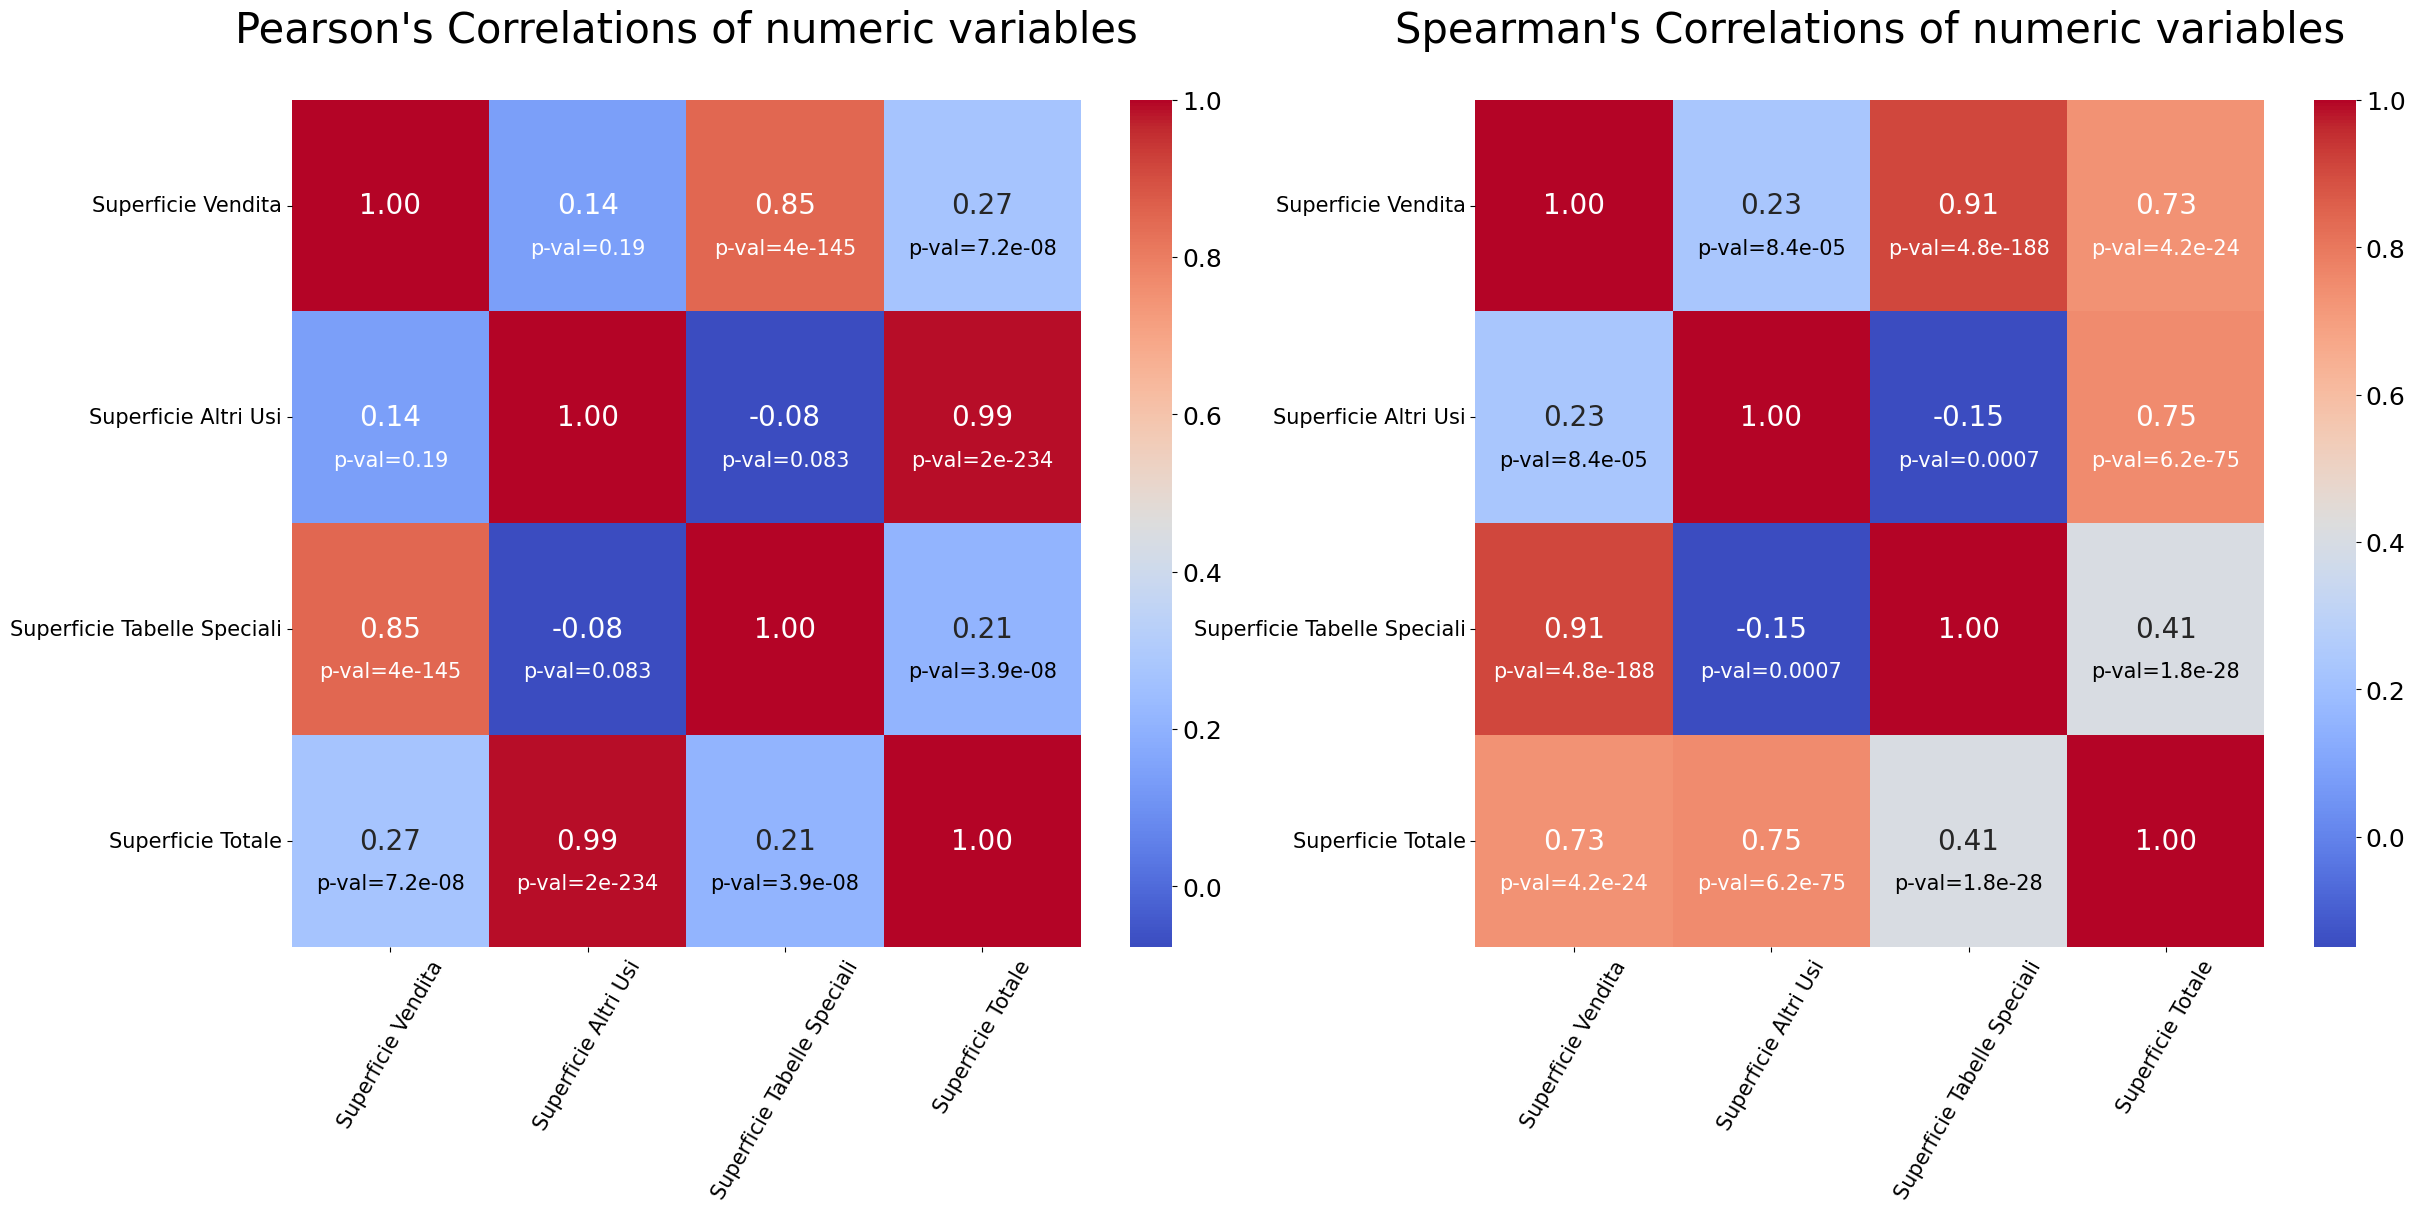

In [18]:
# Create plt figure
plt.figure(figsize=(28,11))

# Create dataframe with no nan to compute p-valeus of correlations
nnum = num.dropna()

# Create the heatmap for Pearson's correlations
corr_p = num.corr(method='pearson')

# Compute the p-values
p_values_p = pd.DataFrame(index=num.columns, columns=num.columns)
for c1 in num.columns:
    for c2 in num.columns:
        if c1 == c2:
            p_values_p.loc[c1,c2] = 0.0
        else:
            _, p_value = pearsonr(nnum[c1], nnum[c2])
            p_values_p.loc[c1, c2] = p_value

plt.subplot(1,2,1)
ax0 = sns.heatmap(corr_p, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 20})
# Normalize the data for color contrast
norm = Normalize(vmin=corr_p.min().min(), vmax=corr_p.max().max())
cmap = plt.cm.coolwarm  
for i in range(len(corr_p.columns)):
    for j in range(len(corr_p.columns)):
        if i != j: 
            color_value = norm(corr_p.iloc[i, j])
            color = cmap(color_value)

            # Decide font color based on cell background intensity
            text_color = 'white' if (color[0]*0.299 + color[1]*0.587 + color[2]*0.114) < 0.65 else 'black'
            plt.text(j + 0.5, i + 0.7, f"p-val={p_values_p.iloc[i, j]:.2g}", 
                     ha='center', va='center', fontsize=15, color=text_color)

cbar = ax0.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  
plt.title("Pearson's Correlations of numeric variables\n", fontsize=30)         
plt.xticks(fontsize=15, rotation=60)
plt.yticks(fontsize=15, rotation=0)


# Create the heatmap for Spearman's correlations
corr_s = num.corr(method='spearman')

# Compute the p-values
p_values_s = pd.DataFrame(index=num.columns, columns=num.columns)
nnum = num.dropna()
for c1 in num.columns:
    for c2 in num.columns:
        if c1 == c2:
            p_values_s.loc[c1,c2] = 0.0
        else:
            _, p_value = spearmanr(nnum[c1], nnum[c2])
            p_values_s.loc[c1, c2] = p_value

plt.subplot(1,2,2)
ax1 = sns.heatmap(corr_s, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 20})
# Normalize the data for color contrast
norm = Normalize(vmin=corr_s.min().min(), vmax=corr_s.max().max())
cmap = plt.cm.coolwarm  
for i in range(len(corr_s.columns)):
    for j in range(len(corr_s.columns)):
        if i != j: 
            color_value = norm(corr_s.iloc[i, j])
            color = cmap(color_value)

            # Decide font color based on cell background intensity
            text_color = 'white' if (color[0]*0.299 + color[1]*0.587 + color[2]*0.114) < 0.7 else 'black'
            plt.text(j + 0.5, i + 0.7, f"p-val={p_values_s.iloc[i, j]:.2g}", 
                     ha='center', va='center', fontsize=15, color=text_color)
            
cbar = ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)
plt.title("Spearman's Correlations of numeric variables\n", fontsize=30)         
plt.xticks(fontsize=15, rotation=60)
plt.yticks(fontsize=15, rotation=0);


Looking at the columns names, the sum of the first three should be the 4th column. The fact that Spearman spotted correlation between `Superficie Vendita` and `Superficie Totale`, and also between `Superficie Altri Usi` and `Superficie Totale` confirmed our intuition, however it was spotted also a correlation between `Superficie Vendita` and `Superficie Tabelle Speciali` which seems quite weird at first sight. We supposed that `Superficie Tabelle Speciali` could be possibly included into `Superficie Vendita`, but to better understand the relationships between the four columns, different sums of the first three are computed to discover the most likely formula used to compute Superficie Totale. 
* `Sup Tot1`: sum of the three columns
* `Sup Tot2`: sum of `Superficie Vendita` and `Superficie Altri Usi`, assuming that `Superficie Tabelle Speciali` is included in `Superficie Vendita`

In [19]:
dft = pd.DataFrame(index=df.index)
dft['Sup Tot1'] = df['Superficie Vendita'].add(df['Superficie Tabelle Speciali'], fill_value=0)
dft['Sup Tot1'] = dft['Sup Tot1'].add(df['Superficie Altri Usi'], fill_value=0)
dft['Sup Tot2'] = df['Superficie Vendita'].add(df['Superficie Altri Usi'], fill_value=0)
dft.head(5)

Sup Tot1  Sup Tot2
0       0.0       0.0
1      21.0      21.0
2       0.0       0.0
3     120.0     120.0
4       0.0       0.0

In [20]:
print(f"Number of rows having column Superficie Tabelle Speciali not NaN: {df[df['Superficie Tabelle Speciali'].notna()].shape[0]}")
print(f"Number of rows having column Superficie Tabelle Speciali consistent with Sup Tot1 {df[(df['Superficie Tabelle Speciali'].notna()) & (df['Superficie Totale'] == dft['Sup Tot1'])].shape[0]}")
print(f"Number of rows having column Superficie Tabelle Speciali consistent with Sup Tot2 {df[(df['Superficie Tabelle Speciali'].notna()) & (df['Superficie Totale'] == dft['Sup Tot2'])].shape[0]}")

Number of rows having column Superficie Tabelle Speciali not NaN: 1127
Number of rows having column Superficie Tabelle Speciali consistent with Sup Tot1 16
Number of rows having column Superficie Tabelle Speciali consistent with Sup Tot2 660


Now the consistency of the `Sup Tot1` and `Sup Tot2` is evaluated for rows having `Superficie Tabelle Speciali` not `NaN`. This aims to understand if Superficie Tabelle Speciali is included in Superficie Vendita or not. 

For rows with Superficie Tabelle Speciali not NaN
* `Sup Tot1` was consistent with Superficie Totale in only `16` rows
* `Sup Tot2` was consistent with Superficie Totale for `645` rows (more than half of the total)  

For this reason, `Superficie Tabelle Speciali` is assumed to be included in `Superficie Vendita`.

### 2.3.2 Ubicazione, Tipo via, Civico, ZD
[$\leftarrow$ Back to contents](#Contents)  
From a visual inspection of the dataset, the column `Ubicazione` seems to contain the information of the columns `Tipo via`, `Via`, `Civico`, `ZD`.

In [21]:
cnt = 0
for i, r in df.iterrows():
    ub = r['Ubicazione']
    tipo = r['Tipo via']
    via = r['Via']
    civ = r['Civico']
    zd = r['ZD']

    # check of Ubicazione contains other columns
    if isinstance(ub,str):
        if isinstance(tipo,str):
            if str(tipo) in ub:
                cnt = cnt + 0.25
        if isinstance(via,str):
            if str(via) in ub:
                cnt = cnt + 0.25
        if isinstance(civ,str):
            if (str(civ) in ub):
                cnt = cnt + 0.25
        if isinstance(zd,str):
            if (str(zd) in ub):
                cnt = cnt + 0.25

print(f"Percentage of rows satisfying inclusion dependency: {cnt/n_rows}")

Percentage of rows satisfying inclusion dependency: 0.9770570931388797


### 2.3.3 Association rules
[$\leftarrow$ Back to contents](#Contents)  
Other associations are spotted using `fpgrowth`.

In [22]:
def mine_association_rules(df,lhs,rhs,min_sup=0.5,min_conf=0.8,num_itemsets=2):

    """This function mines for association rules between arbitrary number of columns of a dataframe using fpgrowth algoithm to extract frequent itemsets."""
    
    #Put all items of each transactions into a list
    #df = df.dropna() # it makes everything explode apparently
    records = []
    for i in range(0,df.shape[0]):
        if type(lhs) == list:
            st1 = df.loc[i,lhs].str.cat(sep = ' ')
        else:
            st1 = str(df.loc[i,lhs])
        
        if type(rhs) == list:
            st2 = df.loc[i,rhs].str.cat(sep=' ')
        else:
            st2 = str(df.loc[i,rhs])

        records.append([(st1,0),(st2,1)])
    
    ### ASSOCIATION RULES MINING IN 3 STEPS ###

    # # 0 - generate an encoding of the dataset
    TE = TransactionEncoder()
    array = TE.fit(records).transform(records)
    array_df = pd.DataFrame(array,columns=TE.columns_)

    # 1 - generate the frequent itemset: set of transactions with support >= min_sup
    freq_itemset = fpgrowth(array_df, min_support=min_sup, use_colnames=True)
    freq_itemset['length'] = freq_itemset['itemsets'].apply(lambda x: len(x)) # additional column for length of itemset

    if not freq_itemset.empty:
        # 2 - generate rules: set of transactions having confidence >= min_conf
        rules = association_rules(freq_itemset, num_itemsets=num_itemsets, metric='confidence', min_threshold=min_conf)
        rules = rules[rules['lift']>1] # filter to keep only interesting rules

        # # clean up a bit the formats
        rules['antecedents'] = rules['antecedents'].apply(lambda x : list(x)[0])
        rules['consequents'] = rules['consequents'].apply(lambda x : list(x)[0])
        rules['antecedents'] = rules['antecedents'].apply(lambda x : tuple((str(lhs),x[0])) if x[1]==0 else tuple((str(rhs),x[0])))
        rules['consequents'] = rules['consequents'].apply(lambda x : tuple((str(lhs),x[0])) if x[1]==0 else tuple((str(rhs),x[0])))

        return pd.DataFrame([f"{x[0]} : {x[1]} => {y[0]} : {y[1]}" for x, y in rules[['antecedents','consequents']].values],columns=['rule'])
    else:
        return pd.DataFrame()



**Codice Via and ZD**

195 rules were found, indicating that each `Codice via` is associated with only one `ZD`. The same goes for the association between `Via` and `ZD`, in fact `Codice via` should be univocally associated to the `Via`. Consequeltly, the number of rules found for the two associations is approximately the same.

In [23]:
codice_zd_rules = mine_association_rules(df,lhs='Codice via',rhs='ZD',min_sup=0.001)
codice_zd_rules.value_counts()

rule                       
Codice via : 1 => ZD : 1       1
Codice via : 591 => ZD : 1     1
Codice via : 5164 => ZD : 1    1
Codice via : 5198 => ZD : 5    1
Codice via : 5200 => ZD : 5    1
                              ..
Codice via : 236 => ZD : 1     1
Codice via : 238 => ZD : 1     1
Codice via : 2390 => ZD : 2    1
Codice via : 2400 => ZD : 3    1
Codice via : 7478 => ZD : 8    1
Name: count, Length: 195, dtype: int64

**Via and ZD**

In [24]:
via_zd_rules = mine_association_rules(df,lhs='Via',rhs='ZD',min_sup=0.001)
via_zd_rules.value_counts()

rule                                            
Via : ABRUZZI => ZD : 3                             1
Via : PIERLUIGI GIOVANNI DA PALESTRINA => ZD : 3    1
Via : PISACANE CARLO => ZD : 3                      1
Via : PLINIO CAIO SECONDO => ZD : 3                 1
Via : POLIZIANO => ZD : 8                           1
                                                   ..
Via : GIAMBELLINO => ZD : 6                         1
Via : GIOIA MELCHIORRE => ZD : 2                    1
Via : GORIZIA => ZD : 6                             1
Via : GOVONE GIUSEPPE => ZD : 8                     1
Via : ZURETTI GIANFRANCO => ZD : 2                  1
Name: count, Length: 196, dtype: int64

**Insegna and Settore Storico Cf Preval**  

Most or the rules found are correlated with NaN values, especially for Insegna. This may indicate that shops associated with a particular Settore Storico don't have shop sign or it maybe it was not recorded.

In [25]:
sett_merc_sett_storico_rules = mine_association_rules(df,lhs='Insegna',rhs='Settore Storico Cf Preval',min_sup=0.001)
sett_merc_sett_storico_rules.value_counts()

rule                                                                                                                        
Insegna : bar tabacchi => Settore Storico Cf Preval : bar tabacchi                                                              1
Insegna : cartoleria => Settore Storico Cf Preval : cartoleria cancelleria                                                      1
Settore Storico Cf Preval : tabella speciale monopolio => Insegna : nan                                                         1
Settore Storico Cf Preval : quadri e cornici => Insegna : nan                                                                   1
Settore Storico Cf Preval : non alimentare => Insegna : nan                                                                     1
Settore Storico Cf Preval : nan => Insegna : nan                                                                                1
Settore Storico Cf Preval : macchine utensili art.per ind.macchine utensili e articoli per l'in

**Insegna and Settore Merceologico**

In [26]:
sett_merc_insegna_rules = mine_association_rules(df,lhs='Insegna',rhs='Settore Merceologico',min_sup=0.001)
sett_merc_insegna_rules.value_counts()

rule                                                                       
Insegna : bar tabacchi => Settore Merceologico : tabella speciale monopolio    1
Insegna : cartoleria => Settore Merceologico : non alimentare                  1
Insegna : farmacia => Settore Merceologico : tabella speciale farmacie         1
Insegna : macelleria => Settore Merceologico : alimentare                      1
Insegna : panetteria => Settore Merceologico : alimentare                      1
Insegna : panificio => Settore Merceologico : alimentare                       1
Insegna : panificio pasticceria => Settore Merceologico : alimentare           1
Insegna : tabacchi => Settore Merceologico : tabella speciale monopolio        1
Settore Merceologico : Alimentare => Insegna : nan                             1
Settore Merceologico : Alimentare;Non Alimentare => Insegna : nan              1
Settore Merceologico : Non Alimentare => Insegna : nan                         1
Settore Merceologico : nan => Ins

**Settore Merceologico and Settore Storico Cf Preval**

24 rules are found with a minimum support of 0.01 (10 times higher than the one used for spotting rules in the previous cases). This is an interesting result, especially considering that no data wrangling was applied.

In [27]:
sett_merc_sett_storico_rules = mine_association_rules(df,lhs='Settore Merceologico',rhs='Settore Storico Cf Preval',min_sup=0.01)
sett_merc_sett_storico_rules.value_counts()

rule                                                                                                                
Settore Merceologico : tabella speciale farmacie => Settore Storico Cf Preval : farmacia (articoli sussidiari)          1
Settore Storico Cf Preval : abbigliamento => Settore Merceologico : non alimentare                                      1
Settore Storico Cf Preval : radio tv, elettrodom,app.radio => Settore Merceologico : non alimentare                     1
Settore Storico Cf Preval : programmazione e sistemi informatici  -computer => Settore Merceologico : non alimentare    1
Settore Storico Cf Preval : profumeria => Settore Merceologico : non alimentare                                         1
Settore Storico Cf Preval : panificio (con forno) => Settore Merceologico : alimentare                                  1
Settore Storico Cf Preval : panetteria => Settore Merceologico : alimentare                                             1
Settore Storico Cf Preval : m

In [28]:
len(sett_merc_sett_storico_rules)

22

# 3. DQ assesment
[$\leftarrow$ Back to contents](#Contents)

The 4 main dimensions to evaluate are:
- completeness
- accuracy (can't evaluate since there's no ground truth)
- timeliness
- consistency

## 3.1. Cardinalities
[$\leftarrow$ Back to contents](#Contents)

In [29]:
dq_assesment_sc = pd.DataFrame(columns=df.columns,index=['Uniqueness','Distinctness','Constancy'])

for col in df.columns:
    uniqueness = sc_analysis.loc['Cardinality',col]/n_rows
    distinctness = sc_analysis.loc['Cardinality',col]/sc_analysis.loc['Actual',col]
    mode = df[col].mode()[0]
    constancy = df[col].value_counts()[mode] / n_rows

    dq_assesment_sc.loc['Uniqueness', col] = uniqueness
    dq_assesment_sc.loc['Distinctness', col] = distinctness
    dq_assesment_sc.loc['Constancy', col] = constancy
    
dq_assesment_sc


Settore Merceologico   Insegna Ubicazione  Tipo via       Via  \
Uniqueness                0.00232  0.231314   0.700489  0.000829  0.096578   
Distinctness              0.00233  0.798827   0.700518  0.000829  0.096582   
Constancy                0.682342  0.006878   0.000953  0.720045   0.01214   

                Civico Codice via        ZD Settore Storico Cf Preval  \
Uniqueness    0.015993   0.097282  0.000414                   0.09231   
Distinctness  0.016435    0.09729  0.000414                  0.092437   
Constancy     0.062314    0.01214  0.237488                  0.089617   

             Superficie Vendita Superficie Altri Usi  \
Uniqueness             0.010358             0.018147   
Distinctness           0.010371             0.048462   
Constancy              0.051583             0.024196   

             Superficie Tabelle Speciali Superficie Totale  
Uniqueness                      0.004848          0.026599  
Distinctness                    0.103815          0.026639  
Constancy                       0.004267          0.042551

## 3.2 Completeness
[$\leftarrow$ Back to contents](#Contents)  

In [30]:
completeness = df.notnull().sum().sum()/(n_rows*n_cols)
print(f"COMPLETENESS: {completeness}")

COMPLETENESS: 0.8211544835674766


## 3.3 Consistency
[$\leftarrow$ Back to contents](#Contents)  

To evaluate dataset consistency, both the dependencies that were spotted visually and the dependencies analyzed by association rules are checked for each row in the dataset. A dataset containing rows with inconsistencies is saved to be studied later, after data wrangling. A column named `Reason` is added to the `df_inconsistencies` to keep trace of the checks that failed during consistency assessment.

In [31]:
consistency_sum = 0
for i, r in df.iterrows():
    ub = r['Ubicazione']
    tipo = r['Tipo via']
    via = r['Via']
    civ = r['Civico']
    codvia = r['Codice via']
    zd = r['ZD']
    reason = ''

    # check of Ubicazione contains other columns
    if isinstance(ub,str):
        if isinstance(tipo,str):
            if str(tipo) in ub:
                consistency_sum = consistency_sum + 0.125
        if isinstance(via,str):
            if str(via) in ub:
                consistency_sum = consistency_sum + 0.125
        if isinstance(civ,str):
            if (str(civ) in ub):
                consistency_sum = consistency_sum + 0.125
        if isinstance(zd,str):
            if (str(zd) in ub):
                consistency_sum = consistency_sum + 0.125

    # Z.D. has to be a zone number
    if zd in {'1','2','3','4','5','6','7','8','9'}:
        consistency_sum = consistency_sum + 0.125

    # check of rule: Codice via => ZD
    rule_values = codice_zd_rules['rule'].str.extract(r'[A-Za-z]+\s\:\s(.*)\s\=\>\s[A-Za-z]+\s\:\s(.*)',expand=True)
    value = rule_values[rule_values[0]==zd].reset_index()
    if not value.empty:
        if zd == value[1][0]:
            consistency_sum = consistency_sum + 0.125

    sv = r['Superficie Vendita']
    sa = r['Superficie Altri Usi']
    ss = r['Superficie Tabelle Speciali']
    st = r['Superficie Totale']
    # check sum of coherency of superificie filds
    if (sv+sa) == st:
        consistency_sum = consistency_sum + 0.125
    
    # check of inclusion of Superficie Tabelle Speciali in Superficie Vendita
    if (sv+ss) > st-sa:
        consistency_sum = consistency_sum + 0.125 

In [32]:
consistency = consistency_sum/n_rows
print(f"CONSISTENCY: {consistency}")

CONSISTENCY: 0.6912910175671196


## 3.4 TIMELINESS

In [33]:
# ABBIAMO t_expire = "31/12/2012"
# currency = now() - "31/12/2011" # t_read - t_last_update
# volatility = ??????? COME DOVREMMO TROVARLA?? :(( # frequency of update of the datum
# timeliness = max(0,1-currency/volatility) 

# 4. Data Wrangling
[$\leftarrow$ Back to contents](#Contents)

In [34]:
# Create a copy of the original df
df_original = df.copy()

## 4.1. Settore Merceologico
[$\leftarrow$ Back to contents](#Contents)

1. All values of the column are put in lower case
2. Some entries have multiple values in the column `Settore Merceologico` separated with `;`. Therefore, the column is split into `Settore Merceologico Primario` and `Settore Merceologico Secondario` (which may include multiple values).
3. For `Settore Merceologico secondario`, the separator for multiple values is changed from `;` to `, `
4. The column `Settore Merceologico` is dropped and the two new columns are moved to position `0` and `1`.

In [35]:
# Put all values in lower case
df['Settore Merceologico'] = df['Settore Merceologico'].str.lower()

# Add additional columns for Settore Merceologico Principale and Settore Merceologico Secondario

df[['Settore Merceologico Principale', 'Settore Merceologico Secondario']] = (
    df['Settore Merceologico']
    .str.split(';', n=1, expand=True)
    .apply(lambda x: [x[0], x[1] if len(x) > 1 else np.nan], axis=1, result_type='expand')
)
df['Settore Merceologico Secondario'] = df['Settore Merceologico Secondario'].astype(object).replace({None: np.nan})
df['Settore Merceologico Secondario'] = df['Settore Merceologico Secondario'].str.replace(';',', ')
df[df['Settore Merceologico Secondario']==''] = np.nan


# Drop the origilal column Settore Merceologico
df = df.drop(columns='Settore Merceologico')

# Insert the two new columns in position 0 and 1
df.insert(0,'Settore Merceologico Principale', df.pop('Settore Merceologico Principale'))
df.insert(1, 'Settore Merceologico Secondario', df.pop('Settore Merceologico Secondario'))
df.iloc[5000:5010]


Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
5000                  non alimentare                             NaN     NaN   
5001                  non alimentare                             NaN     NaN   
5002                  non alimentare                             NaN     NaN   
5003                  non alimentare                             NaN     NaN   
5004                  non alimentare                             NaN     NaN   
5005                  non alimentare                             NaN     NaN   
5006                  non alimentare                             NaN     NaN   
5007                  non alimentare                             NaN     NaN   
5008                  non alimentare                             NaN     NaN   
5009                  non alimentare                             NaN     NaN   

                                             Ubicazione Tipo via  \
5000    CSO DI PORTA NUOVA 1ø piano num.046/b; (z.d. 1)      CSO   
5001  CSO DI PORTA NUOVA N. 19 ; isolato:009; access...      CSO   
5002  CSO DI PORTA NUOVA N. 32 ; isolato:088; access...      CSO   
5003  CSO DI PORTA NUOVA N. 32 ; isolato:088; access...      CSO   
5004                  CSO DI PORTA NUOVA N. 34 (z.d. 1)      CSO   
5005                  CSO DI PORTA NUOVA N. 34 (z.d. 1)      CSO   
5006  CSO DI PORTA NUOVA N. 38 ;cso di porta romana ...      CSO   
5007  CSO DI PORTA NUOVA N. 38 ; isolato:088; access...      CSO   
5008                  CSO DI PORTA NUOVA N. 38 (z.d. 1)      CSO   
5009  CSO DI PORTA NUOVA N. 46 ; isolato:010; access...      CSO   

                 Via Civico Codice via ZD       Settore Storico Cf Preval  \
5000  DI PORTA NUOVA    NaN       1044  1  antichita' e oggetti d'arte,an   
5001  DI PORTA NUOVA     19       1044  1               articoli sanitari   
5002  DI PORTA NUOVA     32       1044  1                articoli funebri   
5003  DI PORTA NUOVA     32       1044  1                     coltelleria   
5004  DI PORTA NUOVA     34       1044  1                   abbigliamento   
5005  DI PORTA NUOVA     34       1044  1                     autovetture   
5006  DI PORTA NUOVA     38       1044  1                   abbigliamento   
5007  DI PORTA NUOVA     38       1044  1                 galleria d'arte   
5008  DI PORTA NUOVA     38       1044  1          vendita oggetti d'arte   
5009  DI PORTA NUOVA     46       1044  1                articoli funebri   

      Superficie Vendita  Superficie Altri Usi  Superficie Tabelle Speciali  \
5000               200.0                  40.0                          NaN   
5001                20.0                 506.0                          NaN   
5002                32.0                   NaN                          NaN   
5003                22.0                   6.0                          NaN   
5004               127.0                   NaN                          NaN   
5005                36.0                   NaN                          NaN   
5006                60.0                  20.0                          NaN   
5007                70.0                   NaN                          NaN   
5008               150.0                  60.0                          NaN   
5009                37.0                   NaN                          NaN   

      Superficie Totale  
5000              240.0  
5001              526.0  
5002               32.0  
5003               28.0  
5004              329.0  
5005               74.0  
5006               80.0  
5007               70.0  
5008              210.0  
5009               37.0

## 4.2. Insegna
[$\leftarrow$ Back to contents](#Contents)

1. Values were put to lower case
2. Everything different from alphanumeric characters or `.` was replaced with ` `.

In [36]:
# Put all values to loewer case
df['Insegna'] = df['Insegna'].str.lower()

# Replace not alphanumeric characters(or stop) with spaces.
df['Insegna'] = df['Insegna'].str.replace('[^(\.\w)]',' ',regex=True)

df.iloc[100:105]

<>:5: DeprecationWarning: invalid escape sequence '\.'
<>:5: DeprecationWarning: invalid escape sequence '\.'
C:\Users\sarar\AppData\Local\Temp\ipykernel_37460\3033637803.py:5: DeprecationWarning: invalid escape sequence '\.'
  df['Insegna'] = df['Insegna'].str.replace('[^(\.\w)]',' ',regex=True)


Settore Merceologico Principale Settore Merceologico Secondario  \
100                             NaN                             NaN   
101                             NaN                             NaN   
102                             NaN                             NaN   
103                             NaN                             NaN   
104                             NaN                             NaN   

                   Insegna                                         Ubicazione  \
100    produttore agricolo  VIA RIPAMONTI GIUSEPPE N. 549 7.4.08 tras.set....   
101    produttore agricolo  VIA SELVANESCO N. 25 7.4.08 tras.set. agricolt...   
102    produttore agricolo  VLE TROYA CARLO N. 23 7.4.08 tras.sett.agricol...   
103  specialita  regionali  VIA SAMMARTINI GIOVANNI BATTISTA N. 69 ; isola...   
104                tessuti  VIA MUZIO SCEVOLA N. 4 ; isolato:115; accesso:...   

    Tipo via                           Via Civico Codice via ZD  \
100      VIA            RIPAMONTI GIUSEPPE    549       4066  5   
101      VIA                    SELVANESCO     25       4350  5   
102      VLE                   TROYA CARLO     23       5140  6   
103      VIA  SAMMARTINI GIOVANNI BATTISTA     69       1202  2   
104      VIA                 MUZIO SCEVOLA      4       2663  3   

     Settore Storico Cf Preval  Superficie Vendita  Superficie Altri Usi  \
100             fiori e piante                 0.0                   NaN   
101   frutta, verdura e funghi                 0.0                   NaN   
102   frutta, verdura e funghi                 0.0                   NaN   
103      panificio (con forno)                18.0                   NaN   
104  tessuti per abbigliamento                18.0                   NaN   

     Superficie Tabelle Speciali  Superficie Totale  
100                          NaN                0.0  
101                          NaN                0.0  
102                          NaN                0.0  
103                          NaN               18.0  
104                          NaN               18.0

## 4.3. Ubicazione
[$\leftarrow$ Back to contents](#Contents)

From a visual inspection it was noted that the column Ubicazione contained some information already present in other columns and in some cases some additional information. Information is usually separated by `;`. This column may be useful for handling missing values by performing data imputation. For this reason, the information in this column is saved in a temporary `DataFrame` split into:
* `Tipo via tmp`
* `Via tmp`
* `Civico tmp`
* `ZD tmp ` 

Of a note, two columns not present in the original `DataFrame` emerged:
* `Accesso`
* `Isolato`
* `Website`

Additional information was put into the column `Altre info`.  
The columns of the temporary DataFrame are concatenated to the complete `DataFrame` next to the column `ZD`. In the end, the column Ubicazione is dropped from the complete `DataFrame`.

In [37]:
# Create the temporary DataFrame
dft = pd.DataFrame()

# Extract Tipo via
dft['Tipo via tmp'] = df['Ubicazione'].str.extract('([A-Z]+ )',expand=True)
dft['Tipo via tmp'] = dft['Tipo via tmp'].str.strip() # Remove spaces at the begin and end of the string

# Extract Via
dft['Via tmp'] = df['Ubicazione'].str.extract(r'(?:^[A-Z]+ )([A-Z\.\'\s]+[A-MO-Z\']+[\.N]*)(?= N\.|num\.|civ\.|civico|\s?[a-z]|\s?\W\d)', expand=True)
dft['Via tmp'] = dft['Via tmp'].str.strip() # Remove spaces at the begin and end of the string

# Extract Civico
dft['Civico tmp'] = df['Ubicazione'].str.extract(r'(?:N\.|num\.|civ\.|civico)(\s?[\w/\\]+)', expand=True)
dft['Civico tmp'] = dft['Civico tmp'].str.strip() # Remove spaces at the begin and end of the string
dft['Civico tmp'] = dft['Civico tmp'].str.upper() # Put all characters to uppercase
dft['Civico tmp'] = dft['Civico tmp'].replace(r'^0+', '', regex=True) # Remove all the zeros at the beginning of the string
dft['Civico tmp'] = dft['Civico tmp'].str.replace(r'(\d)([a-zA-Z])', r'\1/\2', regex=True) # Add a / before letters to have uniform strings
dft.loc[dft['Civico tmp'] == '','Civico tmp'] = np.nan # If the string is empty, replace with NaN

# Extract ZD
dft['ZD tmp'] = df['Ubicazione'].str.extract('\(z.d. (\d)\)',expand=True)
dft['ZD tmp'] = dft['ZD tmp'].str.strip() # Remove spaces at the begin and end of the string

# Extract Accesso
dft['Accesso'] = df['Ubicazione'].str.extract(r'accesso:([^;]*)')
dft['Accesso'] = dft['Accesso'].str.strip() # Remove spaces at the begin and end of the string
dft['Accesso'] = dft['Accesso'].replace(r'^accesso ', '', regex=True) # Remove the word accesso from the beginning of the string

# Extract Isolato
dft['Isolato'] = df['Ubicazione'].str.extract(r'isolato:([^;]*)')
dft['Isolato'] = dft['Isolato'].str.strip() # Remove spaces at the begin and end of the string
dft['Isolato'] = dft['Isolato'].replace(r'^0+', '', regex=True) # Remove all the zeros at the beginning of the string

# Extract Website
dft['Website'] = df['Ubicazione'].str.extract(r'(www[\w\.-]+)', expand=True)
dft['Website'] = dft['Website'].str.strip() # Remove spaces at the begin and end of the string

# Extract Altre info
dft['Altre info'] = df['Ubicazione'].replace({
    r'\(z.d. (\d)\)': '',  # Remove ZD info
    r'accesso:([^;]*)': '', # Remove Accesso info
    r'isolato:([^;]*)': '',  # Remove Isolato info
    r'([A-Z\.\'\s]+[A-Z\']+)(?= N\.|num\.|civ\.|civico|\s?[a-z]|\s?\W\d)': '', # remove Via info
    r'(N\.|num\.|civ\.|civico)(\s?[\w/\\]+)': '', # remove Civico info
    r'(www[\w\.-]+)': ''  # Remove Website info
}, regex=True)
dft['Altre info'] = dft['Altre info'].str.strip() # Strip any extra spaces from the remaining string
dft['Altre info'] = dft['Altre info'].replace(r'^[; ]+|[; ]+$', '', regex=True)  # Remove leading/trailing ; and spaces
dft['Altre info'] = dft['Altre info'].replace(r';+', '', regex=True)  # Replace multiple semicolons with a single one

# Set the rows with empty Altre info as nan
dft.loc[dft['Altre info'] == '','Altre info'] = np.nan

dft.head(20)

<>:21: DeprecationWarning: invalid escape sequence '\('
<>:21: DeprecationWarning: invalid escape sequence '\('
C:\Users\sarar\AppData\Local\Temp\ipykernel_37460\1703373600.py:21: DeprecationWarning: invalid escape sequence '\('
  dft['ZD tmp'] = df['Ubicazione'].str.extract('\(z.d. (\d)\)',expand=True)


Tipo via tmp                       Via tmp Civico tmp ZD tmp  Accesso  \
0           CSO                        ITALIA         34      1      NaN   
1           CSO                          LODI        104      4      NaN   
2           CSO                          LODI         26      5      NaN   
3           CSO                      SEMPIONE         41      6      NaN   
4           LGO  SCALABRINI GIOVANNI BATTISTA          2      6      NaN   
5           PLE      STAZIONE DI PORTA GENOVA          2      6      NaN   
6           PZA                    ASPROMONTE          1      3  esterno   
7           PZA             BONOMELLI GEREMIA         10      5      NaN   
8           PZA             OBERDAN GUGLIELMO          2      1      NaN   
9           PZA      SANTA MARIA DELLE GRAZIE          1      1      NaN   
10          PZA              VIGILI DEL FUOCO         10      3  esterno   
11          VIA          ABBA GIUSEPPE CESARE         32      9      NaN   
12          VIA               AIRAGHI GAETANO         49      7      NaN   
13          VIA               AIRAGHI GAETANO         49      7      NaN   
14          VIA                  ANELLI LUIGI          2      1      NaN   
15          VIA             ARCONATI COSTANZA          2      4      NaN   
16          VIA                       AUSONIO         23      1      NaN   
17          VIA                       BENGASI          2      1      NaN   
18          VIA             BONCOMPAGNI CARLO         55      4      NaN   
19          VIA                CANONICA LUIGI         81      8      NaN   

   Isolato Website                      Altre info  
0      NaN     NaN                             NaN  
1      NaN     NaN                             NaN  
2      NaN     NaN                             NaN  
3      NaN     NaN                             NaN  
4      NaN     NaN                             NaN  
5      NaN     NaN                             NaN  
6       41     NaN  ang.lulli-7.4.08 tr.set.agrico  
7      NaN     NaN                             NaN  
8      NaN     NaN                             NaN  
9      NaN     NaN               comm. elettronico  
10      91     NaN                             NaN  
11      58     NaN     7.4.08 tras.set.agricoltura  
12     NaN     NaN             produttore agricolo  
13     NaN     NaN                             NaN  
14     120     NaN                             NaN  
15     NaN     NaN                             NaN  
16     NaN     NaN                             NaN  
17     NaN     NaN                             NaN  
18     NaN     NaN                             NaN  
19     104     NaN     7.4.08 tras.set.agricoltura

In [38]:
# Add tmp columns to the original df
for i, colname in enumerate(dft.columns):
    df.insert(9 + i, colname, dft[colname])
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                                 NaN                             NaN   
1                                 NaN                             NaN   
2                                 NaN                             NaN   
3                                 NaN                             NaN   
4                                 NaN                             NaN   
...                               ...                             ...   
24131      tabella speciale monopolio                      alimentare   
24132      tabella speciale monopolio      alimentare, non alimentare   
24133      tabella speciale monopolio                  non alimentare   
24134      tabella speciale monopolio                  non alimentare   
24135      tabella speciale monopolio                  non alimentare   

             Insegna                                         Ubicazione  \
0                NaN                          CSO ITALIA N. 34 (z.d. 1)   
1                NaN                           CSO LODI N. 104 (z.d. 4)   
2                NaN                            CSO LODI N. 26 (z.d. 5)   
3                NaN                        CSO SEMPIONE N. 41 (z.d. 6)   
4                NaN     LGO SCALABRINI GIOVANNI BATTISTA N. 2 (z.d. 6)   
...              ...                                                ...   
24131            NaN  RIP DI PTA TICINESE N. 61 ; isolato:071; acces...   
24132           i.p.  VIA GALVANI LUIGI N. 34 ; isolato:238; accesso...   
24133  tabacchi noli  VIA MARINO TOMMASO N. 7 ;gll vittorio emanuele...   
24134            NaN                  VIA ASELLI GASPARE N. 11 (z.d. 3)   
24135            NaN                     VLE MONTE GRAPPA N. 2 (z.d. 9)   

      Tipo via                           Via Civico Codice via ZD  \
0          CSO                        ITALIA     34        526  1   
1          CSO                          LODI    104       4068  4   
2          CSO                          LODI     26       4068  5   
3          CSO                      SEMPIONE     41       7137  8   
4          LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6   
...        ...                           ...    ...        ... ..   
24131      RIP               DI PTA TICINESE     61       5150  6   
24132      VIA                 GALVANI LUIGI     34       1179  2   
24133      VIA                MARINO TOMMASO      7        204  1   
24134      VIA                ASELLI GASPARE     11       3167  3   
24135      VLE                  MONTE GRAPPA      2       1101  9   

      Tipo via tmp  ... ZD tmp  Accesso Isolato Website  \
0              CSO  ...      1      NaN     NaN     NaN   
1              CSO  ...      4      NaN     NaN     NaN   
2              CSO  ...      5      NaN     NaN     NaN   
3              CSO  ...      6      NaN     NaN     NaN   
4              LGO  ...      6      NaN     NaN     NaN   
...            ...  ...    ...      ...     ...     ...   
24131          RIP  ...      6  esterno      71     NaN   
24132          VIA  ...      2  esterno     238     NaN   
24133          VIA  ...      1  esterno     415     NaN   
24134          VIA  ...      3      NaN     NaN     NaN   
24135          VLE  ...      9      NaN     NaN     NaN   

                      Altre info  Settore Storico Cf Preval  \
0                            NaN      speciale panificatori   
1                            NaN                        NaN   
2                            NaN      speciale panificatori   
3                            NaN                        NaN   
4                            NaN                        NaN   
...                          ...                        ...   
24131                        NaN     cartoleria cancelleria   
24132                        NaN  carburanti e lubrificanti   
24133  gll vittorio emanuele 000      articoli per fumatori   
24134                        NaN     commercio al dettaglio 

In [39]:
# Drop the column Ubicazione
df = df.drop(columns=["Ubicazione"])
df.head(5)

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
0                             NaN                             NaN     NaN   
1                             NaN                             NaN     NaN   
2                             NaN                             NaN     NaN   
3                             NaN                             NaN     NaN   
4                             NaN                             NaN     NaN   

  Tipo via                           Via Civico Codice via ZD Tipo via tmp  \
0      CSO                        ITALIA     34        526  1          CSO   
1      CSO                          LODI    104       4068  4          CSO   
2      CSO                          LODI     26       4068  5          CSO   
3      CSO                      SEMPIONE     41       7137  8          CSO   
4      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6          LGO   

                        Via tmp  ... ZD tmp Accesso Isolato Website  \
0                        ITALIA  ...      1     NaN     NaN     NaN   
1                          LODI  ...      4     NaN     NaN     NaN   
2                          LODI  ...      5     NaN     NaN     NaN   
3                      SEMPIONE  ...      6     NaN     NaN     NaN   
4  SCALABRINI GIOVANNI BATTISTA  ...      6     NaN     NaN     NaN   

  Altre info Settore Storico Cf Preval Superficie Vendita  \
0        NaN     speciale panificatori                0.0   
1        NaN                       NaN               16.0   
2        NaN     speciale panificatori                0.0   
3        NaN                       NaN              120.0   
4        NaN                       NaN                0.0   

   Superficie Altri Usi  Superficie Tabelle Speciali  Superficie Totale  
0                   NaN                          NaN                0.0  
1                   5.0                          NaN               21.0  
2                   NaN                          NaN                0.0  
3                   NaN                          NaN              120.0  
4                   NaN                          NaN                0.0  

[5 rows x 21 columns]

## 4.4. Tipo via, Via, Civico, Codice via, Settore Storico Cf Preval
[$\leftarrow$ Back to contents](#Contents)  

The following operations are applied:
* `Tipo Via`, `Via`, `Civico`: Remove spaces at the beginning and at the end of the string, conversion of all alphabetic characters to caps.
* `Codice Via`: Remove spaces at the beginning and at the end of the string
* `Settore Storico Cf Preval`: Remove spaces at the beginning and at the end of the string, conversion of all alphabetic characters to lower case.

In [40]:
# Wrangling of Tipo via
df['Tipo via'] = df['Tipo via'].str.strip().str.upper()

# Wrangling of Via
df['Via'] = df['Via'].str.strip().str.upper()

# Wrangling of Civico
df['Civico'] = df['Civico'].str.strip().str.upper()
df['Civico'] = df['Civico'].str.replace(r'(\d)([a-zA-Z])', r'\1/\2', regex=True) # Add a / before letters to be consistent with Civico tmp

# Wrangling of Codice via
df['Codice via'] = df['Codice via'].str.strip()

# Wrangling of Settore Storico Cf Preval
df['Settore Storico Cf Preval'] = df['Settore Storico Cf Preval'].str.strip().str.lower()

df.head(5)

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
0                             NaN                             NaN     NaN   
1                             NaN                             NaN     NaN   
2                             NaN                             NaN     NaN   
3                             NaN                             NaN     NaN   
4                             NaN                             NaN     NaN   

  Tipo via                           Via Civico Codice via ZD Tipo via tmp  \
0      CSO                        ITALIA     34        526  1          CSO   
1      CSO                          LODI    104       4068  4          CSO   
2      CSO                          LODI     26       4068  5          CSO   
3      CSO                      SEMPIONE     41       7137  8          CSO   
4      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6          LGO   

                        Via tmp  ... ZD tmp Accesso Isolato Website  \
0                        ITALIA  ...      1     NaN     NaN     NaN   
1                          LODI  ...      4     NaN     NaN     NaN   
2                          LODI  ...      5     NaN     NaN     NaN   
3                      SEMPIONE  ...      6     NaN     NaN     NaN   
4  SCALABRINI GIOVANNI BATTISTA  ...      6     NaN     NaN     NaN   

  Altre info Settore Storico Cf Preval Superficie Vendita  \
0        NaN     speciale panificatori                0.0   
1        NaN                       NaN               16.0   
2        NaN     speciale panificatori                0.0   
3        NaN                       NaN              120.0   
4        NaN                       NaN                0.0   

   Superficie Altri Usi  Superficie Tabelle Speciali  Superficie Totale  
0                   NaN                          NaN                0.0  
1                   5.0                          NaN               21.0  
2                   NaN                          NaN                0.0  
3                   NaN                          NaN              120.0  
4                   NaN                          NaN                0.0  

[5 rows x 21 columns]

# 5. Inconsistencies
[$\leftarrow$ Back to contents](#Contents)  

The relationships used to compute the total consistency of the dataset in section [3.2](#32-consistency) are used to spot inconsistencies that persisted in the wrangled dataset.

In [41]:
inconsistent_rows = []
reasons = []

for i, r in df.iterrows():
    ub_tipo = r['Tipo via tmp']
    ub_via = r['Via tmp']
    ub_civ = r['Civico tmp']
    ub_zd = r['ZD tmp']
    tipo = r['Tipo via']
    via = r['Via']
    civ = r['Civico']
    codvia = r['Codice via']
    zd = r['ZD']

    flag = 0
    reason = ''

    # check of Ubicazione contains other columns
    if isinstance(tipo,str) and isinstance(ub_tipo,str) and str(tipo) != str(ub_tipo):
        flag = 1
        reason = f"{reason}Tipo via, "
    if isinstance(via,str) and isinstance(ub_via,str) and str(via) != str(ub_via):
        flag = 1
        reason = f"{reason}Nome via, " 
    if isinstance(civ,str) and isinstance(ub_civ,str) and str(civ) != str(ub_civ):
        flag = 1
        reason = f"{reason}Civico, "
    if isinstance(zd,str) and isinstance(ub_zd,str) and str(zd) != ub_zd:
        flag = 1
        reason = f"{reason}ZD not in Ubicazione, "
    
    # Z.D. has to be a zone number
    if zd not in {'1','2','3','4','5','6','7','8','9'}:
        flag = 1
        reason = f"{reason}ZD messed zone number, "
        
    # check of rule: Codice via => ZD
    rule_values = codice_zd_rules['rule'].str.extract(r'[A-Za-z]+\s\:\s(.*)\s\=\>\s[A-Za-z]+\s\:\s(.*)',expand=True)
    value = rule_values[rule_values[0]==zd].reset_index()

    if not value.empty:
        if not zd == value[1][0]:
            flag = 1
            reason = f"{reason}Codice via, "

    # check sum of coherency between superificie filds
    sv = r['Superficie Vendita']
    sa = r['Superficie Altri Usi']
    ss = r['Superficie Tabelle Speciali']
    st = r['Superficie Totale']
    
    if not np.isnan(sv+sa) and sv+sa!=st:
        flag = 1
        reason = f"{reason}Superficie totale, "
    
    if not np.isnan(sv+ss) and sv+ss<=st-sa:
        flag = 1
        reason = f"{reason}Superficie tabelle speciali, "

    if flag == 1:
        inconsistent_rows.append(i)
        reasons.append(reason)
        #print(reason)


In [42]:
df_inc = df.iloc[inconsistent_rows]
df_inc['Reason'] = reasons
df_inc.head(3)

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
3                              NaN                             NaN     NaN   
17                             NaN                             NaN     NaN   
26                             NaN                             NaN     NaN   

   Tipo via          Via Civico Codice via ZD Tipo via tmp      Via tmp  ...  \
3       CSO     SEMPIONE     41       7137  8          CSO     SEMPIONE  ...   
17      VIA      BENGASI      2       2375  2          VIA      BENGASI  ...   
26      VIA  CONTE VERDE      1       1505  9          VIA  CONTE VERDE  ...   

    Accesso Isolato Website Altre info       Settore Storico Cf Preval  \
3       NaN     NaN     NaN        NaN                             NaN   
17      NaN     NaN     NaN        NaN                             NaN   
26  esterno      59     NaN        NaN  articoli tessili per arredamen   

   Superficie Vendita Superficie Altri Usi  Superficie Tabelle Speciali  \
3               120.0                  NaN                          NaN   
17                0.0                  NaN                          NaN   
26               88.0                  NaN                          NaN   

    Superficie Totale                  Reason  
3               120.0  ZD not in Ubicazione,   
17                0.0  ZD not in Ubicazione,   
26               88.0  ZD not in Ubicazione,   

[3 rows x 22 columns]

In [43]:
df_inc['Reason'].value_counts()

Reason
Superficie totale,                                    235
Nome via, Civico,                                     226
Tipo via, Nome via, Civico,                           167
ZD not in Ubicazione,                                 155
Tipo via, Nome via,                                    28
Civico,                                                17
Nome via,                                              16
Superficie totale, Superficie tabelle speciali,         7
ZD messed zone number,                                  5
Nome via, Civico, Superficie totale,                    2
Tipo via, Nome via, Civico, ZD not in Ubicazione,       1
Nome via, Civico, ZD not in Ubicazione,                 1
Tipo via, Nome via, Superficie totale,                  1
Civico, Superficie totale,                              1
Name: count, dtype: int64

## 5.1. Inconsistencies with columns related to address

In [44]:
address_columns = ['Tipo via','Via','Civico','ZD','Tipo via tmp','Via tmp','Civico tmp','ZD tmp']

Rows containing inconsistencies in columns related to the address are dropped as there is no criteria to establish which address is the correct one. Examples of inconsistent address is shown below: for `618` rows the address shown in `Ubicazione` (now splitted in the columns `Tipo via tmp`, `Via tmp`, `Civico tmp` and `ZD tmp`) does not match the address reported in the columns `Tipo via`, `Via`, `Civico` `ZD`.

In [45]:
df_inc[(df_inc['Reason'].str.contains('Nome via'))][address_columns].head(3)

Tipo via                Via Civico ZD Tipo via tmp              Via tmp  \
42       VIA             VODICE      1  7          VIA      GOZZOLI BENOZZO   
379      VIA  CAMPERIO MANFREDO     16  1          PZA  VENTIQUATTRO MAGGIO   
380      VIA  DE AMICIS EDMONDO     44  1          PZA  VENTIQUATTRO MAGGIO   

    Civico tmp ZD tmp  
42        97/A      7  
379        NaN      1  
380        NaN      1

In [46]:
df_inc[(df_inc['Reason'] == 'Civico, ')][address_columns].head(5)

Tipo via                 Via Civico ZD Tipo via tmp             Via tmp  \
191       CSO  GARIBALDI GIUSEPPE    113  1          NaN                 NaN   
3339      VIA   SERLIO SEBASTIANO  40947  4          VIA   SERLIO SEBASTIANO   
4213      VIA             POLIBIO      1  7          NaN                 NaN   
4854      VIA  BERTACCHI GIOVANNI      2  5          NaN                 NaN   
5291      CSO  GARIBALDI GIUSEPPE     89  1          CSO  GARIBALDI GIUSEPPE   

     Civico tmp ZD tmp  
191          14      1  
3339        8/2      4  
4213         18      7  
4854          9      5  
5291      30/32      1

In [47]:
df_inc[df_inc['Reason'].str.contains('ZD')][address_columns].head(3)

Tipo via          Via Civico ZD Tipo via tmp      Via tmp Civico tmp ZD tmp
3       CSO     SEMPIONE     41  8          CSO     SEMPIONE         41      6
17      VIA      BENGASI      2  2          VIA      BENGASI          2      1
26      VIA  CONTE VERDE      1  9          VIA  CONTE VERDE          1      7

In [48]:
df_inc[df_inc['Reason'].str.contains('ZD messed')][address_columns]

Tipo via   Via Civico   ZD Tipo via tmp   Via tmp Civico tmp ZD tmp
3428       NaN   NaN    NaN  NaN          NaN       NaN        NaN    NaN
3429       NaN   NaN    NaN  NaN          NaN       NaN        NaN    NaN
10007      NaN   NaN    NaN  NaN          VIA  GROSOTTO          7    NaN
10008        7  7328      8   60          NaN       NaN        NaN    NaN
13449      NaN    36    NaN  NaN          NaN       NaN        NaN    NaN

In [49]:
# # Drop rows with inconsistent addresses
rows_to_drop = df_inc[(df_inc['Reason'].str.contains('Nome via')) | (df_inc['Reason'].str.contains('Civico')) | df_inc['Reason'].str.contains('ZD')].index
print(f"Dropped rows: {len(rows_to_drop)}")
df = df.drop(index=rows_to_drop)

Dropped rows: 620


## 5.2. Inconsistencies in columns related to Superficie
`504` rows contain inconsistencies related to Superficie. The most recurrent inconsistency is related to the sum of `Superficie Vendita`, `Superficie Tabelle Speciali` and `Superficie Altri Usi` that does not match `Superficie Totale`.

In [50]:
print(f"Rows with inconsistencies in Superficie Totale or Superficie Tabelle Speciali {df_inc[df_inc['Reason'].str.contains('Superficie')].shape[0]}")

Rows with inconsistencies in Superficie Totale or Superficie Tabelle Speciali 246


The inconsistencies are corrected according to the relationship tested only in rows that do not have `NaN` values in `Superficie Vendita`, `Superficie Altri Usi` and `Superficie Totale`. Inconsistencies present in rows having missing values in one of these three columns will be corrected in the next section which is focused on missing values handling.

In [51]:
# Save the rows having inconsistencies in superficie where both Superficie Vendita and Superficie Altri Usi are present
rows_to_update = df_inc[(df_inc['Reason']=='Superficie, ') & 
                                                  (df_inc['Superficie Vendita'].notna()) &
                                                  (df_inc['Superficie Altri Usi'].notna()) &
                                                  (df_inc['Superficie Totale'].notna())
                                                  ].index

# Correct these rows in the original dataframe
df.loc[rows_to_update,'Superficie Totale'] = df.loc[rows_to_update,'Superficie Vendita'] + df.loc[rows_to_update,'Superficie Altri Usi']

In [52]:
# Reset DataFrame index
df = df.reset_index(drop=True)
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                                 NaN                             NaN   
1                                 NaN                             NaN   
2                                 NaN                             NaN   
3                                 NaN                             NaN   
4                                 NaN                             NaN   
...                               ...                             ...   
23511      tabella speciale monopolio                      alimentare   
23512      tabella speciale monopolio      alimentare, non alimentare   
23513      tabella speciale monopolio                  non alimentare   
23514      tabella speciale monopolio                  non alimentare   
23515      tabella speciale monopolio                  non alimentare   

             Insegna Tipo via                           Via Civico Codice via  \
0                NaN      CSO                        ITALIA     34        526   
1                NaN      CSO                          LODI    104       4068   
2                NaN      CSO                          LODI     26       4068   
3                NaN      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392   
4                NaN      PLE      STAZIONE DI PORTA GENOVA      2       5120   
...              ...      ...                           ...    ...        ...   
23511            NaN      RIP               DI PTA TICINESE     61       5150   
23512           i.p.      VIA                 GALVANI LUIGI     34       1179   
23513  tabacchi noli      VIA                MARINO TOMMASO      7        204   
23514            NaN      VIA                ASELLI GASPARE     11       3167   
23515            NaN      VLE                  MONTE GRAPPA      2       1101   

      ZD Tipo via tmp                       Via tmp  ... ZD tmp  Accesso  \
0      1          CSO                        ITALIA  ...      1      NaN   
1      4          CSO                          LODI  ...      4      NaN   
2      5          CSO                          LODI  ...      5      NaN   
3      6          LGO  SCALABRINI GIOVANNI BATTISTA  ...      6      NaN   
4      6          PLE      STAZIONE DI PORTA GENOVA  ...      6      NaN   
...   ..          ...                           ...  ...    ...      ...   
23511  6          RIP               DI PTA TICINESE  ...      6  esterno   
23512  2          VIA                 GALVANI LUIGI  ...      2  esterno   
23513  1          VIA                MARINO TOMMASO  ...      1  esterno   
23514  3          VIA                ASELLI GASPARE  ...      3      NaN   
23515  9          VLE                  MONTE GRAPPA  ...      9      NaN   

      Isolato Website                 Altre info  Settore Storico Cf Preval  \
0         NaN     NaN                        NaN      speciale panificatori   
1         NaN     NaN                        NaN                        NaN   
2         NaN     NaN                        NaN      speciale panificatori   
3         NaN     NaN                        NaN                        NaN   
4         NaN     NaN                        NaN      speciale panificatori   
...       ...     ...                        ...                        ...   
23511      71     NaN                        NaN     cartoleria cancelleria   
23512     238     NaN                        NaN  carburanti e lubrificanti   
23513     415     NaN  gll vittorio emanuele 000      articoli per fumatori   
23514     NaN     NaN                        NaN     commercio al dettaglio   
23515     NaN     NaN                        NaN     commercio al dettaglio   

      Superficie Vendita  Superficie Altri Usi  Superficie Tabelle Speciali  \
0                    0.0                   NaN                          NaN   
1                   16.0                   5.0                          NaN   
2                    0.0                   NaN           

# 6. Missing values handling
[$\leftarrow$ Back to contents](#Contents)

In [53]:
# Save the wrangled df
df_w = df.copy()

## 6.1. Tipo via, Via, Civico, Codice via, ZD
[$\leftarrow$ Back to contents](#Contents)  

Columns `Tipo via`, `Via`, `Codice via` and `ZD` do not have missing values.
On the other hand, the column `Civico` presents `616` missing values which are imputed from the column `Civico tmp` extracted while wrangling `Ubicazione`. If values are `NaN` also in the column `Civico tmp` entries are filled with the standard value `SNC` (Senza Numero Civico).  
In the end, the columns `Tipo via tmp`, `Via tmp`, `Civico tmp` and `ZD tmp` are dropped.

In [54]:
df[df['Tipo via'].isna()]

Empty DataFrame
Columns: [Settore Merceologico Principale, Settore Merceologico Secondario, Insegna, Tipo via, Via, Civico, Codice via, ZD, Tipo via tmp, Via tmp, Civico tmp, ZD tmp, Accesso, Isolato, Website, Altre info, Settore Storico Cf Preval, Superficie Vendita, Superficie Altri Usi, Superficie Tabelle Speciali, Superficie Totale]
Index: []

[0 rows x 21 columns]

In [55]:
df[df['Via'].isna()]

Empty DataFrame
Columns: [Settore Merceologico Principale, Settore Merceologico Secondario, Insegna, Tipo via, Via, Civico, Codice via, ZD, Tipo via tmp, Via tmp, Civico tmp, ZD tmp, Accesso, Isolato, Website, Altre info, Settore Storico Cf Preval, Superficie Vendita, Superficie Altri Usi, Superficie Tabelle Speciali, Superficie Totale]
Index: []

[0 rows x 21 columns]

In [56]:
print(f"Number of rows without Civico: {df[df['Civico'].isna()].shape[0]}")
df[df['Civico'].isna()].head(5)

Number of rows without Civico: 616


Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
56                              NaN                             NaN     NaN   
117                      alimentare                             NaN     NaN   
185                      alimentare                             NaN     NaN   
273                      alimentare                             NaN     NaN   
276                      alimentare                             NaN     NaN   

    Tipo via                Via Civico Codice via ZD Tipo via tmp  \
56       VIA  MOLINO DELLE ARMI    NaN        591  1          VIA   
117      CSO  DI PORTA TICINESE    NaN        541  1          CSO   
185      GLL         SAN BABILA    NaN        360  1          GLL   
273      PZA           CORDUSIO    NaN        626  1          PZA   
276      PZA       DEI MERCANTI    NaN        546  1          PZA   

               Via tmp  ... ZD tmp  Accesso Isolato Website  \
56   MOLINO DELLE ARMI  ...      1  esterno     217     NaN   
117  DI PORTA TICINESE  ...      1      NaN     NaN     NaN   
185         SAN BABILA  ...      1      NaN     264     NaN   
273           CORDUSIO  ...      1  interno     996     NaN   
276       DEI MERCANTI  ...      1  esterno     436     NaN   

                             Altre info Settore Storico Cf Preval  \
56                 trasloco dal 31.7.06            fiori e piante   
117                     accesso esterno   pasticceria - gelateria   
185                                 NaN               pasticceria   
273  interno staz.mm1 ingresso via 9113                       bar   
276                                 NaN                       bar   

    Superficie Vendita  Superficie Altri Usi  Superficie Tabelle Speciali  \
56               115.0                   NaN                          NaN   
117               11.0                  89.0                          NaN   
185               40.0                   NaN                          NaN   
273               40.0                   NaN                          NaN   
276               20.0                   NaN                          NaN   

     Superficie Totale  
56               190.0  
117              100.0  
185              180.0  
273               40.0  
276               20.0  

[5 rows x 21 columns]

In [57]:
df[df['ZD'].isna()]

Empty DataFrame
Columns: [Settore Merceologico Principale, Settore Merceologico Secondario, Insegna, Tipo via, Via, Civico, Codice via, ZD, Tipo via tmp, Via tmp, Civico tmp, ZD tmp, Accesso, Isolato, Website, Altre info, Settore Storico Cf Preval, Superficie Vendita, Superficie Altri Usi, Superficie Tabelle Speciali, Superficie Totale]
Index: []

[0 rows x 21 columns]

In [58]:
df[df['Codice via'].isna()]

Empty DataFrame
Columns: [Settore Merceologico Principale, Settore Merceologico Secondario, Insegna, Tipo via, Via, Civico, Codice via, ZD, Tipo via tmp, Via tmp, Civico tmp, ZD tmp, Accesso, Isolato, Website, Altre info, Settore Storico Cf Preval, Superficie Vendita, Superficie Altri Usi, Superficie Tabelle Speciali, Superficie Totale]
Index: []

[0 rows x 21 columns]

In [59]:
# Civico
print(f"Number of NaN valeus in Civico before imputation: {df['Civico'].isna().sum()}")
civico_nan_mask = df['Civico'].isna()
df['Civico'] = df['Civico'].fillna(df['Civico tmp'])
print(f"Number of NaN valeus in Civico after imputation: {df['Civico'].isna().sum()}")
df['Civico'] = df['Civico'].fillna("SNC")
print(f"Number of NaN valeus in Civico after filling with a standard value: {df['Civico'].isna().sum()}")
print(f"Number of standard valeus in Civico: {(df['Civico'] == 'SNC').sum()}")

Number of NaN valeus in Civico before imputation: 616
Number of NaN valeus in Civico after imputation: 63
Number of NaN valeus in Civico after filling with a standard value: 0
Number of standard valeus in Civico: 63


In [60]:
# Drop the tmp columns
df = df.drop(columns=['Tipo via tmp', 'Via tmp', 'Civico tmp', 'ZD tmp'])
df.head(5)

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
0                             NaN                             NaN     NaN   
1                             NaN                             NaN     NaN   
2                             NaN                             NaN     NaN   
3                             NaN                             NaN     NaN   
4                             NaN                             NaN     NaN   

  Tipo via                           Via Civico Codice via ZD Accesso Isolato  \
0      CSO                        ITALIA     34        526  1     NaN     NaN   
1      CSO                          LODI    104       4068  4     NaN     NaN   
2      CSO                          LODI     26       4068  5     NaN     NaN   
3      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6     NaN     NaN   
4      PLE      STAZIONE DI PORTA GENOVA      2       5120  6     NaN     NaN   

  Website Altre info Settore Storico Cf Preval  Superficie Vendita  \
0     NaN        NaN     speciale panificatori                 0.0   
1     NaN        NaN                       NaN                16.0   
2     NaN        NaN     speciale panificatori                 0.0   
3     NaN        NaN                       NaN                 0.0   
4     NaN        NaN     speciale panificatori                36.0   

   Superficie Altri Usi  Superficie Tabelle Speciali  Superficie Totale  
0                   NaN                          NaN                0.0  
1                   5.0                          NaN               21.0  
2                   NaN                          NaN                0.0  
3                   NaN                          NaN                0.0  
4                   NaN                          NaN               36.0

## 6.2. Accesso, Isolato, Website, Altre Info
[$\leftarrow$ Back to contents](#Contents)  

In [61]:
print(f"Number of NaN values in Accesso {df['Accesso'].isna().sum()}, percentage: {df['Accesso'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Isolato {df['Isolato'].isna().sum()}, percentage: {df['Isolato'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Website {df['Website'].isna().sum()}, percentage: {df['Website'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Altre info {df['Altre info'].isna().sum()}, percentage: {df['Altre info'].isna().sum()/df.shape[0]*100:.2f}%")

Number of NaN values in Accesso 7197, percentage: 30.60%
Number of NaN values in Isolato 4194, percentage: 17.83%
Number of NaN values in Website 23486, percentage: 99.87%
Number of NaN values in Altre info 19382, percentage: 82.42%


* `Accesso` and `Isolato` have less than 50% NaN so these columns are kept and missing values are filled with the standard value NP (Non Presente)
* In `Website` and `Altre info`, more than 80% of entries are NaN, so they are dropped

In [62]:
# Fill Accesso and Isolato NaN entries with a standard value
df['Accesso'] = df['Accesso'].fillna('NP')
df['Isolato'] = df['Isolato'].fillna('NP')

# Drop Website and Altre info
df = df.drop(columns=['Website','Altre info'])

df.head(5)

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
0                             NaN                             NaN     NaN   
1                             NaN                             NaN     NaN   
2                             NaN                             NaN     NaN   
3                             NaN                             NaN     NaN   
4                             NaN                             NaN     NaN   

  Tipo via                           Via Civico Codice via ZD Accesso Isolato  \
0      CSO                        ITALIA     34        526  1      NP      NP   
1      CSO                          LODI    104       4068  4      NP      NP   
2      CSO                          LODI     26       4068  5      NP      NP   
3      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392  6      NP      NP   
4      PLE      STAZIONE DI PORTA GENOVA      2       5120  6      NP      NP   

  Settore Storico Cf Preval  Superficie Vendita  Superficie Altri Usi  \
0     speciale panificatori                 0.0                   NaN   
1                       NaN                16.0                   5.0   
2     speciale panificatori                 0.0                   NaN   
3                       NaN                 0.0                   NaN   
4     speciale panificatori                36.0                   NaN   

   Superficie Tabelle Speciali  Superficie Totale  
0                          NaN                0.0  
1                          NaN               21.0  
2                          NaN                0.0  
3                          NaN                0.0  
4                          NaN               36.0

## 6.3. Superficie
[$\leftarrow$ Back to contents](#Contents)  
There are four columns describing areas in the stores:
* `Superficie Vendita` (which includes also `Superficie Tabelle Speciali`)
* `Superficie Tabelle Speciali`
* `Superficie Altri Usi`
* `Superficie Totale` which should be the sum of Superficie Vendita Tot and Superficie Altri Usi

In [63]:
print(f"Number of NaN values in Superficie Vendita  {df['Superficie Vendita'].isna().sum()}, percentage: {df['Superficie Vendita'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Superficie Tabelle Speciali {df['Superficie Tabelle Speciali'].isna().sum()}, percentage: {df['Superficie Tabelle Speciali'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Superficie Altri Usi {df['Superficie Altri Usi'].isna().sum()}, percentage: {df['Superficie Altri Usi'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Superficie Totale {df['Superficie Totale'].isna().sum()}, percentage: {df['Superficie Totale'].isna().sum()/df.shape[0]*100:.2f}%")

Number of NaN values in Superficie Vendita  27, percentage: 0.11%
Number of NaN values in Superficie Tabelle Speciali 22418, percentage: 95.33%
Number of NaN values in Superficie Altri Usi 14662, percentage: 62.35%
Number of NaN values in Superficie Totale 32, percentage: 0.14%


In [64]:
print(f"Number of NaN values in Superficie Vendita and Superficie Altri Usi {(df['Superficie Vendita'].isna() & df['Superficie Altri Usi'].isna()).sum()}")
print(f"Number of NaN values in Superficie Vendita and Superficie Tabelle Speciali {(df['Superficie Vendita'].isna() & df['Superficie Tabelle Speciali'].isna()).sum()}")
print(f"Number of NaN values in Superficie Vendita and Superficie Totale {(df['Superficie Vendita'].isna() & df['Superficie Totale'].isna()).sum()}")
print(f"Number of NaN values in Superficie Vendita and Superficie Altri Usi and Superficie Totale {(df['Superficie Vendita'].isna() & df['Superficie Altri Usi'].isna() & df['Superficie Totale'].isna()).sum()}")
print(f"Number of NaN values in Superficie Vendita and Superficie Altri Usi and not Superficie Totale {(df['Superficie Vendita'].isna() & df['Superficie Altri Usi'].isna() & ~df['Superficie Totale'].isna()).sum()}")

Number of NaN values in Superficie Vendita and Superficie Altri Usi 23
Number of NaN values in Superficie Vendita and Superficie Tabelle Speciali 21
Number of NaN values in Superficie Vendita and Superficie Totale 17
Number of NaN values in Superficie Vendita and Superficie Altri Usi and Superficie Totale 17
Number of NaN values in Superficie Vendita and Superficie Altri Usi and not Superficie Totale 6


As shown by these prints, there are just few entries missing the values of `Superficie Vendita` or `Superficie Totale`. So in most cases the missing values of the column `Superficie Altri Usi` can be imputed using the other two columns. When the values of the other two columns are not available, values are imputed using the median.

In [65]:
# Partially fix Superficie Altri Usi
dft = df.copy()

# Fix entries with Superficie Tabelle Speciali and no Superficie Vendita
dft['Superficie Vendita'] = dft['Superficie Vendita'].fillna(df['Superficie Tabelle Speciali']).astype(float) # Fill NaN values with Superficie Tabelle Speciali

# Partially fix Superficie Altri Usi
dft['Superficie Altri Usi imputata'] = dft['Superficie Totale'] - dft['Superficie Vendita'] # Create the imputed column
dft['Superficie Altri Usi'] = dft['Superficie Altri Usi'].fillna(dft['Superficie Altri Usi imputata']).astype(float) # Fill NaN
dft = dft.drop(columns=['Superficie Altri Usi imputata']) # Delete the imputed column

# Fix entries with only Superficie Totale
dft['Rapporto Sup. Vendita e Sup Altri Usi'] = dft['Superficie Vendita'] / dft['Superficie Altri Usi'] # Compute the rate between superficie totale and superficie altri usi
median_rate = np.nanmedian(dft['Rapporto Sup. Vendita e Sup Altri Usi']) # Compute the median of the rate
rows_to_fill_na_mask = dft['Superficie Vendita'].isna() & dft['Superficie Altri Usi'].isna() & ~dft['Superficie Totale'].isna() # Compute the mask for the values to impute
dft['Superficie Vendita imputata'] = dft['Superficie Totale'] - dft['Superficie Totale']/(median_rate+1) # Impute Superficie Vendita Tot
dft['Superficie Altri Usi imputata'] = dft['Superficie Totale']/(median_rate+1) # Impute Superficie Altri Usi
dft.loc[rows_to_fill_na_mask, 'Superficie Vendita'] = dft.loc[rows_to_fill_na_mask, 'Superficie Vendita imputata'] # Fill NaN
dft.loc[rows_to_fill_na_mask, 'Superficie Altri Usi'] = dft.loc[rows_to_fill_na_mask, 'Superficie Altri Usi imputata'] # Fill NaN
dft = dft.drop(columns=['Superficie Vendita imputata','Superficie Altri Usi imputata','Rapporto Sup. Vendita e Sup Altri Usi']) # Drop imputed columns

# Impute the remaining entries (with no info about Superficie) with the median
dft['Superficie Vendita'] = dft['Superficie Vendita'].fillna(np.nanmedian(dft['Superficie Vendita'])).astype(float) # Fill Superficie Vendita Tot with median
dft['Superficie Altri Usi'] = dft['Superficie Altri Usi'].fillna(np.nanmedian(dft['Superficie Altri Usi'])).astype(float) # Fill Superficie Altri Usi with median
dft['Superficie Totale imputata'] = dft['Superficie Vendita'] + dft['Superficie Altri Usi'] # Impute Superficie Totale
dft['Superficie Totale'] = dft['Superficie Totale'].fillna(dft['Superficie Totale imputata']).astype(float) # Fill NaN in Superficie Totale
dft = dft.drop(columns=['Superficie Totale imputata']) # Remove imputed Superficie Totale

In [66]:
# Replace the columns of df with the ones without missing values
df['Superficie Totale'] = dft['Superficie Totale']
df['Superficie Vendita'] = dft['Superficie Vendita']
df['Superficie Altri Usi'] = dft['Superficie Altri Usi']
df = df.drop(columns=['Superficie Tabelle Speciali','Superficie Totale'])

In [67]:
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                                 NaN                             NaN   
1                                 NaN                             NaN   
2                                 NaN                             NaN   
3                                 NaN                             NaN   
4                                 NaN                             NaN   
...                               ...                             ...   
23511      tabella speciale monopolio                      alimentare   
23512      tabella speciale monopolio      alimentare, non alimentare   
23513      tabella speciale monopolio                  non alimentare   
23514      tabella speciale monopolio                  non alimentare   
23515      tabella speciale monopolio                  non alimentare   

             Insegna Tipo via                           Via Civico Codice via  \
0                NaN      CSO                        ITALIA     34        526   
1                NaN      CSO                          LODI    104       4068   
2                NaN      CSO                          LODI     26       4068   
3                NaN      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392   
4                NaN      PLE      STAZIONE DI PORTA GENOVA      2       5120   
...              ...      ...                           ...    ...        ...   
23511            NaN      RIP               DI PTA TICINESE     61       5150   
23512           i.p.      VIA                 GALVANI LUIGI     34       1179   
23513  tabacchi noli      VIA                MARINO TOMMASO      7        204   
23514            NaN      VIA                ASELLI GASPARE     11       3167   
23515            NaN      VLE                  MONTE GRAPPA      2       1101   

      ZD  Accesso Isolato  Settore Storico Cf Preval  Superficie Vendita  \
0      1       NP      NP      speciale panificatori                 0.0   
1      4       NP      NP                        NaN                16.0   
2      5       NP      NP      speciale panificatori                 0.0   
3      6       NP      NP                        NaN                 0.0   
4      6       NP      NP      speciale panificatori                36.0   
...   ..      ...     ...                        ...                 ...   
23511  6  esterno      71     cartoleria cancelleria                25.0   
23512  2  esterno     238  carburanti e lubrificanti                45.0   
23513  1  esterno     415      articoli per fumatori                28.0   
23514  3       NP      NP     commercio al dettaglio                 7.0   
23515  9       NP      NP     commercio al dettaglio                 8.0   

       Superficie Altri Usi  
0                       0.0  
1                       5.0  
2                       0.0  
3                       0.0  
4                       0.0  
...                     ...  
23511                  27.0  
23512                  15.0  
23513                  12.0  
23514                 125.0  
23515                   4.0  

[23516 rows x 13 columns]

In [68]:
print(f"Number of NaN values in Superficie Vendita {df['Superficie Vendita'].isna().sum()}, percentage: {df['Superficie Vendita'].isna().sum()/dft.shape[0]*100:.2f}%")
print(f"Number of NaN values in Superficie Altri Usi {df['Superficie Altri Usi'].isna().sum()}, percentage: {df['Superficie Altri Usi'].isna().sum()/dft.shape[0]*100:.2f}%")

Number of NaN values in Superficie Vendita 0, percentage: 0.00%
Number of NaN values in Superficie Altri Usi 0, percentage: 0.00%


## 6.4. Settore Merceologico Secondario, Insegna and Settore Storico Cf Preval
[$\leftarrow$ Back to contents](#Contents)  
Missing values are replaced with the standard value `NP`. The columns Settore Merceologico Secondario and Insegna have more than 50% of missing values. However, these columns are not dropped because:
* `Settore Merceologico Secondario` may be not present for many shops. This indicates that the shops sells products included in only one settore merceologico.
* The absence of `Insegna` in the dataset may indicate that the shop does not have it.

In [69]:
print(f"Number of NaN values in Settore Merceologico Secondario {df['Settore Merceologico Secondario'].isna().sum()}, percentage: {df['Settore Merceologico Secondario'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Insegna {df['Insegna'].isna().sum()}, percentage: {df['Insegna'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Settore Storico Cf Preval {df['Settore Storico Cf Preval'].isna().sum()}, percentage: {df['Settore Storico Cf Preval'].isna().sum()/df.shape[0]*100:.2f}%")

Number of NaN values in Settore Merceologico Secondario 21890, percentage: 93.09%
Number of NaN values in Insegna 16709, percentage: 71.05%
Number of NaN values in Settore Storico Cf Preval 26, percentage: 0.11%


In [70]:
df['Settore Merceologico Secondario'] = df['Settore Merceologico Secondario'].fillna("NP")
df['Insegna'] = df['Insegna'].fillna("NP")
df['Settore Storico Cf Preval'] = df['Settore Storico Cf Preval'].fillna("NP")

In [71]:
print(f"Number of NaN values in Settore Merceologico Secondario {df['Settore Merceologico Secondario'].isna().sum()}, percentage: {df['Settore Merceologico Secondario'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Insegna {df['Insegna'].isna().sum()}, percentage: {df['Insegna'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Number of NaN values in Settore Storico Cf Preval {df['Settore Storico Cf Preval'].isna().sum()}, percentage: {df['Settore Storico Cf Preval'].isna().sum()/df.shape[0]*100:.2f}%")

Number of NaN values in Settore Merceologico Secondario 0, percentage: 0.00%
Number of NaN values in Insegna 0, percentage: 0.00%
Number of NaN values in Settore Storico Cf Preval 0, percentage: 0.00%


## 6.5. Settore Merceologico Principale
[$\leftarrow$ Back to contents](#Contents)  

Missing values are handled with ML imputation. As 24 association rules were found between `Settore Merceologico Principale` and `Settore Storico Cf Preval`, 10 numerical features were extracted from `Settore Storico Cf Preval` using `Word2Vec` to train a `RandomForestClassifier`. The training was performed using `GridSearchCV` with 10 folds with this grid:
```python
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4]
}
```
where 
* `n_estimators` is the number of trees
* `max_depth` is the maximum depth of each tree
* `min_samples_split` is the minimum number of samples required to split an internal node
* `min_samples_leaf` is the minimum number of samples required to be at a leaf node

In [72]:
print(f"Number of NaN values in Settore Merceologico Principale {df['Settore Merceologico Principale'].isna().sum()}, percentage: {df['Settore Merceologico Principale'].isna().sum()/df.shape[0]*100:.2f}%")

Number of NaN values in Settore Merceologico Principale 96, percentage: 0.41%


In [73]:
# Define masks for training set
col_to_keep = ['Settore Storico Cf Preval']
df_no_y_nan_mask = df['Settore Merceologico Principale'].notna()
df_embedding = df.copy()
df_embedding = df_embedding[col_to_keep]

# Find categories in Settore Storico Cf Preval
cat_var_sequences = [[str(cat)] for cat in [val[0] for val in df_embedding[col_to_keep].values]]
cat_model = Word2Vec(sentences=cat_var_sequences, vector_size=10, window=3, min_count=1, sg=1, workers=4)

# Mapping to the embedding
df_embedding['Sett St embedded'] = df_embedding[col_to_keep].map(lambda x: cat_model.wv[str(x)])

# Flatten the embeddings into multiple columns
embeddings = np.array(df_embedding['Sett St embedded'].tolist())
embeddings_df = pd.DataFrame(embeddings, columns=[f'Sett_St_var_emb_{i}' for i in range(embeddings.shape[1])])

X_train_tot_embedding = embeddings_df
X_train_embedding = X_train_tot_embedding[df_no_y_nan_mask]
y_train_embedding = df.loc[df_no_y_nan_mask, 'Settore Merceologico Principale']
X_train_tot_embedding.head(5)

Sett_St_var_emb_0  Sett_St_var_emb_1  Sett_St_var_emb_2  Sett_St_var_emb_3  \
0          -0.073860           0.016388           0.029766          -0.085670   
1          -0.019442          -0.052675           0.094471          -0.092987   
2          -0.073860           0.016388           0.029766          -0.085670   
3          -0.019442          -0.052675           0.094471          -0.092987   
4          -0.073860           0.016388           0.029766          -0.085670   

   Sett_St_var_emb_4  Sett_St_var_emb_5  Sett_St_var_emb_6  Sett_St_var_emb_7  \
0           0.049558           0.024334           0.074979           0.050443   
1           0.045039           0.054042          -0.014093           0.090071   
2           0.049558           0.024334           0.074979           0.050443   
3           0.045039           0.054042          -0.014093           0.090071   
4           0.049558           0.024334           0.074979           0.050443   

   Sett_St_var_emb_8  Sett_St_var_emb_9  
0          -0.030317          -0.071629  
1           0.098854          -0.054750  
2          -0.030317          -0.071629  
3           0.098854          -0.054750  
4          -0.030317          -0.071629

In [74]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4]
}

# Create a Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=16)

# Create a GridSearchCV object
grid_search_embedding = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='accuracy', verbose=3) 

# Fit the GridSearchCV object to your data
grid_search_embedding.fit(X_train_embedding, y_train_embedding) 

# Get the best model from GridSearchCV
best_rf = grid_search_embedding.best_estimator_

Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.977 total time=   0.6s
[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.972 total time=   0.6s
[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.974 total time=   0.7s
[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.978 total time=   0.7s
[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.986 total time=   0.7s
[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 total time=   0.7s
[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.900 total time=   0.7s
[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, 

In [75]:
grid_search_embedding.best_params_

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [76]:
grid_search_embedding.best_score_

0.9269000853970966

In [77]:
# Predictions on the whole dataset
predictions_embedding = best_rf.predict(X_train_tot_embedding) 
np.unique(predictions_embedding, return_counts=True)

(array(['alimentare', 'non alimentare', 'tabella speciale carburanti',
        'tabella speciale farmacie', 'tabella speciale monopolio'],
       dtype=object),
 array([ 4225, 17834,   160,   408,   889], dtype=int64))

In [78]:
# Predictions on the NaN
predictions_na_only_only_embedding = best_rf.predict(X_train_tot_embedding[df['Settore Merceologico Principale'].isna()]) 
np.unique(predictions_na_only_only_embedding, return_counts=True)

(array(['alimentare', 'non alimentare', 'tabella speciale monopolio'],
       dtype=object),
 array([15, 80,  1], dtype=int64))

There are a lot of "single values" for Settore Storico Cf Preval where Settore Merceologico Principale is missing. We try to fill NaN with the obtained model to see if they make sense based on our knowledge

In [79]:
df_na_sett_merch = df[df['Settore Merceologico Principale'].isna()]
index_na_sett_merch = df[df['Settore Merceologico Principale'].isna()].index
df_copy3 = df.copy()
#df_na_sett_merch['Settore Storico Cf Preval'].value_counts()

In [80]:
# Fill na values
df_copy3['Settore Merceologico Principale'] = df_copy3['Settore Merceologico Principale'].fillna(pd.Series(predictions_embedding))

Imputations that don't make sense:
* non alimentare -> speciale panificatori
* non alimentare -> panificatori
* non alimentare -> coltivatore diretto
* non alimentare -> prod. agricolo alim/non alim
* non alimentare -> produttore agicolo alimentare
* non alimentare -> coltivatore diretto comune di

Difference with the previous results: commercio al dettaglio is always predicted as non alimentare (more generic, probabily makes more sense)

SONO SEMPRE QUESTI CAVOLO DI PANIFICATORI CHE DANNO PROBLEMI E NON SI CAPISCE PERCHè...
POSSIBILI SOLUZIONI:
* abbiamo sempre un fold che funziona peggio -> cambiamo il random seed, magari avremo più fortuna :)
* solo per word embedding -> cambiamo la dimensionalità dello spazio -> per ora è 10.  

IN GENERALE USARE SOLO WORD EMBEDDING MI SEMBRA PIù SENSATO: IL RISULTATO è LO STESSO RISPETTO A ONE HOT ENCODING (UN PO' TRISTE) MA è MOLTO PIù EFFICIENTE

In [81]:
df_copy3.iloc[index_na_sett_merch][['Settore Merceologico Principale','Settore Storico Cf Preval']].value_counts()

Settore Merceologico Principale  Settore Storico Cf Preval                      
non alimentare                   NP                                                 26
                                 speciale panificatori                              13
alimentare                       frutta, verdura e funghi                           10
non alimentare                   commercio al dettaglio                              9
                                 fiori e piante                                      4
                                 panificatore                                        2
                                 prod. x igiene persona-casa                         1
                                 impianto di panificazione                           1
                                 merceria                                            1
                                 metalsiderurgici                                    1
                                 ottica          

Inspection of tuples similar to these in the original df:
* non alimentare -> speciale panificatori
* non alimentare -> panificatori
The majority of entries with similar name to panificatori have alimentare as settore merceologico principale.

In [82]:
pane_non_alim = df[(df['Settore Storico Cf Preval'].str.contains('panific')) & (df['Settore Merceologico Principale'] == 'non alimentare')].shape[0]
pane_alim = df[(df['Settore Storico Cf Preval'].str.contains('panific')) & (df['Settore Merceologico Principale'] == 'alimentare')].shape[0]
print(f"Settore Storico Cf Preval associated to pane, Settore Merceologico Principale: alimentare {pane_alim}\n\
Settore Storico Cf Preval associated to pane, Settore Merceologico Principale: non alimentare {pane_non_alim}")

Settore Storico Cf Preval associated to pane, Settore Merceologico Principale: alimentare 378
Settore Storico Cf Preval associated to pane, Settore Merceologico Principale: non alimentare 2


Inspection of tuples similar to these in the original df:
* non alimentare -> coltivatore diretto
* non alimentare -> prod. agricolo alim/non alim
* non alimentare -> produttore agicolo alimentare
* non alimentare -> coltivatore diretto comune di

In [83]:
agri_non_alim = df[(df['Settore Storico Cf Preval'].str.contains('agricol')) & (df['Settore Merceologico Principale'] == 'non alimentare')].shape[0]
agri_alim = df[(df['Settore Storico Cf Preval'].str.contains('agricol')) & (df['Settore Merceologico Principale'] == 'alimentare')].shape[0]
print(f"Settore Storico Cf Preval associated to agricoltura, Settore Merceologico Principale: alimentare {agri_alim}\n\
Settore Storico Cf Preval associated to agricoltura, Settore Merceologico Principale: non alimentare {agri_non_alim}")
colt_non_alim = df[(df['Settore Storico Cf Preval'].str.contains('coltiv')) & (df['Settore Merceologico Principale'] == 'non alimentare')].shape[0]
colti_alim = df[(df['Settore Storico Cf Preval'].str.contains('coltiv')) & (df['Settore Merceologico Principale'] == 'alimentare')].shape[0]
print(f"Settore Storico Cf Preval associated to coltivatore, Settore Merceologico Principale: alimentare {colti_alim}\n\
Settore Storico Cf Preval associated to coltivatore, Settore Merceologico Principale: non alimentare {colt_non_alim}")

Settore Storico Cf Preval associated to agricoltura, Settore Merceologico Principale: alimentare 2
Settore Storico Cf Preval associated to agricoltura, Settore Merceologico Principale: non alimentare 11
Settore Storico Cf Preval associated to coltivatore, Settore Merceologico Principale: alimentare 0
Settore Storico Cf Preval associated to coltivatore, Settore Merceologico Principale: non alimentare 1


In [84]:
df['Settore Merceologico Principale'] = df['Settore Merceologico Principale'].fillna(pd.Series(predictions_embedding))

Check if some misssing values are still present.

In [85]:
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [Settore Merceologico Principale, Settore Merceologico Secondario, Insegna, Tipo via, Via, Civico, Codice via, ZD, Accesso, Isolato, Settore Storico Cf Preval, Superficie Vendita, Superficie Altri Usi]
Index: []

Print the new dataset shape and the number of dropped rows

In [86]:
df.shape

(23516, 13)

In [87]:
# num rows dropped
24136 - df.shape[0]

620

# 7. Outliers handling
[$\leftarrow$ Back to contents](#Contents)

In [88]:
dfo = df.copy() # just a backup cell since it happens to mess the dataframe lol

In [89]:
df = dfo.copy()

Categorical variables require to instantiate a one-hot encoder to proper run algorithms for outlier detection

In [90]:
encoder = OneHotEncoder(sparse_output=False)

We first start by performing single column analysis and then we try to spot outliers based on some features.

## 7.1 Settore merceologico principale

In [91]:
# I first encode all the values
encoded_data = encoder.fit_transform(pd.DataFrame(df['Settore Merceologico Principale']))
lof = LocalOutlierFactor(n_neighbors=20,contamination=0.01) # we use LOF for categorical since is the one having best performance
lof_scores = lof.fit_predict(encoded_data)
df.iloc[np.where(lof_scores == -1)]

Empty DataFrame
Columns: [Settore Merceologico Principale, Settore Merceologico Secondario, Insegna, Tipo via, Via, Civico, Codice via, ZD, Accesso, Isolato, Settore Storico Cf Preval, Superficie Vendita, Superficie Altri Usi]
Index: []

No outliers, very nice!

## 7.2 Settore Merceologico Secondario

In [92]:
encoded_data = encoder.fit_transform(pd.DataFrame(df['Settore Merceologico Secondario']))
lof = LocalOutlierFactor(n_neighbors=5,contamination=0.01)
lof_scores = lof.fit_predict(encoded_data)
df.iloc[np.where(lof_scores == -1)]

Settore Merceologico Principale  \
4622                       alimentare   
4623                       alimentare   
4658                       alimentare   
22067                  non alimentare   
22068                  non alimentare   
22083                  non alimentare   
22190                  non alimentare   
22191                  non alimentare   
22192                  non alimentare   
22449     tabella speciale carburanti   
22450     tabella speciale carburanti   
22731       tabella speciale farmacie   
23512      tabella speciale monopolio   

                         Settore Merceologico Secondario            Insegna  \
4622   non alimentare, tabella speciale carburanti, t...                 NP   
4623   non alimentare, tabella speciale carburanti, t...                 NP   
4658   non alimentare, tabella speciale monopolio, ta...                 NP   
22067            alimentare, tabella speciale carburanti                 NP   
22068             alimentare, tabella speciale monopolio                 NP   
22083            tabella speciale carburanti, alimentare                 NP   
22190              tabella speciale farmacie, alimentare                 NP   
22191              tabella speciale farmacie, alimentare           farmacia   
22192              tabella speciale farmacie, alimentare  farmacia lambrate   
22449                         alimentare, non alimentare                 NP   
22450                         alimentare, non alimentare                 NP   
22731                         alimentare, non alimentare                 NP   
23512                         alimentare, non alimentare               i.p.   

      Tipo via                  Via Civico Codice via ZD  Accesso Isolato  \
4622       VIA  LEONCAVALLO RUGGERO     25       2389  2       NP     336   
4623       SDA             PAULLESE      9       3373  4       NP     151   
4658       VIA             PALATINO      1       6523  7       NP     194   
22067      VIA          LORENTEGGIO    260       5132  6       NP      NP   
22068      VIA  SANTA MARIA SEGRETA      6        624  1       NP      NP   
22083      VIA             DEL MARE     35       5318  5       NP      NP   
22190      CSO             SEMPIONE     67       7137  8  esterno      40   
22191      VIA     SARPI FRA' PAOLO     53       7210  1       NP      NP   
22192      VIA      PACINI GIOVANNI     70       2571  3       NP      NP   
22449      VLE         FERMI ENRICO    130       1088  9       NP      NP   
22450      VIA               NOVARA     82       6624  7       NP      NP   
22731      VIA      MATTEUCCI CARLO      4       2167  3  esterno      29   
23512      VIA        GALVANI LUIGI     34       1179  2  esterno     238   

                               Settore Storico Cf Preval  Superficie Vendita  \
4622                                         minimercati                70.0   
4623                           carburanti e lubrificanti                15.0   
4658                                   articoli sanitari                24.0   
22067  olii, ed attivita' connesse all'impianto di di...                 8.0   
22068  generi di monopolio                           ...                10.0   
22083     commercio al dettaglio carburanti e lubrifanti               213.0   
22190                     farmacia (articoli sussidiari)                70.0   
22191                     farmacia (articoli sussidiari)                58.0   
22192                     farmacia (articoli sussidiari)                68.0   
22449                      accessori e ricambi auto-moto                25.0   
22450  acqua, bibite, snack, non alimentari e tabella...                35.0   
22731                     farmacia (articoli sussidiari)                22.0   
23512                          carburanti e lubrificanti                45.0   

       Superficie Altri Usi  
4622                   98.0  
4623                  135.0  
4658                  138.0  
2206

Just some false positives, they are not inconsistent with the semantic of the column.

## 7.3 TIPO VIA

In [93]:
encoded_data = encoder.fit_transform(pd.DataFrame(df['Tipo via']))
lof = LocalOutlierFactor(n_neighbors=5,contamination=0.01)
lof_scores = lof.fit_predict(encoded_data)
df.iloc[np.where(lof_scores == -1)]['Tipo via']

1800       VIE
2577       VIE
2776       VIE
2915     LARGO
3409       GRD
4623       SDA
5724     LARGO
6611       SDA
6612       SDA
6613       SIT
14805      VIE
16037      VLO
16091      VLO
16380      VLO
16621      VLO
20936      SDA
23369      VLO
Name: Tipo via, dtype: object

Just visualizng them we can detect that some of them are typing errors while some others are just rare abbreviations.

In [94]:
# correct errors, ignore false positives
df['Tipo via'] = df['Tipo via'].where(df['Tipo via'] != 'LARGO',other='LGO')
df['Tipo via'] = df['Tipo via'].where(df['Tipo via'] != 'VIE',other='VIA')
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                      non alimentare                              NP   
1                      non alimentare                              NP   
2                      non alimentare                              NP   
3                      non alimentare                              NP   
4                      non alimentare                              NP   
...                               ...                             ...   
23511      tabella speciale monopolio                      alimentare   
23512      tabella speciale monopolio      alimentare, non alimentare   
23513      tabella speciale monopolio                  non alimentare   
23514      tabella speciale monopolio                  non alimentare   
23515      tabella speciale monopolio                  non alimentare   

             Insegna Tipo via                           Via Civico Codice via  \
0                 NP      CSO                        ITALIA     34        526   
1                 NP      CSO                          LODI    104       4068   
2                 NP      CSO                          LODI     26       4068   
3                 NP      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392   
4                 NP      PLE      STAZIONE DI PORTA GENOVA      2       5120   
...              ...      ...                           ...    ...        ...   
23511             NP      RIP               DI PTA TICINESE     61       5150   
23512           i.p.      VIA                 GALVANI LUIGI     34       1179   
23513  tabacchi noli      VIA                MARINO TOMMASO      7        204   
23514             NP      VIA                ASELLI GASPARE     11       3167   
23515             NP      VLE                  MONTE GRAPPA      2       1101   

      ZD  Accesso Isolato  Settore Storico Cf Preval  Superficie Vendita  \
0      1       NP      NP      speciale panificatori                 0.0   
1      4       NP      NP                         NP                16.0   
2      5       NP      NP      speciale panificatori                 0.0   
3      6       NP      NP                         NP                 0.0   
4      6       NP      NP      speciale panificatori                36.0   
...   ..      ...     ...                        ...                 ...   
23511  6  esterno      71     cartoleria cancelleria                25.0   
23512  2  esterno     238  carburanti e lubrificanti                45.0   
23513  1  esterno     415      articoli per fumatori                28.0   
23514  3       NP      NP     commercio al dettaglio                 7.0   
23515  9       NP      NP     commercio al dettaglio                 8.0   

       Superficie Altri Usi  
0                       0.0  
1                       5.0  
2                       0.0  
3                       0.0  
4                       0.0  
...                     ...  
23511                  27.0  
23512                  15.0  
23513                  12.0  
23514                 125.0  
23515                   4.0  

[23516 rows x 13 columns]

## 7.4 CIVICO

In [95]:
encoded_data = encoder.fit_transform(pd.DataFrame(df['Civico']))
lof = LocalOutlierFactor(n_neighbors=50,contamination=0.01)
lof_scores = lof.fit_predict(encoded_data)
df.iloc[np.where(lof_scores == -1)]['Civico'].values

array(['436', '549', '96/98', '4/MCC', '77/H', '11/V', '242/B', '46/C',
       '155/A', '18/20', '10/C', '31/33', '39/A', '7/INT', '50/B', '24/D',
       '218', '174', '72/74', '9/B', '21/2', '51/B', '11/L', '21/G',
       '31/A', '9/C', '15/9', '11/S', '153/C', '176', '246', '397', '224',
       '297', '327', '161', '391', '10/INT', '42/7', '49/51', '46/B',
       '23/25', '1/4', 'NUM', '37/39', '101/A', '28/B', '11/13', '11/R',
       '75/H', '14/2', '40/B', '159/A', '76/A', '29/A', '15/17', '10/D',
       '115/A', '44/4', '10/14', '44/46', '24/1', '10/F', '230', '348',
       '351', '353', '364', '395', '401', '3/', '5/BIS', '25/A', '3/9',
       '7/13', '265', '370', '35/37', '9/A', '263', '26/INT', '34/EH',
       '3/D', '200', '33/A', '371', '272', '4/E', '5/INT', '1/7', '146',
       '36/38', '47/49', '207', '435', '514', '526', '5/D', '21/A25',
       '18/24', '34/A', '8/INT', '95/INT', '29/31', '4/2/A', '103/107',
       '19/C', '8/1/A', '27/INT', '29/D', '37/A', '47/A', '225'

From a visual inspection these outliers are spotted and corrected:
* 'NUM' -> 'SNC' (standard value)
* '21/A25' -> '21A/25' (in this case the / is removed for simplicity)
* '3/' -> '3'
* '4/2/A' -> '4/2A'
* '8/1/A' -> '8/1A'

In [96]:
df.loc[df['Civico'] == 'NUM', 'Civico'] = 'SNC'
df.loc[df['Civico'] == '21/A25', 'Civico'] = '21A/25'
df.loc[df['Civico'] == '3/', 'Civico'] = '3'
df.loc[df['Civico'] == '4/2/A', 'Civico'] = '4/2A'
df.loc[df['Civico'] == '8/1/A', 'Civico'] = '8/1A'

In [97]:
df.iloc[np.where(lof_scores == -1)]['Civico'].values

array(['436', '549', '96/98', '4/MCC', '77/H', '11/V', '242/B', '46/C',
       '155/A', '18/20', '10/C', '31/33', '39/A', '7/INT', '50/B', '24/D',
       '218', '174', '72/74', '9/B', '21/2', '51/B', '11/L', '21/G',
       '31/A', '9/C', '15/9', '11/S', '153/C', '176', '246', '397', '224',
       '297', '327', '161', '391', '10/INT', '42/7', '49/51', '46/B',
       '23/25', '1/4', 'SNC', '37/39', '101/A', '28/B', '11/13', '11/R',
       '75/H', '14/2', '40/B', '159/A', '76/A', '29/A', '15/17', '10/D',
       '115/A', '44/4', '10/14', '44/46', '24/1', '10/F', '230', '348',
       '351', '353', '364', '395', '401', '3', '5/BIS', '25/A', '3/9',
       '7/13', '265', '370', '35/37', '9/A', '263', '26/INT', '34/EH',
       '3/D', '200', '33/A', '371', '272', '4/E', '5/INT', '1/7', '146',
       '36/38', '47/49', '207', '435', '514', '526', '5/D', '21A/25',
       '18/24', '34/A', '8/INT', '95/INT', '29/31', '4/2A', '103/107',
       '19/C', '8/1A', '27/INT', '29/D', '37/A', '47/A', '225', '

## 7.5 CODICE VIA

In [98]:
encoded_data = encoder.fit_transform(pd.DataFrame(df['Codice via']))
lof = LocalOutlierFactor(n_neighbors=20,contamination=0.01)
lof_scores = lof.fit_predict(encoded_data)
df.iloc[np.where(lof_scores == -1)]['Codice via']

Series([], Name: Codice via, dtype: object)

No outliers, very nice!

## 7.6 ACCESSO

In [99]:
encoded_data = encoder.fit_transform(pd.DataFrame(df['Accesso']))
lof = LocalOutlierFactor(n_neighbors=20,contamination=0.01)
lof_scores = lof.fit_predict(encoded_data)
df.iloc[np.where(lof_scores == -1)]['Accesso']

Series([], Name: Accesso, dtype: object)

No outliers, very nice!

## 7.7 ISOLATO

In [100]:
encoded_data = encoder.fit_transform(pd.DataFrame(df['Isolato']))
lof = LocalOutlierFactor(n_neighbors=20,contamination=0.01)
lof_scores = lof.fit_predict(encoded_data)
df.iloc[np.where(lof_scores == -1)]['Isolato'].values

array(['501', '476', '995', '996', '454', '459', '367', '458', '466',
       '452', '384', '438', '392', '226', '411', '223', '375', '476',
       '223', '476', '424', '461', '438', '410', '461', '466', '996',
       '421', '403', '479', '366', '374', '386', '438', '410', '342',
       '995', '995', '995', '994', '996', '994', '994', '989', '996',
       '501', '404', '453', '453', '453', '453', '379', '388', '402',
       '425', '424', '424', '418', '418', '418', '418', '472', '472',
       '384', '393', '364', '364', '364', '342', '342', '459', '458',
       '392', '392', '474', '373', '222', '410', '369', '375', '367',
       '427', '223', '366', '366', '226', '375', '375', '474', '452',
       '384', '384', '438', '438', '392', '393', '393', '502', '403',
       '364', '421', '475', '223', '374', '374', '375', '432', '384',
       '382', '382', '382', '403', '403', '403', '342', '342', '226',
       '461', '461', '461', '461', '386', '386', '386', '453', '411',
       '416', '342',

They seem quite reasonable with respect to the rest of the column values

## 7.8 Settore Storico Cf Preval

In [101]:
encoded_data = encoder.fit_transform(pd.DataFrame(df['Settore Storico Cf Preval']))
lof = LocalOutlierFactor(n_neighbors=20,contamination=0.01)
lof_scores = lof.fit_predict(encoded_data)
df.iloc[np.where(lof_scores == -1)]['Settore Storico Cf Preval'].value_counts()

Settore Storico Cf Preval
mobili e complementi d'arredo                                               3
auto                                                                        3
biancheria per la casa                                                      3
cancelleria                                                                 3
articoli e abbigliamento sportivo                                           3
abbigliamento per adulti                                                    3
opere d'arte                                                                3
bricolage                                                                   3
biancheria personale                                                        3
motocicli e ciclomotori                                                     3
bazar non alimentare                                                        3
scale, porte e tende                                                        3
coop. di consumo non aliment.         

From visual inspection, we noticed that just few entries are outliers, while the other ones are quite consistent with the other values in the column. We drop them by specifying the values.

In [102]:
df = df.drop(index = df[(df['Settore Storico Cf Preval'] == 'coltivatore diretto comune di') | (df['Settore Storico Cf Preval'] == 'non utilizzare (ex macell)')].index).reset_index(drop=True)
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                      non alimentare                              NP   
1                      non alimentare                              NP   
2                      non alimentare                              NP   
3                      non alimentare                              NP   
4                      non alimentare                              NP   
...                               ...                             ...   
23507      tabella speciale monopolio                      alimentare   
23508      tabella speciale monopolio      alimentare, non alimentare   
23509      tabella speciale monopolio                  non alimentare   
23510      tabella speciale monopolio                  non alimentare   
23511      tabella speciale monopolio                  non alimentare   

             Insegna Tipo via                           Via Civico Codice via  \
0                 NP      CSO                        ITALIA     34        526   
1                 NP      CSO                          LODI    104       4068   
2                 NP      CSO                          LODI     26       4068   
3                 NP      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392   
4                 NP      PLE      STAZIONE DI PORTA GENOVA      2       5120   
...              ...      ...                           ...    ...        ...   
23507             NP      RIP               DI PTA TICINESE     61       5150   
23508           i.p.      VIA                 GALVANI LUIGI     34       1179   
23509  tabacchi noli      VIA                MARINO TOMMASO      7        204   
23510             NP      VIA                ASELLI GASPARE     11       3167   
23511             NP      VLE                  MONTE GRAPPA      2       1101   

      ZD  Accesso Isolato  Settore Storico Cf Preval  Superficie Vendita  \
0      1       NP      NP      speciale panificatori                 0.0   
1      4       NP      NP                         NP                16.0   
2      5       NP      NP      speciale panificatori                 0.0   
3      6       NP      NP                         NP                 0.0   
4      6       NP      NP      speciale panificatori                36.0   
...   ..      ...     ...                        ...                 ...   
23507  6  esterno      71     cartoleria cancelleria                25.0   
23508  2  esterno     238  carburanti e lubrificanti                45.0   
23509  1  esterno     415      articoli per fumatori                28.0   
23510  3       NP      NP     commercio al dettaglio                 7.0   
23511  9       NP      NP     commercio al dettaglio                 8.0   

       Superficie Altri Usi  
0                       0.0  
1                       5.0  
2                       0.0  
3                       0.0  
4                       0.0  
...                     ...  
23507                  27.0  
23508                  15.0  
23509                  12.0  
23510                 125.0  
23511                   4.0  

[23512 rows x 13 columns]

## 7.9 Superficie Vendita

The Grubbs test is the test to detect one-outlier in the dataset. We defined a function that iterates the test over the whole dataset until no more outliers are found.

In [103]:
def grubbs_test(data,alpha=0.05):
    """It returns all the outliers detected by the Grubbs test. It perform two-sided test."""
    outliers = []
    outlier_indexes = []
    points = list(data)
    reject_null_hp = True
    while reject_null_hp:
        n = len(points)
        mean = np.mean(points)
        stddev = np.std(points)
        index = np.argmax(abs(points-mean))
        point = points[index] # extract the point with max absolute distance from the mean (candidate point)
        G = abs(point-mean)/stddev # compute the test statistic for the candidate point
        t_critical = t_student.ppf(1-alpha/(2*n),n-2) # compute the critical value of t-distribution at alpha/2N
        G_critical = ((n-1)/np.sqrt(n)*np.sqrt(t_critical**2/(n-2+t_critical**2))) # compute the threshold
        if G > G_critical:
            outliers.append(point)
            outlier_indexes.append(index)
            points.remove(points[index])
        else:
            reject_null_hp = False

    return pd.DataFrame(outliers, columns=['Outliers'], index=outlier_indexes)


We defined also other useful standard statistical tests

In [104]:
# classic statistical testst

def std_z_test(data,threshold=3):
    """It performs the standard Z-Test."""
    mean = np.mean(data)
    stddev = np.std(data)
    z_scores = (data-mean) / stddev
    outliers = data[np.abs(z_scores) > threshold]
    return np.abs(z_scores) > threshold


def robust_z_test(data,threshold=3):
    """It performs a robust version of the Z-Test."""
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    robust_z_scores = (data - median) / mad
    outliers = data[np.abs(robust_z_scores) > threshold]
    return np.abs(robust_z_scores) > threshold

def IQR(data):
    sorted(data)
    Q1, Q3 = np.percentile(data, [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    outliers = data[((data < lower_range) | (data > upper_range))]
    return ((data < lower_range) | (data > upper_range))

In [105]:
gt = grubbs_test(df['Superficie Vendita'])
df.iloc[gt.index]

Empty DataFrame
Columns: [Settore Merceologico Principale, Settore Merceologico Secondario, Insegna, Tipo via, Via, Civico, Codice via, ZD, Accesso, Isolato, Settore Storico Cf Preval, Superficie Vendita, Superficie Altri Usi]
Index: []

Since the Grubbs test detected no outlier, we performed other tests just to be sure, and we extracted only the results where at least 2 tests agreed (majority voting). As expected, the results are not that weird, thus we decided to treat them as false positives.

In [106]:
zt = std_z_test(df['Superficie Vendita'])
rt = robust_z_test(df['Superficie Vendita'])
iqr = IQR(df['Superficie Vendita'])

# since the 3 functions return masks where they detected outliers, 
df[(zt & rt) | (rt & iqr) | (zt & iqr)]['Superficie Vendita'].describe()

count    1943.000000
mean      186.451879
std        35.834147
min       138.000000
25%       150.000000
50%       180.000000
75%       211.000000
max       250.000000
Name: Superficie Vendita, dtype: float64

# 7.10 Superficie altri usi

In [107]:
gt = grubbs_test(df['Superficie Altri Usi'])
df.iloc[gt.index]['Superficie Altri Usi'].describe()

count      960.000000
mean        79.750000
std        593.517215
min       -133.000000
25%          0.000000
50%          0.500000
75%         25.000000
max      11736.000000
Name: Superficie Altri Usi, dtype: float64

We spotted some weird results, some rows having negative Superficie Altri Usi. We drop them as they are result of some errors in data collection.

In [108]:
df.loc[np.where(df['Superficie Altri Usi']<0)]

Settore Merceologico Principale Settore Merceologico Secondario  \
121                        alimentare                              NP   
139                        alimentare                              NP   
246                        alimentare                              NP   
269                        alimentare                              NP   
462                        alimentare                              NP   
...                               ...                             ...   
23384      tabella speciale monopolio                              NP   
23391      tabella speciale monopolio                              NP   
23401      tabella speciale monopolio                              NP   
23443      tabella speciale monopolio                              NP   
23450      tabella speciale monopolio                              NP   

                         Insegna Tipo via                 Via Civico  \
121                           NP      CSO  GARIBALDI GIUSEPPE    117   
139                           NP      CSO              ITALIA     40   
246                           NP      PLE    MACIACHINI CARLO     22   
269                           NP      PZA            CASTELLO      1   
462                           NP      VIA               ARSIA      7   
...                          ...      ...                 ...    ...   
23384                   tabacchi      PZA      ALFIERI EMILIO      9   
23391                   tabacchi      VIA    ARGELATI FILIPPO     40   
23401                   tabacchi      VIA    LODOVICO IL MORO    159   
23443  tabacchi totocalcio totip      VIA             SARZANA     40   
23450                 viola cafe      VIA    GIOIA MELCHIORRE     31   

      Codice via ZD  Accesso Isolato  \
121         1010  1       NP       4   
139          526  1  esterno     476   
246         1361  9       NP      NP   
269          704  1  esterno     239   
462         7472  8  esterno      89   
...          ... ..      ...     ...   
23384       1726  9       NP       5   
23391       5152  6  esterno      68   
23401       5290  6  esterno      35   
23443       1334  9  esterno      13   
23450       1108  9  esterno     286   

                               Settore Storico Cf Preval  Superficie Vendita  \
121                       vini - olii e liquori in recip                15.0   
139                       vini - olii e liquori in recip                30.0   
246    alimenti e bevande tramite distributori automa...                25.0   
269                                          pasticceria                10.0   
462                                            salumeria               242.0   
...                                                  ...                 ...   
23384                              articoli per fumatori                20.0   
23391                              articoli per fumatori                50.0   
23401                              articoli per fumatori                30.0   
23443                              articoli per fumatori                38.0   
23450                                       bar tabacchi               120.0   

       Superficie Altri Usi  
121                   -15.0  
139                   -30.0  
246                   -25.0  
269                   -10.0  
462                  -121.0  
...                     ...  
23384                 -10.0  
23391                 -25.0  
23401                 -15.0  
23443                 -19.0  
23450                 -60.0  

[462 rows x 13 columns]

In [109]:
df = df.drop(index=np.where(df['Superficie Altri Usi']<0)[0]).reset_index(drop=True)
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                      non alimentare                              NP   
1                      non alimentare                              NP   
2                      non alimentare                              NP   
3                      non alimentare                              NP   
4                      non alimentare                              NP   
...                               ...                             ...   
23045      tabella speciale monopolio                      alimentare   
23046      tabella speciale monopolio      alimentare, non alimentare   
23047      tabella speciale monopolio                  non alimentare   
23048      tabella speciale monopolio                  non alimentare   
23049      tabella speciale monopolio                  non alimentare   

             Insegna Tipo via                           Via Civico Codice via  \
0                 NP      CSO                        ITALIA     34        526   
1                 NP      CSO                          LODI    104       4068   
2                 NP      CSO                          LODI     26       4068   
3                 NP      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392   
4                 NP      PLE      STAZIONE DI PORTA GENOVA      2       5120   
...              ...      ...                           ...    ...        ...   
23045             NP      RIP               DI PTA TICINESE     61       5150   
23046           i.p.      VIA                 GALVANI LUIGI     34       1179   
23047  tabacchi noli      VIA                MARINO TOMMASO      7        204   
23048             NP      VIA                ASELLI GASPARE     11       3167   
23049             NP      VLE                  MONTE GRAPPA      2       1101   

      ZD  Accesso Isolato  Settore Storico Cf Preval  Superficie Vendita  \
0      1       NP      NP      speciale panificatori                 0.0   
1      4       NP      NP                         NP                16.0   
2      5       NP      NP      speciale panificatori                 0.0   
3      6       NP      NP                         NP                 0.0   
4      6       NP      NP      speciale panificatori                36.0   
...   ..      ...     ...                        ...                 ...   
23045  6  esterno      71     cartoleria cancelleria                25.0   
23046  2  esterno     238  carburanti e lubrificanti                45.0   
23047  1  esterno     415      articoli per fumatori                28.0   
23048  3       NP      NP     commercio al dettaglio                 7.0   
23049  9       NP      NP     commercio al dettaglio                 8.0   

       Superficie Altri Usi  
0                       0.0  
1                       5.0  
2                       0.0  
3                       0.0  
4                       0.0  
...                     ...  
23045                  27.0  
23046                  15.0  
23047                  12.0  
23048                 125.0  
23049                   4.0  

[23050 rows x 13 columns]

We had a look to Grubbs results with non negative Superficie Altri Usi

In [110]:
# I can overwrite gt since we are no longer interested into negative results
gt = gt[gt['Outliers']>=0]
gt.describe()

Outliers
count    911.000000
mean     647.790340
std     1023.802884
min      156.000000
25%      204.500000
50%      301.000000
75%      630.000000
max    11736.000000

We spot that up to the percentile-75, values seem quite reasonable, thus we decided to see what are points in low density regions by performing our maority-voting based test. We came up to something interesting indeed.

In [111]:
zt = std_z_test(gt)
rt = robust_z_test(gt)
iqr = IQR(gt)

gt[(zt & rt) | (rt & iqr) | (zt & iqr)].describe()

Outliers
count    105.000000
mean    2754.504762
std     1911.940467
min     1269.000000
25%     1600.000000
50%     1975.000000
75%     3000.000000
max    11736.000000

In [112]:
df = df.drop(index=df.iloc[gt[(zt & rt) | (rt & iqr) | (zt & iqr)].index].index).reset_index(drop=True)
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                      non alimentare                              NP   
1                      non alimentare                              NP   
2                      non alimentare                              NP   
3                      non alimentare                              NP   
4                      non alimentare                              NP   
...                               ...                             ...   
22177      tabella speciale monopolio                      alimentare   
22178      tabella speciale monopolio      alimentare, non alimentare   
22179      tabella speciale monopolio                  non alimentare   
22180      tabella speciale monopolio                  non alimentare   
22181      tabella speciale monopolio                  non alimentare   

             Insegna Tipo via                           Via Civico Codice via  \
0                 NP      CSO                        ITALIA     34        526   
1                 NP      CSO                          LODI    104       4068   
2                 NP      CSO                          LODI     26       4068   
3                 NP      LGO  SCALABRINI GIOVANNI BATTISTA      2       5392   
4                 NP      PLE      STAZIONE DI PORTA GENOVA      2       5120   
...              ...      ...                           ...    ...        ...   
22177             NP      RIP               DI PTA TICINESE     61       5150   
22178           i.p.      VIA                 GALVANI LUIGI     34       1179   
22179  tabacchi noli      VIA                MARINO TOMMASO      7        204   
22180             NP      VIA                ASELLI GASPARE     11       3167   
22181             NP      VLE                  MONTE GRAPPA      2       1101   

      ZD  Accesso Isolato  Settore Storico Cf Preval  Superficie Vendita  \
0      1       NP      NP      speciale panificatori                 0.0   
1      4       NP      NP                         NP                16.0   
2      5       NP      NP      speciale panificatori                 0.0   
3      6       NP      NP                         NP                 0.0   
4      6       NP      NP      speciale panificatori                36.0   
...   ..      ...     ...                        ...                 ...   
22177  6  esterno      71     cartoleria cancelleria                25.0   
22178  2  esterno     238  carburanti e lubrificanti                45.0   
22179  1  esterno     415      articoli per fumatori                28.0   
22180  3       NP      NP     commercio al dettaglio                 7.0   
22181  9       NP      NP     commercio al dettaglio                 8.0   

       Superficie Altri Usi  
0                       0.0  
1                       5.0  
2                       0.0  
3                       0.0  
4                       0.0  
...                     ...  
22177                  27.0  
22178                  15.0  
22179                  12.0  
22180                 125.0  
22181                   4.0  

[22182 rows x 13 columns]

## 7.11 Feature-based anomaly detection

Isolation Forest to try to spot some anomalous patterns based on some features

In [113]:
encoded_data = pd.DataFrame(encoder.fit_transform(df[['Settore Merceologico Principale','Settore Storico Cf Preval']]))
ifor = IsolationForest(n_estimators=1000,max_features=2,max_samples=20,random_state=42,contamination=0.01)
df.iloc[np.where(ifor.fit_predict(encoded_data) == -1)]

Settore Merceologico Principale Settore Merceologico Secondario  \
270                        alimentare                              NP   
927                        alimentare                              NP   
1006                       alimentare                              NP   
2123                       alimentare                              NP   
3247                       alimentare                  non alimentare   
3328                       alimentare                  non alimentare   
3559                       alimentare                  non alimentare   
3561                       alimentare                  non alimentare   
3743                       alimentare                  non alimentare   
3797                       alimentare                  non alimentare   
3812                       alimentare                  non alimentare   
3898                       alimentare                  non alimentare   
3918                       alimentare                  non alimentare   
3935                       alimentare                  non alimentare   
4015                       alimentare                  non alimentare   
4273                       alimentare                  non alimentare   
4295                       alimentare                  non alimentare   
22177      tabella speciale monopolio                      alimentare   

                  Insegna Tipo via                      Via Civico Codice via  \
270                    NP      PZA             DUCA D'AOSTA    SNC       1200   
927                    NP      VIA           GUIDO D'AREZZO      1       6189   
1006                   NP      VIA              LORENTEGGIO     30       5132   
2123     crazy bull caffe      PTA                  PATTARI      2        299   
3247                   NP      ALZ          NAVIGLIO GRANDE      4       5144   
3328                   NP      PZA             DUCA D'AOSTA    SNC       1200   
3559                   NP      VIA              FOSCOLO UGO      5        205   
3561                   NP      VIA                  GADAMES    107       7423   
3743                   NP      VIA                  PODGORA     10       3055   
3797                   NP      VIA          SALVINI TOMMASO    4/6       2175   
3812                   NP      VIA         SARPI FRA' PAOLO     20       7210   
3898                   NP      VLE                  CERTOSA    113       7174   
3918                   NP      VLE                  LUCANIA     21       4173   
3935                   NP      VLE  PIRELLI PIERO E ALBERTO     14       1727   
4015   cartoleria edicola      PLE                     SUSA     15       3101   
4273      the irish store      CSO          DI PORTA ROMANA     40        402   
4295                   NP      CSO       GARIBALDI GIUSEPPE     59       1010   
22177                  NP      RIP          DI PTA TICINESE     61       5150   

      ZD  Accesso Isolato Settore Storico Cf Preval  Superficie Vendita  \
270    2  esterno      NP             abbigliamento                30.0   
927    7       NP     201             abbigliamento                42.0   
1006   6  esterno     125             abbigliamento                18.0   
2123   1  esterno     387             abbigliamento                58.0   
3247   6       NP      57             abbigliamento                50.0   
3328   2  esterno      NP             abbigliamento                20.0   
3559   1  esterno     415             abbigliamento               150.0   
3561   8       NP     180             abbigliamento               240.0   
3743   1  esterno      34             abbigliamento                 6.0   
3797   1  esterno      NP    cartoleria cancelleria                98.0   
3812   8  esterno      77             abbigliamento               142.0   
3898   8  esterno     230             abbigliamento               248.0   
3918   4  esterno      28    cartoleria cancelleria                27.0   
3935   9       NP      NP   

In [114]:
df = df.drop(df.iloc[np.where(ifor.fit_predict(encoded_data) == -1)].index).reset_index(drop=True)
df.shape

(22164, 13)

We also decided to fit a Kernel Density Estimator to spot multidimensional outliers related to the "Superfici" fields

In [115]:
kde = KernelDensity(kernel='gaussian',bandwidth=0.2).fit(df[['Superficie Vendita','Superficie Altri Usi']])
scores = kde.score_samples(df[['Superficie Vendita','Superficie Altri Usi']])
th = np.quantile(scores, 0.001)

In [116]:
df.iloc[np.where(scores <= th)]

Settore Merceologico Principale Settore Merceologico Secondario  \
6                      non alimentare                              NP   
37                     non alimentare                              NP   
55                     non alimentare                              NP   
77                     non alimentare                              NP   
132                        alimentare                              NP   
...                               ...                             ...   
21950      tabella speciale monopolio                              NP   
22058      tabella speciale monopolio                              NP   
22097      tabella speciale monopolio                              NP   
22119      tabella speciale monopolio                              NP   
22124      tabella speciale monopolio                              NP   

                 Insegna Tipo via                      Via Civico Codice via  \
6                     NP      PZA        BONOMELLI GEREMIA     10       4150   
37                    NP      VIA                 LAMBRATE     13       2421   
55                    NP      VIA               NEERA ANNA     46       5326   
77                    NP      VLE          ESPINASSE CARLO     14       7390   
132                   NP      CSO                   ITALIA     34        526   
...                  ...      ...                      ...    ...        ...   
21950      caffe  italia      VLE                  PREMUDA     20       3063   
22058           tabacchi      VIA                    OLONA     12       5090   
22097  tabacchi steven s      VIA             ROMEO NICOLA      3       5479   
22119                 NP      VIA             DEL TURCHINO     21       3337   
22124                 NP      VIA  GRAZIOLI DON BARTOLOMEO     57       1473   

      ZD  Accesso Isolato      Settore Storico Cf Preval  Superficie Vendita  \
6      5       NP      NP          esercizio di vicinato                14.0   
37     3  esterno       1  accessori e ricambi auto-moto                27.0   
55     5       NP      NP                             NP               115.0   
77     8  esterno     265                    autoveicoli                86.0   
132    1       NP     273               paste alimentari                34.0   
...   ..      ...     ...                            ...                 ...   
21950  4  esterno      14                   bar tabacchi               120.0   
22058  1  esterno     225          articoli per fumatori                 6.0   
22097  5  esterno      77                   bar tabacchi                12.0   
22119  4  esterno     108                   bar tabacchi                16.0   
22124  9       NP      NP     tabella speciale monopolio                 4.0   

       Superficie Altri Usi  
6                     143.0  
37                    170.0  
55                     10.0  
77                    160.0  
132                   143.0  
...                     ...  
21950                  95.0  
22058                 203.0  
22097                 116.0  
22119                 161.0  
22124                 233.0  

[1340 rows x 13 columns]

In [117]:
df.iloc[np.where(scores <= th)][['Superficie Vendita','Superficie Altri Usi']].describe()

Superficie Vendita  Superficie Altri Usi
count         1340.000000           1340.000000
mean           113.414179            398.605970
std             73.268120            869.914524
min              1.000000              2.000000
25%             48.000000             80.000000
50%            105.000000            150.000000
75%            170.000000            325.250000
max            250.000000          11736.000000

These seem quite reasonable values, we decided not to drop them.

# 8. Duplicates handling
[$\leftarrow$ Back to contents](#Contents)

In [118]:
dfd = df.copy()

In [119]:
df = df.drop_duplicates().reset_index(drop=True)
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                      non alimentare                              NP   
1                      non alimentare                              NP   
2                      non alimentare                              NP   
3                      non alimentare                              NP   
4                      non alimentare                              NP   
...                               ...                             ...   
22124      tabella speciale monopolio                              NP   
22125      tabella speciale monopolio      alimentare, non alimentare   
22126      tabella speciale monopolio                  non alimentare   
22127      tabella speciale monopolio                  non alimentare   
22128      tabella speciale monopolio                  non alimentare   

                         Insegna Tipo via                           Via  \
0                             NP      CSO                        ITALIA   
1                             NP      CSO                          LODI   
2                             NP      CSO                          LODI   
3                             NP      LGO  SCALABRINI GIOVANNI BATTISTA   
4                             NP      PLE      STAZIONE DI PORTA GENOVA   
...                          ...      ...                           ...   
22124  tabaccheria lotto totocal      VIA                      MECENATE   
22125                       i.p.      VIA                 GALVANI LUIGI   
22126              tabacchi noli      VIA                MARINO TOMMASO   
22127                         NP      VIA                ASELLI GASPARE   
22128                         NP      VLE                  MONTE GRAPPA   

      Civico Codice via ZD  Accesso Isolato  Settore Storico Cf Preval  \
0         34        526  1       NP      NP      speciale panificatori   
1        104       4068  4       NP      NP                         NP   
2         26       4068  5       NP      NP      speciale panificatori   
3          2       5392  6       NP      NP                         NP   
4          2       5120  6       NP      NP      speciale panificatori   
...      ...        ... ..      ...     ...                        ...   
22124      2       3323  4  esterno      72      articoli per fumatori   
22125     34       1179  2  esterno     238  carburanti e lubrificanti   
22126      7        204  1  esterno     415      articoli per fumatori   
22127     11       3167  3       NP      NP     commercio al dettaglio   
22128      2       1101  9       NP      NP     commercio al dettaglio   

       Superficie Vendita  Superficie Altri Usi  
0                     0.0                   0.0  
1                    16.0                   5.0  
2                     0.0                   0.0  
3                     0.0                   0.0  
4                    36.0                   0.0  
...                   ...                   ...  
22124                20.0                  64.0  
22125                45.0                  15.0  
22126                28.0                  12.0  
22127                 7.0                 125.0  
22128                 8.0                   4.0  

[22129 rows x 13 columns]

Define a combination of discriminative attributes to sort the dataset

In [120]:
df['combined_key'] = (df['Tipo via']+ ' '+df['Via']+ ' '+df['Civico'])
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                      non alimentare                              NP   
1                      non alimentare                              NP   
2                      non alimentare                              NP   
3                      non alimentare                              NP   
4                      non alimentare                              NP   
...                               ...                             ...   
22124      tabella speciale monopolio                              NP   
22125      tabella speciale monopolio      alimentare, non alimentare   
22126      tabella speciale monopolio                  non alimentare   
22127      tabella speciale monopolio                  non alimentare   
22128      tabella speciale monopolio                  non alimentare   

                         Insegna Tipo via                           Via  \
0                             NP      CSO                        ITALIA   
1                             NP      CSO                          LODI   
2                             NP      CSO                          LODI   
3                             NP      LGO  SCALABRINI GIOVANNI BATTISTA   
4                             NP      PLE      STAZIONE DI PORTA GENOVA   
...                          ...      ...                           ...   
22124  tabaccheria lotto totocal      VIA                      MECENATE   
22125                       i.p.      VIA                 GALVANI LUIGI   
22126              tabacchi noli      VIA                MARINO TOMMASO   
22127                         NP      VIA                ASELLI GASPARE   
22128                         NP      VLE                  MONTE GRAPPA   

      Civico Codice via ZD  Accesso Isolato  Settore Storico Cf Preval  \
0         34        526  1       NP      NP      speciale panificatori   
1        104       4068  4       NP      NP                         NP   
2         26       4068  5       NP      NP      speciale panificatori   
3          2       5392  6       NP      NP                         NP   
4          2       5120  6       NP      NP      speciale panificatori   
...      ...        ... ..      ...     ...                        ...   
22124      2       3323  4  esterno      72      articoli per fumatori   
22125     34       1179  2  esterno     238  carburanti e lubrificanti   
22126      7        204  1  esterno     415      articoli per fumatori   
22127     11       3167  3       NP      NP     commercio al dettaglio   
22128      2       1101  9       NP      NP     commercio al dettaglio   

       Superficie Vendita  Superficie Altri Usi  \
0                     0.0                   0.0   
1                    16.0                   5.0   
2                     0.0                   0.0   
3                     0.0                   0.0   
4                    36.0                   0.0   
...                   ...                   ...   
22124                20.0                  64.0   
22125                45.0                  15.0   
22126                28.0                  12.0   
22127                 7.0                 125.0   
22128                 8.0                   4.0   

                             combined_key  
0                           CSO ITALIA 34  
1                            CSO LODI 104  
2                             CSO LODI 26  
3      LGO SCALABRINI GIOVANNI BATTISTA 2  
4          PLE STAZIONE DI PORTA GENOVA 2  
...                                   ...  
22124                      VIA MECENATE 2  
22125                VIA GALVANI LUIGI 34  
22126                VIA MARINO TOMMASO 7  
22127               VIA ASELLI GASPARE 11  
22128                  VLE MONTE GRAPPA 2  

[22129 rows x 14 columns]

In [121]:
indexer = recordlinkage.index.SortedNeighbourhood(
        on='combined_key', window=9
    )
candidate_links = indexer.index(df)
candidate_links

C:\Users\sarar\AppData\Local\Temp\ipykernel_37460\4191476580.py:1: DeprecationWarning: The argument 'on' is deprecated. Use 'left_on=...' and 'right_on=None' to simulate the behaviour of 'on'.
  indexer = recordlinkage.index.SortedNeighbourhood(


MultiIndex([(  134,     1),
            (  135,     1),
            (  248,     5),
            (  362,     9),
            (  449,    14),
            (  500,   499),
            (  673,   672),
            (  764,   729),
            (  765,   730),
            (  872,    34),
            ...
            (22126, 18781),
            (22126, 20927),
            (22127,  6588),
            (22127,  6589),
            (22128,  2471),
            (22128,  4132),
            (22128, 14450),
            (22128, 14451),
            (22128, 14452),
            (22128, 16944)],
           length=216345)

In [122]:
compare_cl = recordlinkage.Compare()
compare_cl.exact('Settore Merceologico Principale', 'Settore Merceologico Principale', label='Settore Merceologico Principale')
compare_cl.string('Settore Merceologico Secondario', 'Settore Merceologico Secondario', method='jarowinkler', threshold=0.95, label='Settore Merceologico Secondario')
compare_cl.string('Insegna', 'Insegna', method='jarowinkler', threshold=0.95, label='Insegna')
compare_cl.exact('Tipo via', 'Tipo via', label='Tipo via')
compare_cl.exact('Via', 'Via', label='Via')
compare_cl.exact('Civico', 'Civico', label='Civico')
compare_cl.exact('Codice via', 'Codice via', label='Codice via')
compare_cl.exact('ZD', 'ZD', label='ZD')
compare_cl.exact('Accesso', 'Accesso', label='Accesso')
compare_cl.exact('Isolato', 'Isolato', label='Isolato')
compare_cl.string('Settore Storico Cf Preval', 'Settore Storico Cf Preval', method='jarowinkler', threshold=0.95, label='Settore Storico Cf Preval')

<Compare>

In [123]:
matches = compare_cl.compute(candidate_links, df)
matches

Settore Merceologico Principale  Settore Merceologico Secondario  \
134   1                                    0                              1.0   
135   1                                    0                              1.0   
248   5                                    0                              1.0   
362   9                                    0                              1.0   
449   14                                   0                              1.0   
...                                      ...                              ...   
22128 4132                                 0                              1.0   
      14450                                0                              0.0   
      14451                                0                              0.0   
      14452                                0                              0.0   
      16944                                0                              0.0   

             Insegna  Tipo via  Via  Civico  Codice via  ZD  Accesso  Isolato  \
134   1          1.0         1    0       0           0   0        1        0   
135   1          1.0         1    0       0           0   0        0        0   
248   5          1.0         1    0       0           0   1        0        0   
362   9          1.0         1    0       0           0   0        0        0   
449   14         1.0         1    0       0           0   0        0        0   
...              ...       ...  ...     ...         ...  ..      ...      ...   
22128 4132       0.0         1    0       0           0   0        0        0   
      14450      1.0         1    0       0           0   0        0        0   
      14451      1.0         1    0       0           0   0        0        0   
      14452      1.0         1    0       0           0   0        1        0   
      16944      0.0         1    0       0           0   0        0        0   

             Settore Storico Cf Preval  
134   1                            0.0  
135   1                            0.0  
248   5                            0.0  
362   9                            0.0  
449   14                           0.0  
...                                ...  
22128 4132                         0.0  
      14450                        0.0  
      14451                        0.0  
      14452                        0.0  
      16944                        0.0  

[216345 rows x 11 columns]

Now that we have the set of matchings, we define a strategy to drop duplicates

In [124]:
df = df.drop(columns=['combined_key'])
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                      non alimentare                              NP   
1                      non alimentare                              NP   
2                      non alimentare                              NP   
3                      non alimentare                              NP   
4                      non alimentare                              NP   
...                               ...                             ...   
22124      tabella speciale monopolio                              NP   
22125      tabella speciale monopolio      alimentare, non alimentare   
22126      tabella speciale monopolio                  non alimentare   
22127      tabella speciale monopolio                  non alimentare   
22128      tabella speciale monopolio                  non alimentare   

                         Insegna Tipo via                           Via  \
0                             NP      CSO                        ITALIA   
1                             NP      CSO                          LODI   
2                             NP      CSO                          LODI   
3                             NP      LGO  SCALABRINI GIOVANNI BATTISTA   
4                             NP      PLE      STAZIONE DI PORTA GENOVA   
...                          ...      ...                           ...   
22124  tabaccheria lotto totocal      VIA                      MECENATE   
22125                       i.p.      VIA                 GALVANI LUIGI   
22126              tabacchi noli      VIA                MARINO TOMMASO   
22127                         NP      VIA                ASELLI GASPARE   
22128                         NP      VLE                  MONTE GRAPPA   

      Civico Codice via ZD  Accesso Isolato  Settore Storico Cf Preval  \
0         34        526  1       NP      NP      speciale panificatori   
1        104       4068  4       NP      NP                         NP   
2         26       4068  5       NP      NP      speciale panificatori   
3          2       5392  6       NP      NP                         NP   
4          2       5120  6       NP      NP      speciale panificatori   
...      ...        ... ..      ...     ...                        ...   
22124      2       3323  4  esterno      72      articoli per fumatori   
22125     34       1179  2  esterno     238  carburanti e lubrificanti   
22126      7        204  1  esterno     415      articoli per fumatori   
22127     11       3167  3       NP      NP     commercio al dettaglio   
22128      2       1101  9       NP      NP     commercio al dettaglio   

       Superficie Vendita  Superficie Altri Usi  
0                     0.0                   0.0  
1                    16.0                   5.0  
2                     0.0                   0.0  
3                     0.0                   0.0  
4                    36.0                   0.0  
...                   ...                   ...  
22124                20.0                  64.0  
22125                45.0                  15.0  
22126                28.0                  12.0  
22127                 7.0                 125.0  
22128                 8.0                   4.0  

[22129 rows x 13 columns]

We create a list of rows to drop

In [125]:
rows_to_drop = []

First of all we drop the rows where everything is detected as matching

In [126]:
matches[matches.sum(axis=1) == 11]

Settore Merceologico Principale  Settore Merceologico Secondario  \
182   179                                  1                              1.0   
218   212                                  1                              1.0   
228   227                                  1                              1.0   
237   236                                  1                              1.0   
308   307                                  1                              1.0   
...                                      ...                              ...   
20542 20541                                1                              1.0   
20654 20653                                1                              1.0   
21033 21032                                1                              1.0   
21488 21487                                1                              1.0   
21735 21734                                1                              1.0   

             Insegna  Tipo via  Via  Civico  Codice via  ZD  Accesso  Isolato  \
182   179        1.0         1    1       1           1   1        1        1   
218   212        1.0         1    1       1           1   1        1        1   
228   227        1.0         1    1       1           1   1        1        1   
237   236        1.0         1    1       1           1   1        1        1   
308   307        1.0         1    1       1           1   1        1        1   
...              ...       ...  ...     ...         ...  ..      ...      ...   
20542 20541      1.0         1    1       1           1   1        1        1   
20654 20653      1.0         1    1       1           1   1        1        1   
21033 21032      1.0         1    1       1           1   1        1        1   
21488 21487      1.0         1    1       1           1   1        1        1   
21735 21734      1.0         1    1       1           1   1        1        1   

             Settore Storico Cf Preval  
182   179                          1.0  
218   212                          1.0  
228   227                          1.0  
237   236                          1.0  
308   307                          1.0  
...                                ...  
20542 20541                        1.0  
20654 20653                        1.0  
21033 21032                        1.0  
21488 21487                        1.0  
21735 21734                        1.0  

[310 rows x 11 columns]

In [127]:
for t in matches[matches.sum(axis=1) == 11].index:
    rows_to_drop.append(np.min(t))

In [128]:
matches[(matches['Insegna'] == 1) & (matches['Tipo via'] == 1) & (matches['Civico'] == 1) & (matches['Via'] == 1)]

Settore Merceologico Principale  Settore Merceologico Secondario  \
93    92                                   1                              1.0   
94    92                                   1                              1.0   
      93                                   1                              1.0   
132   0                                    0                              1.0   
135   134                                  1                              1.0   
...                                      ...                              ...   
22127 6594                                 0                              0.0   
      21451                                1                              0.0   
22128 14457                                0                              0.0   
      14458                                0                              0.0   
      20647                                0                              0.0   

             Insegna  Tipo via  Via  Civico  Codice via  ZD  Accesso  Isolato  \
93    92         1.0         1    1       1           1   1        1        1   
94    92         1.0         1    1       1           1   1        0        0   
      93         1.0         1    1       1           1   1        0        0   
132   0          1.0         1    1       1           1   1        1        0   
135   134        1.0         1    1       1           1   1        0        1   
...              ...       ...  ...     ...         ...  ..      ...      ...   
22127 6594       1.0         1    1       1           1   1        1        1   
      21451      1.0         1    1       1           1   1        0        0   
22128 14457      1.0         1    1       1           1   1        0        0   
      14458      1.0         1    1       1           1   1        0        0   
      20647      1.0         1    1       1           1   1        1        1   

             Settore Storico Cf Preval  
93    92                           0.0  
94    92                           0.0  
      93                           0.0  
132   0                            0.0  
135   134                          0.0  
...                                ...  
22127 6594                         0.0  
      21451                        0.0  
22128 14457                        0.0  
      14458                        0.0  
      20647                        0.0  

[13682 rows x 11 columns]

In [129]:
rows_to_check = []
for t in matches[(matches['Insegna'] == 1) & (matches['Tipo via'] == 1) & (matches['Civico'] == 1) & (matches['Via'] == 1)].index:
    rows_to_check.append(t[0])
    rows_to_check.append(t[1])

In [130]:
df.iloc[rows_to_check]

Settore Merceologico Principale Settore Merceologico Secondario Insegna  \
93                         alimentare                              NP      NP   
92                         alimentare                              NP      NP   
94                         alimentare                              NP      NP   
92                         alimentare                              NP      NP   
94                         alimentare                              NP      NP   
...                               ...                             ...     ...   
14457                  non alimentare                              NP      NP   
22128      tabella speciale monopolio                  non alimentare      NP   
14458                  non alimentare                              NP      NP   
22128      tabella speciale monopolio                  non alimentare      NP   
20647                  non alimentare                              NP      NP   

      Tipo via              Via Civico Codice via ZD  Accesso Isolato  \
93         ALZ  NAVIGLIO PAVESE      2       5161  6  esterno      74   
92         ALZ  NAVIGLIO PAVESE      2       5161  6  esterno      74   
94         ALZ  NAVIGLIO PAVESE      2       5161  6       NP      NP   
92         ALZ  NAVIGLIO PAVESE      2       5161  6  esterno      74   
94         ALZ  NAVIGLIO PAVESE      2       5161  6       NP      NP   
...        ...              ...    ...        ... ..      ...     ...   
14457      VLE     MONTE GRAPPA      2       1101  9  esterno     329   
22128      VLE     MONTE GRAPPA      2       1101  9       NP      NP   
14458      VLE     MONTE GRAPPA      2       1101  9  esterno     329   
22128      VLE     MONTE GRAPPA      2       1101  9       NP      NP   
20647      VLE     MONTE GRAPPA      2       1101  9       NP      NP   

                   Settore Storico Cf Preval  Superficie Vendita  \
93                     panificio (con forno)                30.0   
92                                 gelateria                25.0   
94                                    bibite                 3.0   
92                                 gelateria                25.0   
94                                    bibite                 3.0   
...                                      ...                 ...   
14457                 carta, cartoni, spaghi                40.0   
22128                 commercio al dettaglio                 8.0   
14458                                 mobili               220.0   
22128                 commercio al dettaglio                 8.0   
20647  pesci tropicali, acquari ed accessori                47.0   

       Superficie Altri Usi  
93                     30.0  
92                      7.0  
94                      0.0  
92                      7.0  
94                      0.0  
...                     ...  
14457                   0.0  
22128                   4.0  
14458                 110.0  
22128                   4.0  
20647                  50.0  

[27364 rows x 13 columns]

Lots of shops with `Insegna` with standard value which is not discriminative, and as we see the `Settore Storico Cf Preval` doesn't match, thus there must be some false matchings, we need to be a little bit more selective

In [131]:
df.iloc[rows_to_check][df['Insegna'] != 'NP']

Settore Merceologico Principale Settore Merceologico Secondario  \
2867                       alimentare                              NP   
2866                       alimentare                              NP   
3975                       alimentare                  non alimentare   
2004                       alimentare                              NP   
15187                  non alimentare                              NP   
15186                  non alimentare                              NP   
15268                  non alimentare                              NP   
15267                  non alimentare                              NP   
15376                  non alimentare                              NP   
15375                  non alimentare                              NP   
15458                  non alimentare                              NP   
15457                  non alimentare                              NP   
16226                  non alimentare                              NP   
16225                  non alimentare                              NP   
16595                  non alimentare                              NP   
16594                  non alimentare                              NP   
16840                  non alimentare                              NP   
16839                  non alimentare                              NP   
16885                  non alimentare                              NP   
16884                  non alimentare                              NP   
17148                  non alimentare                              NP   
17147                  non alimentare                              NP   
17506                  non alimentare                              NP   
17505                  non alimentare                              NP   
17524                  non alimentare                              NP   
17523                  non alimentare                              NP   
17606                  non alimentare                              NP   
17605                  non alimentare                              NP   
17674                  non alimentare                              NP   
17673                  non alimentare                              NP   
17763                  non alimentare                              NP   
17762                  non alimentare                              NP   
17838                  non alimentare                              NP   
17837                  non alimentare                              NP   
18113                  non alimentare                              NP   
18112                  non alimentare                              NP   
19090                  non alimentare                              NP   
19089                  non alimentare                              NP   
19172                  non alimentare                              NP   
90                     non alimentare                              NP   
19447                  non alimentare                              NP   
19446                  non alimentare                              NP   
21802      tabella speciale monopolio                              NP   
21801      tabella speciale monopolio                              NP   
21803      tabella speciale monopolio                              NP   
3986                       alimentare                  non alimentare   
21947      tabella speciale monopolio                              NP   
2400                       alimentare                              NP   

                         Insegna Tipo via                   Via Civico  \
2867        sweet chocolate sas.      VLE                 MONZA    173   
2866        sweet chocolate sas.      VLE                 MONZA    173   
3975               asian grocery      VIA        IMBONATI CARLO     10   
2004               asian grocery      VIA        IMBONATI CARLO     10   
15187                agnona spa.      VIA           DELLA 

In [132]:
for t in matches[(matches['Insegna'] == 1) & (matches['Tipo via'] == 1) & (matches['Civico'] == 1) & (matches['Via'] == 1) & (matches['Accesso'])].index:
    if df.loc[t[0],'Insegna'] != 'NP' and df.loc[t[1],'Insegna'] != 'NP':
        rows_to_drop.append(np.min(t))

And finally we drop all the rows

In [133]:
df = df.drop(index=rows_to_drop).reset_index(drop=True)
df

Settore Merceologico Principale Settore Merceologico Secondario  \
0                      non alimentare                              NP   
1                      non alimentare                              NP   
2                      non alimentare                              NP   
3                      non alimentare                              NP   
4                      non alimentare                              NP   
...                               ...                             ...   
21831      tabella speciale monopolio                              NP   
21832      tabella speciale monopolio      alimentare, non alimentare   
21833      tabella speciale monopolio                  non alimentare   
21834      tabella speciale monopolio                  non alimentare   
21835      tabella speciale monopolio                  non alimentare   

                         Insegna Tipo via                           Via  \
0                             NP      CSO                        ITALIA   
1                             NP      CSO                          LODI   
2                             NP      CSO                          LODI   
3                             NP      LGO  SCALABRINI GIOVANNI BATTISTA   
4                             NP      PLE      STAZIONE DI PORTA GENOVA   
...                          ...      ...                           ...   
21831  tabaccheria lotto totocal      VIA                      MECENATE   
21832                       i.p.      VIA                 GALVANI LUIGI   
21833              tabacchi noli      VIA                MARINO TOMMASO   
21834                         NP      VIA                ASELLI GASPARE   
21835                         NP      VLE                  MONTE GRAPPA   

      Civico Codice via ZD  Accesso Isolato  Settore Storico Cf Preval  \
0         34        526  1       NP      NP      speciale panificatori   
1        104       4068  4       NP      NP                         NP   
2         26       4068  5       NP      NP      speciale panificatori   
3          2       5392  6       NP      NP                         NP   
4          2       5120  6       NP      NP      speciale panificatori   
...      ...        ... ..      ...     ...                        ...   
21831      2       3323  4  esterno      72      articoli per fumatori   
21832     34       1179  2  esterno     238  carburanti e lubrificanti   
21833      7        204  1  esterno     415      articoli per fumatori   
21834     11       3167  3       NP      NP     commercio al dettaglio   
21835      2       1101  9       NP      NP     commercio al dettaglio   

       Superficie Vendita  Superficie Altri Usi  
0                     0.0                   0.0  
1                    16.0                   5.0  
2                     0.0                   0.0  
3                     0.0                   0.0  
4                    36.0                   0.0  
...                   ...                   ...  
21831                20.0                  64.0  
21832                45.0                  15.0  
21833                28.0                  12.0  
21834                 7.0                 125.0  
21835                 8.0                   4.0  

[21836 rows x 13 columns]

# 9 DQ Assesment

Define the new dimensions to check:  
COMPLETENESS  
CONSISTENCY (if some rules still hold)

Cardinalities

In [134]:
# perform single column analysis for each column
sc_analysis_clean = pd.DataFrame(columns=df.columns,index=['Missing','Actual','Cardinality'])

for col in df.columns:
    cardinality = df[col].nunique() # number of unique values
    actual = df[col].notnull().sum() # number of not null values
    nnull = df[col].isnull().sum() # number of null values

    sc_analysis_clean.loc['Missing', col] = nnull
    sc_analysis_clean.loc['Cardinality', col] = cardinality
    sc_analysis_clean.loc['Actual', col] = actual
    
sc_analysis_clean


Settore Merceologico Principale Settore Merceologico Secondario  \
Missing                                   0                               0   
Actual                                21836                           21836   
Cardinality                               5                              16   

            Insegna Tipo via    Via Civico Codice via     ZD Accesso Isolato  \
Missing           0        0      0      0          0      0       0       0   
Actual        21836    21836  21836  21836      21836  21836   21836   21836   
Cardinality    5130       17   2282    538       2300      9       4     476   

            Settore Storico Cf Preval Superficie Vendita Superficie Altri Usi  
Missing                             0                  0                    0  
Actual                          21836              21836                21836  
Cardinality                      2016                250                  556

In [135]:
dq_assesment_sc_clean = pd.DataFrame(columns=df.columns,index=['Uniqueness','Distinctness','Constancy'])

for col in df.columns:
    uniqueness = sc_analysis_clean.loc['Cardinality',col]/df.shape[0]
    distinctness = sc_analysis_clean.loc['Cardinality',col]/sc_analysis_clean.loc['Actual',col]
    mode = df[col].mode()[0]
    constancy = df[col].value_counts()[mode] / df.shape[0]

    dq_assesment_sc_clean.loc['Uniqueness', col] = uniqueness
    dq_assesment_sc_clean.loc['Distinctness', col] = distinctness
    dq_assesment_sc_clean.loc['Constancy', col] = constancy
    
dq_assesment_sc_clean

Settore Merceologico Principale Settore Merceologico Secondario  \
Uniqueness                          0.000229                        0.000733   
Distinctness                        0.000229                        0.000733   
Constancy                           0.747619                        0.930711   

               Insegna  Tipo via       Via    Civico Codice via        ZD  \
Uniqueness    0.234933  0.000779  0.104506  0.024638   0.105331  0.000412   
Distinctness  0.234933  0.000779  0.104506  0.024638   0.105331  0.000412   
Constancy     0.707776    0.7195  0.012411  0.062557   0.012411  0.237544   

               Accesso   Isolato Settore Storico Cf Preval Superficie Vendita  \
Uniqueness    0.000183  0.021799                  0.092325           0.011449   
Distinctness  0.000183  0.021799                  0.092325           0.011449   
Constancy     0.639311  0.180482                  0.085638           0.052711   

             Superficie Altri Usi  
Uniqueness               0.025463  
Distinctness             0.025463  
Constancy                0.456173

In [136]:
completeness = df.notnull().sum().sum()/np.prod(df.shape)
print(f"COMPLETENESS: {completeness}")

COMPLETENESS: 1.0


<!-- # 10. Performance analysis (optional)
[$\leftarrow$ Back to contents](#Contents) -->

In [137]:
df.columns

Index(['Settore Merceologico Principale', 'Settore Merceologico Secondario',
       'Insegna', 'Tipo via', 'Via', 'Civico', 'Codice via', 'ZD', 'Accesso',
       'Isolato', 'Settore Storico Cf Preval', 'Superficie Vendita',
       'Superficie Altri Usi'],
      dtype='object')

In [138]:
consistency_sum = 0
for i, r in df.iterrows():
    tipo = r['Tipo via']
    via = r['Via']
    civ = r['Civico']
    codvia = r['Codice via']
    zd = r['ZD']


    # Z.D. has to be a zone number
    if zd in {'1','2','3','4','5','6','7','8','9'}:
        consistency_sum = consistency_sum + 0.25
    else:
        print('ZD')

    # check of rule: Codice via => ZD
    rule_values = codice_zd_rules['rule'].str.extract(r'[A-Za-z]+\s\:\s(.*)\s\=\>\s[A-Za-z]+\s\:\s(.*)',expand=True)
    value = rule_values[rule_values[0]==zd].reset_index()
    if not value.empty:
        if zd == value[1][0]:
            consistency_sum = consistency_sum + 0.25
        else:
            print('Codice via')

    # domain constraint
    sv = r['Superficie Vendita']
    if sv <= 250:
        consistency_sum = consistency_sum + 0.25
    else:
        print(f'Superficie vendita: {sv}')

    # standard format
    if len(tipo) == 3:
        consistency_sum = consistency_sum + 0.25
    else:
        print('VIA')

consistency = consistency_sum/df.shape[0]
print(f"CONSISTENCY: {consistency}")

CONSISTENCY: 0.8093858765341637


## 10.1 Clustering using dirty dataset

Import the dirty datset

In [139]:
df_dirty =pd.read_csv("Comune-di-Milano-Esercizi-di-vicinato-in-sede-fissa-dirty.csv", sep=';', encoding='latin1', dtype={'ZD': str})

Extract relevant features and encode if necessary

In [140]:
feature_vectors = pd.DataFrame(encoder.fit_transform(df_dirty[['Settore Merceologico', 'Insegna', 'Ubicazione', 'Tipo via', 'Via',
       'Civico', 'Codice via', 'ZD', 'Settore Storico Cf Preval']]))

In [141]:
feature_vectors[[feature_vectors.shape[1],feature_vectors.shape[1]+1]] = df_dirty[['Superficie Vendita','Superficie Altri Usi']]
feature_vectors = feature_vectors.fillna(value=0.0) # set a standard value to properly run KMeans

In [142]:
feature_vectors

0      1      2      3      4      5      6      7      8      9      \
0        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
24131    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
24132    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
24133    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
24134    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
24135    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...  29870  29871  29872  29873  29874  29875  29876  29877  29878  \
0      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   16.0   
2      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0  120.0   
4      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
24131  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   25.0   
24132  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   45.0   
24133  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   28.0   
24134  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    7.0   
24135  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    8.0   

       29879  
0        0.0  
1        5.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
24131   27.0  
24132    0.0  
24133   12.0  
24134  125.0  
24135    4.0  

[24136 rows x 29880 columns]

Run KMeans 

In [143]:
clustering_model = KMeans(n_clusters=9,n_init='auto',random_state=42)
cluster_labels = clustering_model.fit_predict(feature_vectors)

Compute silhouette scores

In [144]:
silhouette_vals = silhouette_samples(feature_vectors, cluster_labels) # the silhouette value for each sample
silhouette_avg = silhouette_score(feature_vectors, cluster_labels) # the mean value of each sample
silhouette_avg

0.5002058926431041

Reduce dimensionality and preserve the relative distances using t-SNE

In [145]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)

In [146]:
x_tsne = tsne.fit_transform(feature_vectors.fillna(value=0.0))

Text(0.5, 1.0, 'KMeans result using t-SNE')

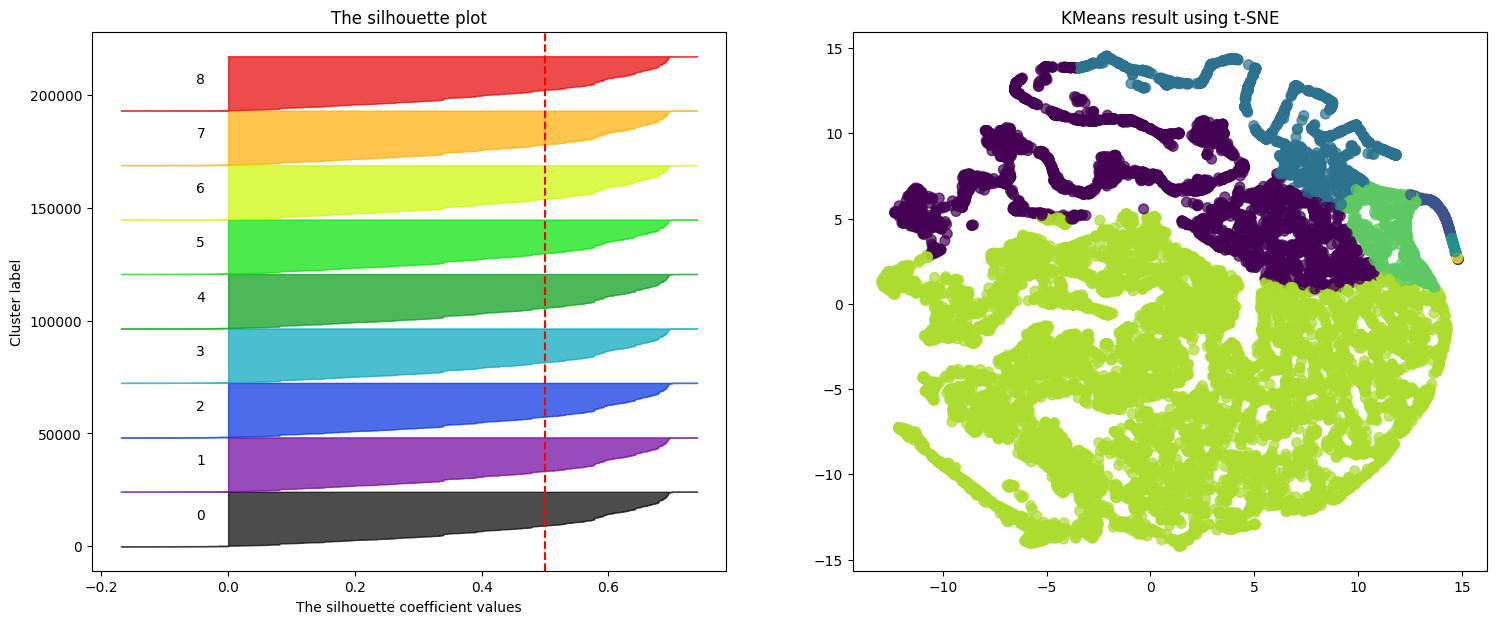

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

y_lower = 10 
for i in range(clustering_model.n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        silhouette_vals.sort()

        size_cluster_i = silhouette_vals.shape[0]

        y_upper = y_lower + len(silhouette_vals)
        color = cm.nipy_spectral(float(i)/clustering_model.n_clusters)
        ax1.fill_betweenx(np.arange(y_lower,y_upper),
                          0, silhouette_vals,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 


ax1.set_title("The silhouette plot")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")


ax2.scatter(x_tsne[:, 0], x_tsne[:, 1], c=cluster_labels, s=50, cmap='viridis', alpha=0.7)
ax2.set_title("KMeans result using t-SNE")

## 10.2 Prepared dataset clustering

Extract the very same features 

In [148]:
feature_vectors = pd.DataFrame(encoder.fit_transform(df[['Settore Merceologico Principale', 'Settore Merceologico Secondario',
       'Insegna', 'Tipo via', 'Via', 'Civico', 'Codice via', 'ZD', 'Accesso',
       'Isolato', 'Settore Storico Cf Preval']]))

In [149]:
feature_vectors[[feature_vectors.shape[1],feature_vectors.shape[1]+1]] = df[['Superficie Vendita','Superficie Altri Usi']]

In [150]:
feature_vectors

0      1      2      3      4      5      6      7      8      9      \
0        0.0    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
1        0.0    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
2        0.0    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
3        0.0    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
4        0.0    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
21831    0.0    0.0    0.0    0.0    1.0    1.0    0.0    0.0    0.0    0.0   
21832    0.0    0.0    0.0    0.0    1.0    0.0    0.0    1.0    0.0    0.0   
21833    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
21834    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
21835    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

       ...  12785  12786  12787  12788  12789  12790  12791  12792  12793  \
0      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   16.0   
2      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   36.0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
21831  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   20.0   
21832  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   45.0   
21833  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   28.0   
21834  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    7.0   
21835  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    8.0   

       12794  
0        0.0  
1        5.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
21831   64.0  
21832   15.0  
21833   12.0  
21834  125.0  
21835    4.0  

[21836 rows x 12795 columns]

Run KMeans

In [151]:
clustering_model = KMeans(n_clusters=9,n_init='auto',random_state=42)
cluster_labels = clustering_model.fit_predict(feature_vectors)

Compute silhouette scores

In [152]:
silhouette_vals = silhouette_samples(feature_vectors, cluster_labels) # the silhouette value for each sample
silhouette_avg = silhouette_score(feature_vectors, cluster_labels) # the mean value of each sample
silhouette_avg

0.604444541035374

Reduce dimensionality and plot resluts

In [153]:
x_tsne = tsne.fit_transform(feature_vectors)

Text(0.5, 1.0, 'KMeans result using t-SNE')

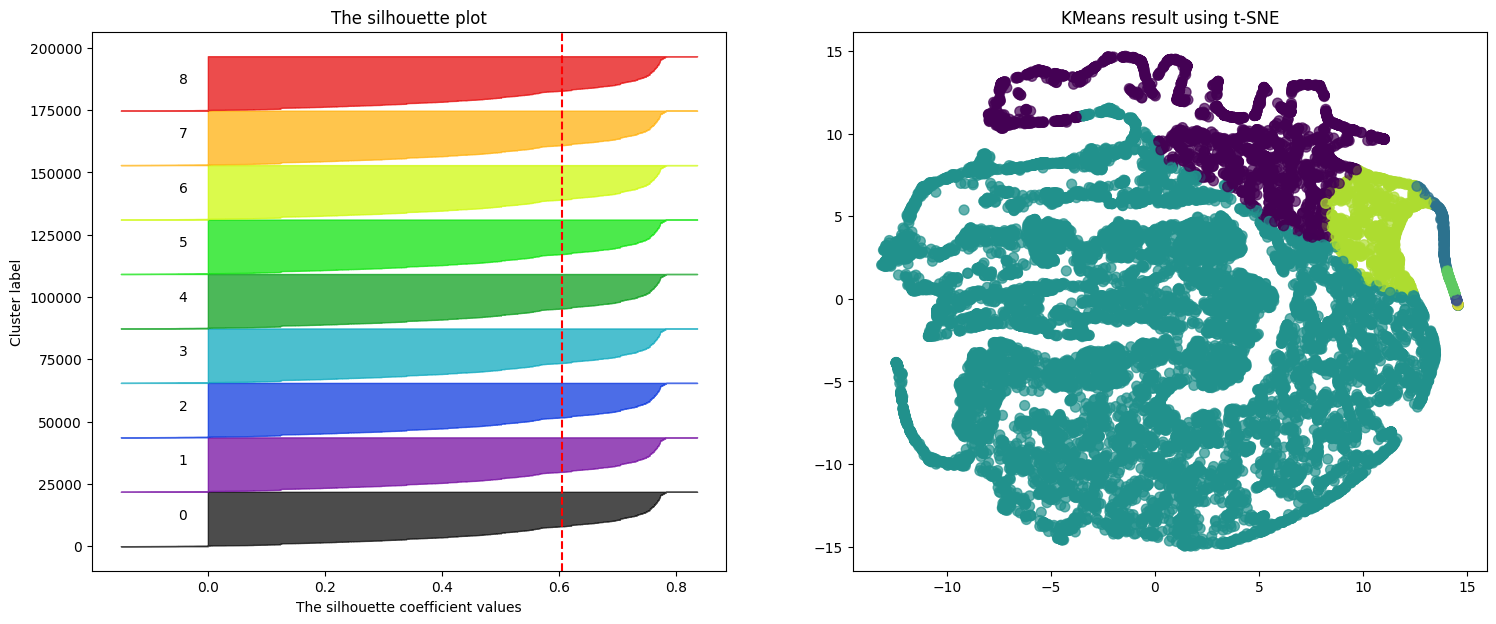

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

y_lower = 10 
for i in range(clustering_model.n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        silhouette_vals.sort()

        size_cluster_i = silhouette_vals.shape[0]

        y_upper = y_lower + len(silhouette_vals)
        color = cm.nipy_spectral(float(i)/clustering_model.n_clusters)
        ax1.fill_betweenx(np.arange(y_lower,y_upper),
                          0, silhouette_vals,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 


ax1.set_title("The silhouette plot")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")


ax2.scatter(x_tsne[:, 0], x_tsne[:, 1], c=cluster_labels, s=50, cmap='viridis', alpha=0.7)
ax2.set_title("KMeans result using t-SNE")